## Below the steps to identify the most promising stocks

1. have an excel file with all the tickers extracted from a filter on tradingview
2. load the tickers from the file and compute the ones having current assets > total liab
3. filter out the ones not respecting condition 2
4. compute the ncav(ps) and liqv(ps) of the last annual report
5. create a flag column "below ncav" indicating whether the price is below ncavps
6. create a flag column "below liqv" indicating whether the price is below liqvps
7. create a flag column if both 5 and 6 are respected
8. take the tickers respecting any of the condition 5, 6 or 7 and create the history plots
9. Select by hand the most promising ones
10. for the selected ones get the price to ncav ratio and price to liqv ratio
11. Sort by any of the two and see the most promising tickers

## Imports

In [1]:
import certifi
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from urllib.request import urlopen

## Functions

In [2]:
def compute_prelim_ncav(deco):
    return deco["totalCurrentAssets"] - deco["totalLiabilities"] > 0

def fill_w_none(deco, key):
    if key not in deco:
        deco[key] = 0

def get_price(deco):
    return deco["price"]

def compute_ncav(deco) -> float:
    return deco["totalCurrentAssets"] - deco["totalLiabilities"]

def compute_liqv(deco, factors_deco) -> float:
    fill_w_none(deco, "cashAndCashEquivalents")
    fill_w_none(deco, "netReceivables")
    fill_w_none(deco, "inventory")
    fill_w_none(deco, "propertyPlantEquipmentNet")
    return (
        deco["cashAndCashEquivalents"] +
        factors_deco["receivables_factor"]*deco["netReceivables"] +
        factors_deco["inventory_factor"]*deco["inventory"] +
        factors_deco["ppe_factor"]*deco["propertyPlantEquipmentNet"] -
        deco["totalLiabilities"]
    )
    
def compute_ncavps(deco) -> float:
    if deco["weightedAverageShsOutDil"] == 0:
        return -np.Inf
    ncav = compute_ncav(deco)
    return ncav / deco["weightedAverageShsOutDil"]

def compute_liqvps(deco, factors_deco) -> float:
    if deco["weightedAverageShsOutDil"] == 0:
        return -np.Inf
    liqv = compute_liqv(deco, factors_deco)
    return liqv / deco["weightedAverageShsOutDil"]

def compute_current_ratio(deco) -> float:
    return deco["totalCurrentAssets"] / (deco["totalCurrentLiabilities"] + 0.1)

def compute_de_ratio1(deco) -> float:
    return deco["totalLiabilities"] / (deco["totalStockholdersEquity"] + 0.1)

def compute_de_ratio2(deco) -> float:
    return deco["totalCurrentLiabilities"] / (deco["totalStockholdersEquity"] + 0.1)

def compute_de_ratio3(deco) -> float:
    return deco["totalDebt"] / (deco["totalStockholdersEquity"] + 0.1)

def plot_indicators(df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(1, 11, figsize=(30, 2))
    fs_df["ncavps"].plot.bar(ax=ax[0], title = "ncavps")
    df["liqvps"].plot.bar(ax=ax[1], title = "liqvps")
    df["totalCurrentAssets"].plot.bar(ax=ax[2], title = "current assets")
    df["totalCurrentLiabilities"].plot.bar(ax=ax[3], title = "current liab")
    min_ylim, max_ylim = (
        min(df["totalCurrentAssets"].min(), df["totalCurrentLiabilities"].min()),
        max(df["totalCurrentAssets"].max(), df["totalCurrentLiabilities"].max())
    )
    ax[2].set_ylim([min_ylim, max_ylim])
    ax[3].set_ylim([min_ylim, max_ylim])
    del min_ylim
    del max_ylim
    df["current_ratio"].plot.bar(ax=ax[4], title = "current ratio")
    df["totalAssets"].plot.bar(ax=ax[5], title = "total assets")
    df["totalLiabilities"].plot.bar(ax=ax[6], title = "total liab")
    min_ylim, max_ylim = (
        min(df["totalAssets"].min(), df["totalLiabilities"].min()),
        max(df["totalAssets"].max(), df["totalLiabilities"].max())
    )
    ax[5].set_ylim([min_ylim, max_ylim])
    ax[6].set_ylim([min_ylim, max_ylim])
    del min_ylim
    del max_ylim
    df["weightedAverageShsOutDil"].plot.bar(ax=ax[7], title = "shares outs")
    df["de_ratio1"].plot.bar(ax=ax[8], title = "total liab / shares outs")
    df["de_ratio2"].plot.bar(ax=ax[9], title = "current liab / shares outs")
    df["de_ratio3"].plot.bar(ax=ax[10], title = "total debt / shares outs")
    min_ylim, max_ylim = (
        min(df["de_ratio1"].min(), df["de_ratio2"].min(), df["de_ratio3"].min()),
        max(df["de_ratio1"].max(), df["de_ratio2"].max(), df["de_ratio3"].max())
    )
    ax[8].set_ylim([min_ylim, max_ylim])
    ax[9].set_ylim([min_ylim, max_ylim])
    ax[10].set_ylim([min_ylim, max_ylim])
    del min_ylim
    del max_ylim
    plt.show()

## Constants

In [3]:
KEY = ""

In [4]:
factors = {
    "receivables_factor": 0.8,
    "inventory_factor": 0.6,
    "ppe_factor": 0.67,
}

In [5]:
bs_cols = [
    "symbol", "cashAndCashEquivalents", "netReceivables",
    "inventory", "propertyPlantEquipmentNet",
    "totalCurrentAssets", "totalAssets", "totalCurrentLiabilities", 
    "totalLiabilities", "totalStockholdersEquity",
    "totalDebt", "netDebt",
]
is_cols = [
    "weightedAverageShsOutDil",
]

# Load tickers

In [6]:
with open("tickers_list_28062023.txt", "r") as f:
    TICKERS = f.read().split("\n")

In [7]:
# this will get rid of duplicated tickers.
# THis means there will only be one ticker for different companies having the same symbol in different exchanges
TICKERS = list(set(TICKERS))

Below we compute the preliminary NCAV (current assets - total_liabilities). By doing this we strictly focus ourselves in filtering out the companies that will for sure not have a positive NCAV
We will filter out the companies that don't have a positive preliminary NCAV
On the rest of the accepted companies we will flag those having a current price below ncav, current price below liqv and current price below both ncav and liqv

In [8]:
%%time
# NEW CODE
# compute preliminary ncav (current assets - total liabilities)
preliminary_ncav = {}
zero_current_price = []
missed_ticker = []
tickers_to_accept = []
notes = {}

for ticker in tqdm(TICKERS):
    
    url_balance_sheet = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?limit=1&apikey={KEY}"
    url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=1&apikey={KEY}"
    url_price = f"https://financialmodelingprep.com/api/v3/quote/{ticker}?limit=1&apikey={KEY}"
    
    try:
        response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
        response_price = urlopen(url_price, cafile=certifi.where())
    except:
        missed_ticker.append(ticker)
        continue
    
    data_balance_sheet = response_balance_sheet.read().decode("utf-8")
    data_balance_sheet = json.loads(data_balance_sheet)
    if len(data_balance_sheet) == 0:
        continue # here we should log the ticker with this issue
    data_balance_sheet = data_balance_sheet[-1]
    flag = compute_prelim_ncav(data_balance_sheet)
    data_price = response_price.read().decode("utf-8")
    data_price = json.loads(data_price)
    if len(data_price) == 0:
        continue # here we should log the ticker with this issue
    data_price = data_price[-1]
    current_price = data_price["price"]
    if flag:
        
        tickers_to_accept.append(ticker)
        response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
        data_income_stmt = response_income_stmt.read().decode("utf-8")
        data_income_stmt = json.loads(data_income_stmt)
        if len(data_income_stmt) == 0:
            continue # here we should log the ticker with this issue
        data_income_stmt = data_income_stmt[-1]
        data_balance_sheet.update(
            {
                "weightedAverageShsOutDil": data_income_stmt["weightedAverageShsOutDil"],
                "income_stmt_date": data_income_stmt["date"],
            }
        )
        if data_balance_sheet["date"] != data_balance_sheet["income_stmt_date"]:
            print(f"dates of last income statement and balance sheet are not the same for ticker {ticker}")
            print(f"\tincome stmt date: {data_balance_sheet['income_stmt_date']}, balance sheet date: {data_balance_sheet['date']}")
            continue
            
        ncavps = compute_ncavps(data_balance_sheet)
        liqvps = compute_liqvps(data_balance_sheet, factors)
        if current_price is None : 
            zero_current_price.append(ticker)
            continue
        notes[ticker] = {
            "current_price": current_price,
            "below_ncav": current_price < ncavps,
            "below_liqv": current_price < liqvps,
        }

  0%|                                                                                                                               | 0/1013 [00:00<?, ?it/s]<timed exec>:16: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
<timed exec>:17: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
 17%|███████████████████▉                                                                                                 | 173/1013 [04:50<25:15,  1.80s/it]

dates of last income statement and balance sheet are not the same for ticker TWIN
	income stmt date: 2023-06-30, balance sheet date: 2022-06-30


 18%|█████████████████████                                                                                                | 182/1013 [05:05<22:16,  1.61s/it]

dates of last income statement and balance sheet are not the same for ticker FLXS
	income stmt date: 2023-06-30, balance sheet date: 2022-06-30


 33%|██████████████████████████████████████▍                                                                              | 333/1013 [09:10<19:47,  1.75s/it]

dates of last income statement and balance sheet are not the same for ticker AAU
	income stmt date: 2022-12-31, balance sheet date: 2021-12-31


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1013/1013 [27:57<00:00,  1.66s/it]

CPU times: user 38.7 s, sys: 3.32 s, total: 42 s
Wall time: 27min 57s


Transform dict into pandas and add "below_both" and "below_none" cols. below_both is a flag that tells whether the current price is below both ncav and liqv. below_none is a flag that tells whether the current price is above both ncav and liqv. 

In [9]:
price_to_liquid_df = pd.DataFrame(notes).T
price_to_liquid_df["below_both"] = price_to_liquid_df.apply(lambda x: x["below_ncav"] and x["below_liqv"], axis=1)
price_to_liquid_df["below_none"] = price_to_liquid_df.apply(lambda x: x["below_ncav"] == False and x["below_liqv"] == False, axis=1)
price_to_liquid_df.sample(5)

current_price below_ncav below_liqv  below_both  below_none
CBAT        0.8514      False      False       False        True
FRZA        0.9714       True       True        True       False
TGEN          1.09      False      False       False        True
SSIC          9.54       True       True        True       False
FTCO          6.06      False      False       False        True

We filter out the rows having a `below_none` value of True. This represents the rows where the company's current price is above both ncav and liqv

In [10]:
price_to_liquid_df = price_to_liquid_df.loc[price_to_liquid_df["below_none"] != True]
price_to_liquid_df.shape

(120, 5)

In [11]:
len(tickers_to_accept)

336

In [12]:
selected_tickers = list(price_to_liquid_df.index)

* cashAndCashEquivalents
* netReceivables
* inventory
* propertyPlantEquipmentNet
* totalCurrentAssets
* totalLiabilities

### The following values will be computed/extracted over a 10 year period:

- NCAV
- LIQV
- Current Assets
- Current Liab
- Current Ratio
- Total Assets
- Total Liabs
- Shares outstanding
- Total Liab / Total Shareholders' Equity (D/E ratio 1)
- Current Liab / Total Shareholders' Equity (D/E ratio 2)
- Total debt / Total Shareholders' Equity (D/E ratio 3)
- date

<timed exec>:10: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
<timed exec>:11: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.


OBLG


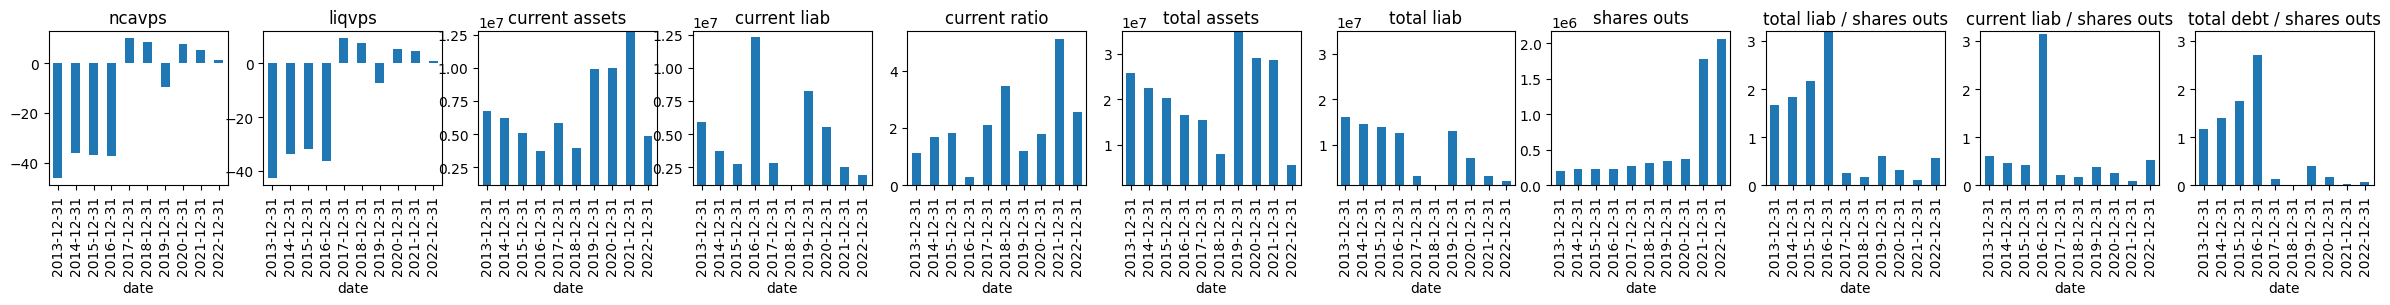

SVFD


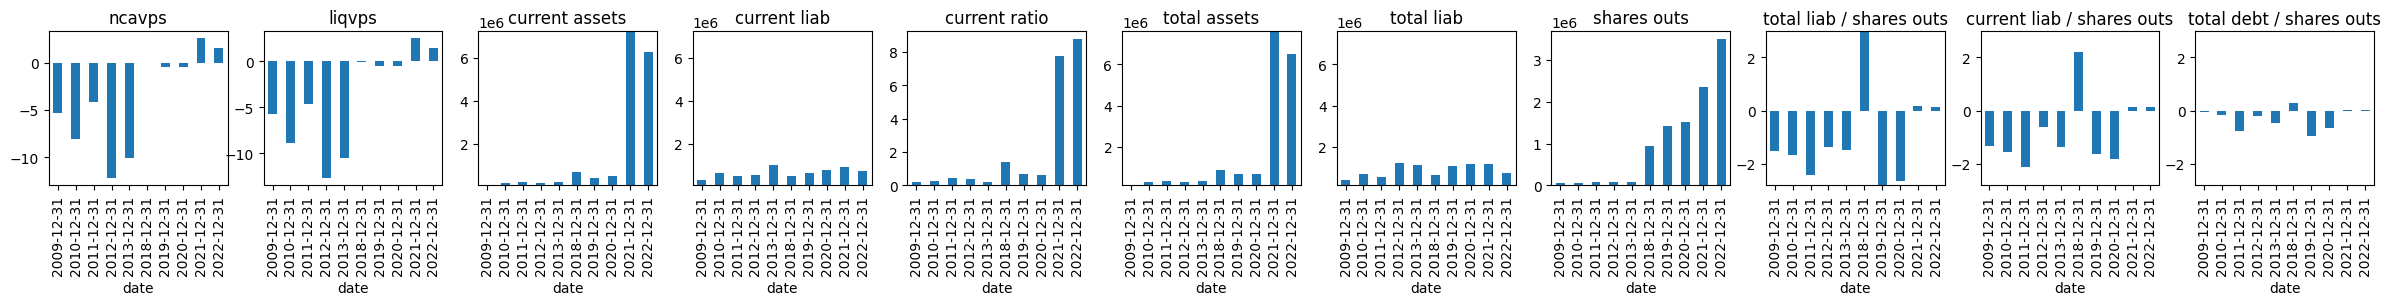

MRIN


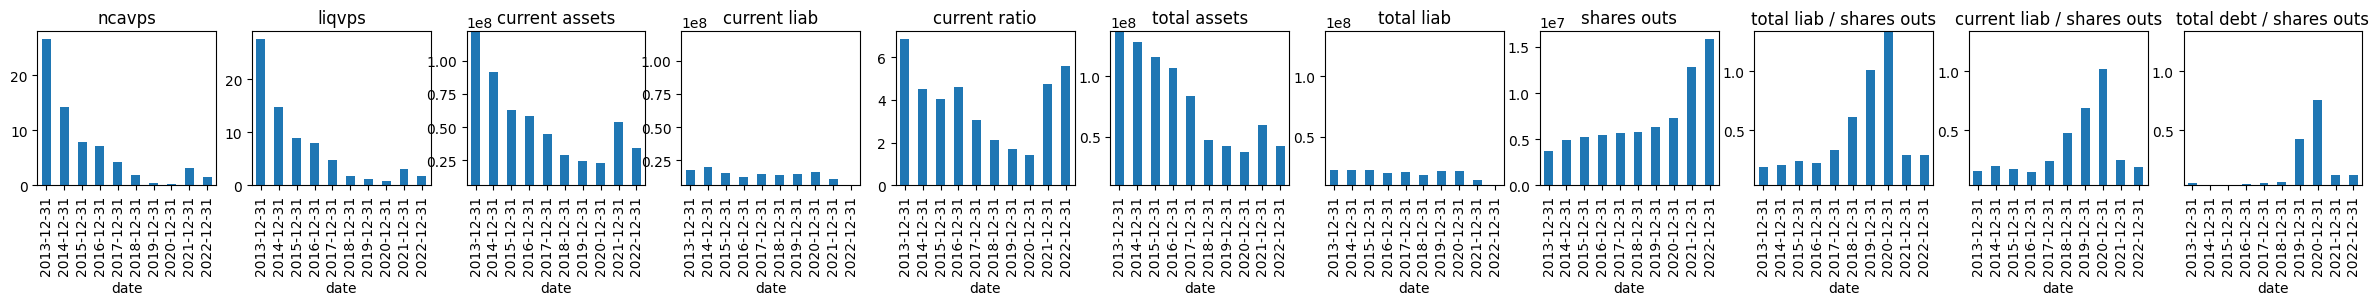

SLV


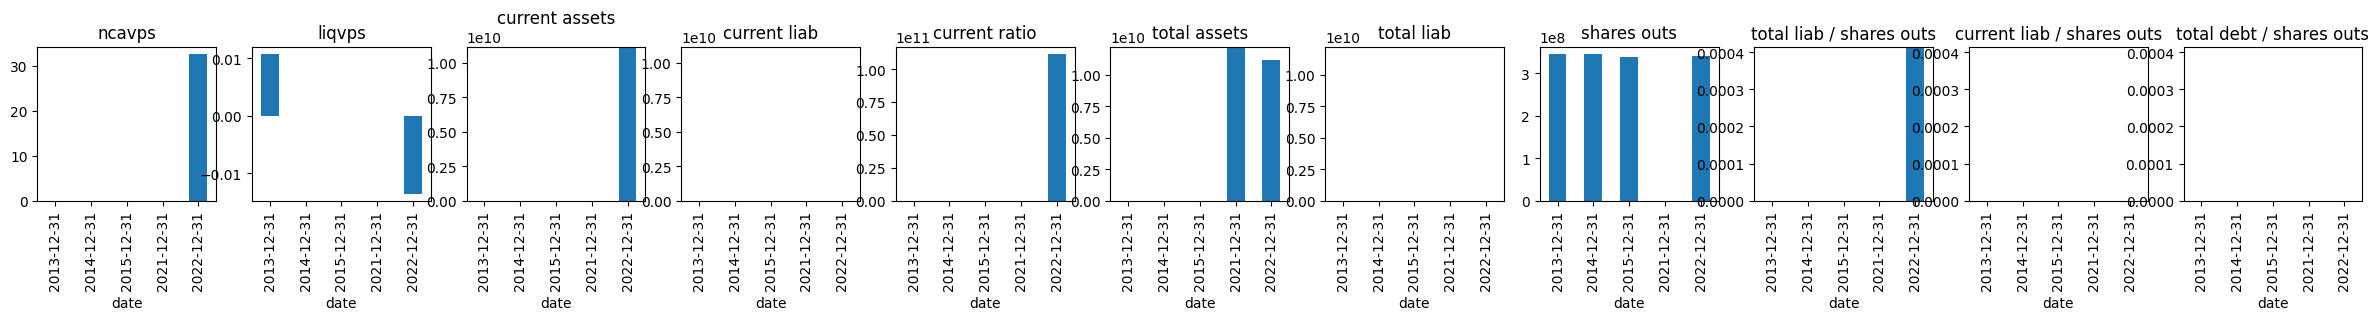

EBON


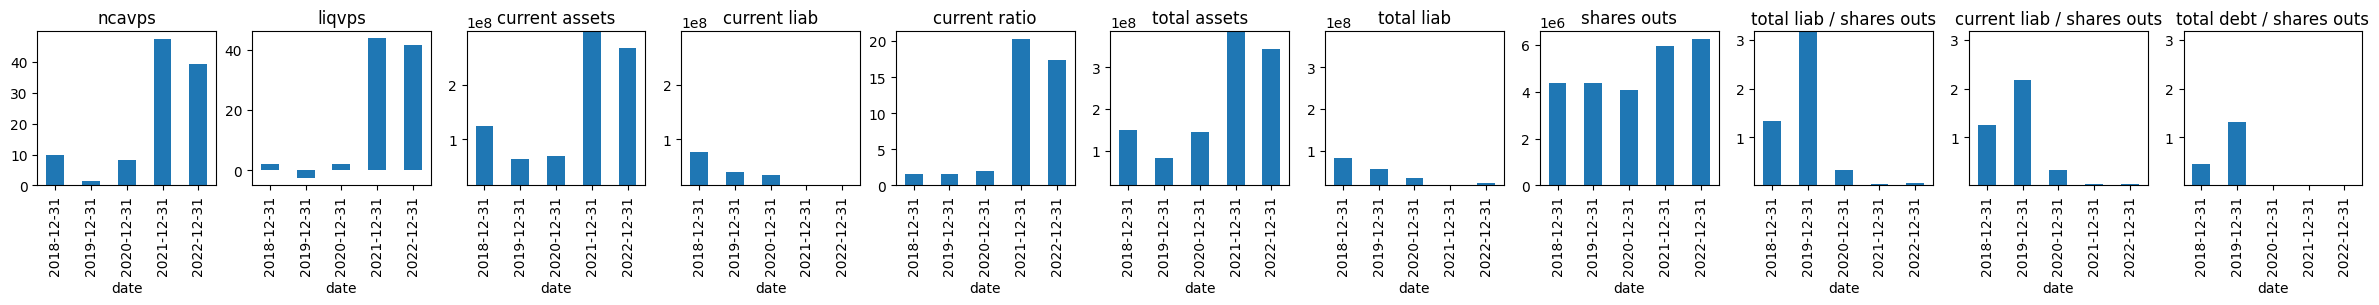

TBLT


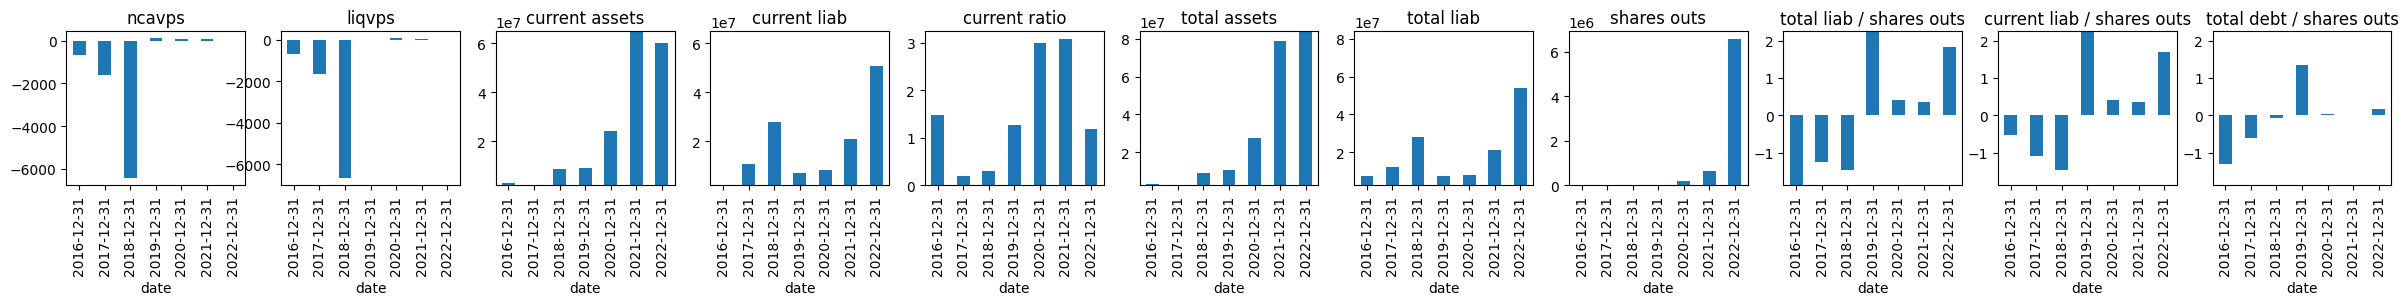

TUSK


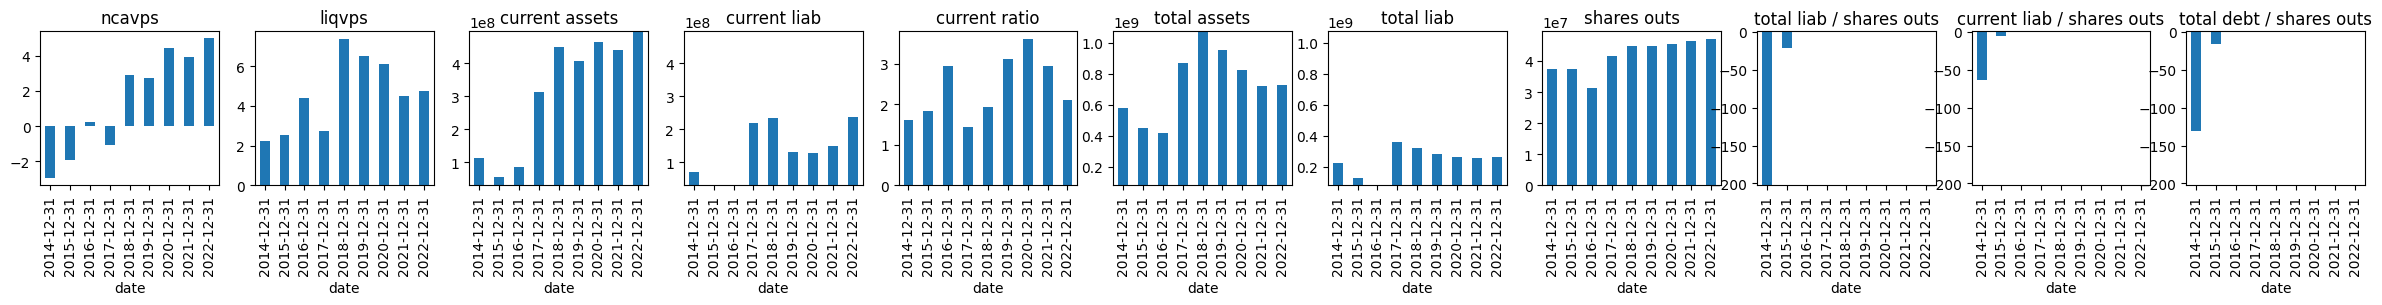

BTB


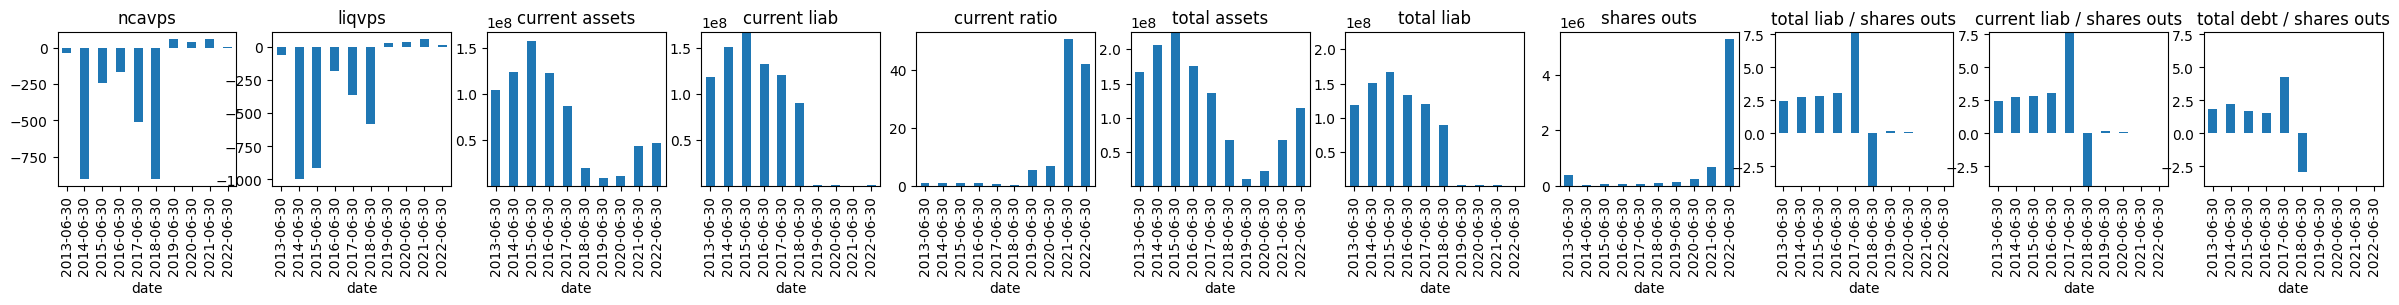

GTEC


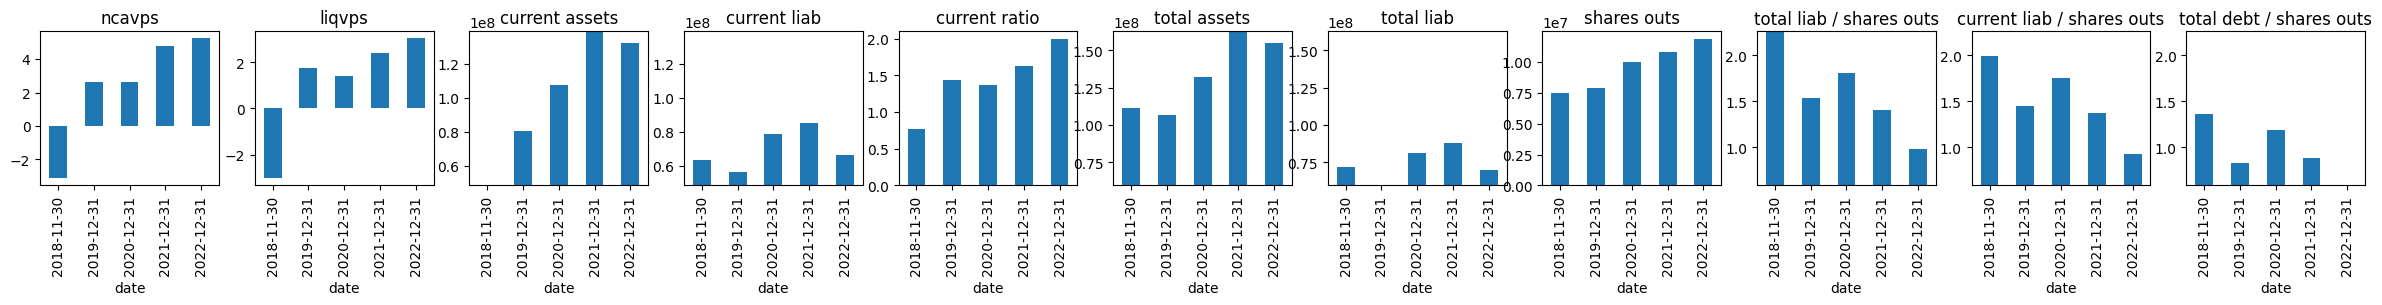

API


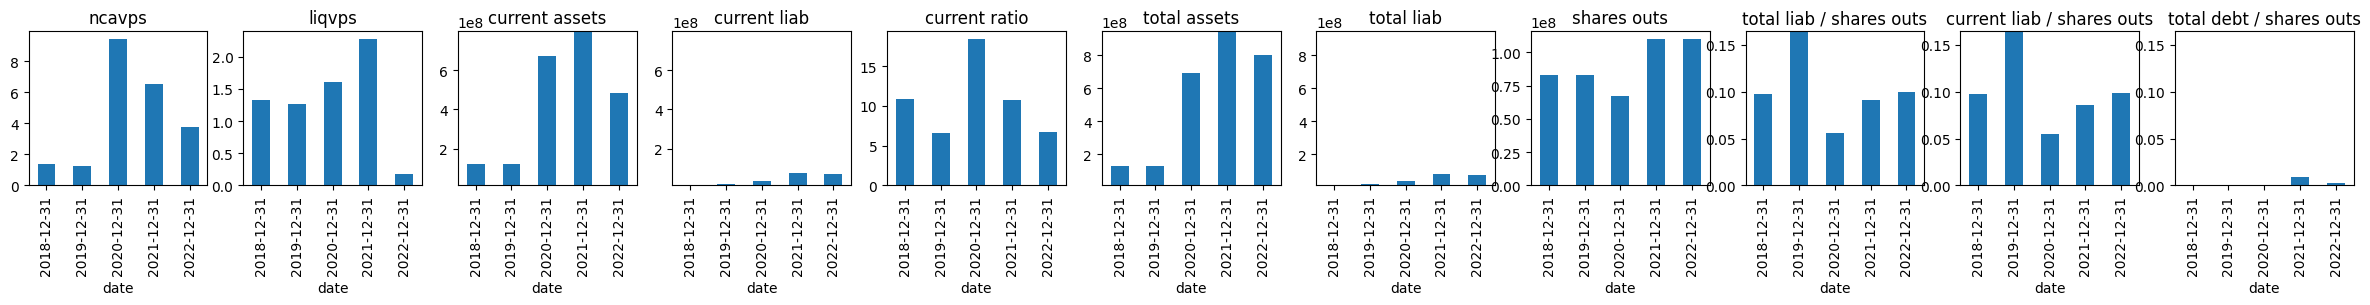

ITP


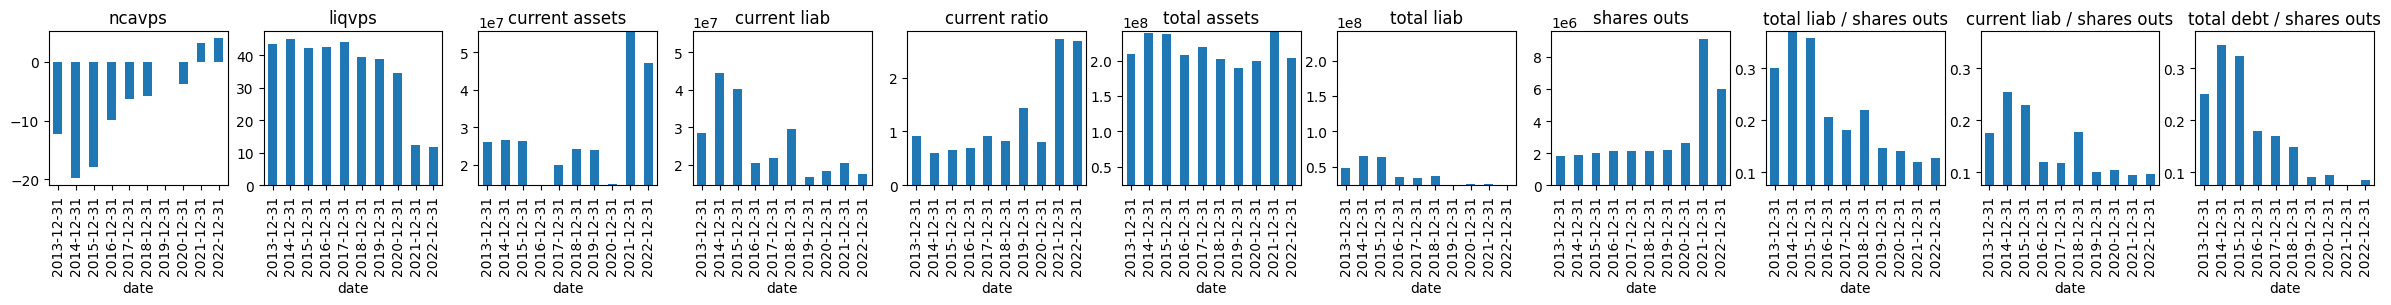

UTSI


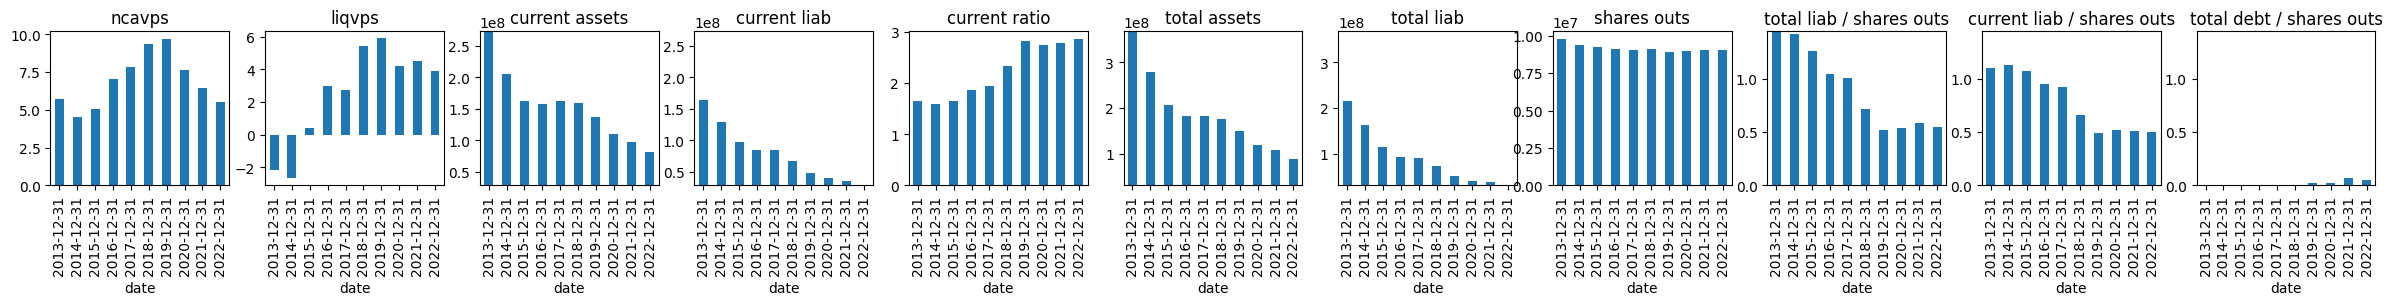

ATY


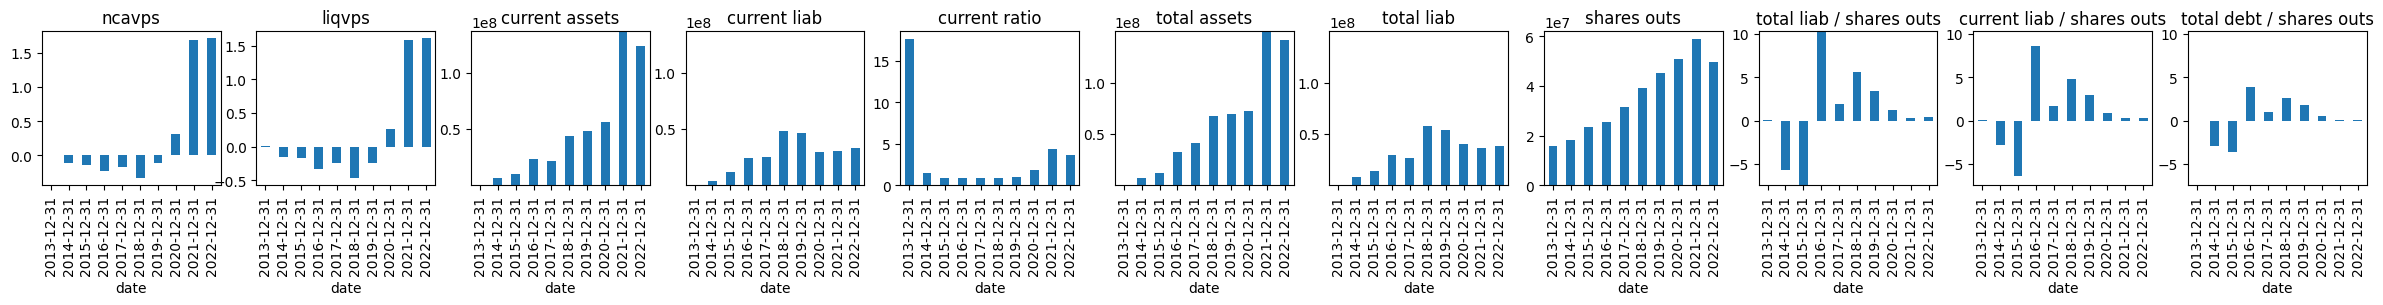

KBNT


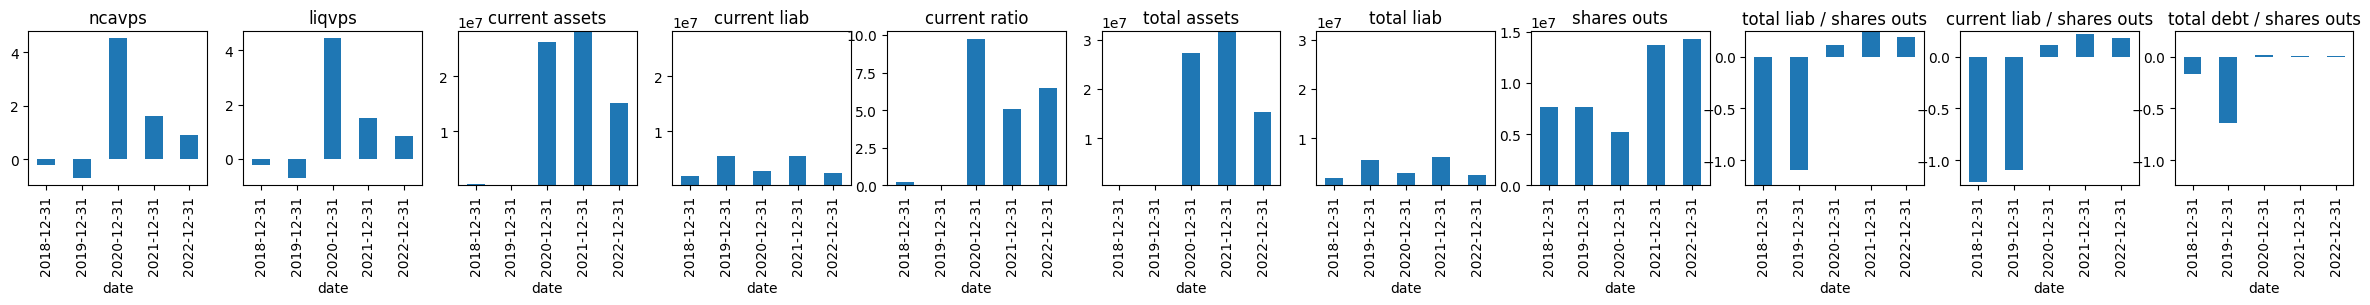

NCSM


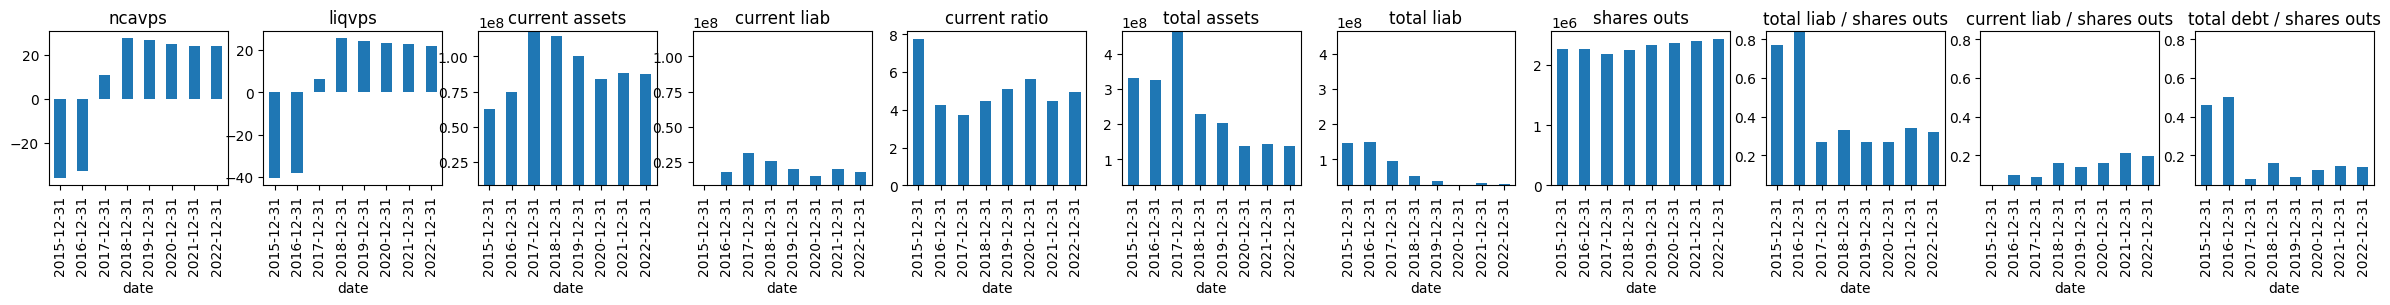

STRT


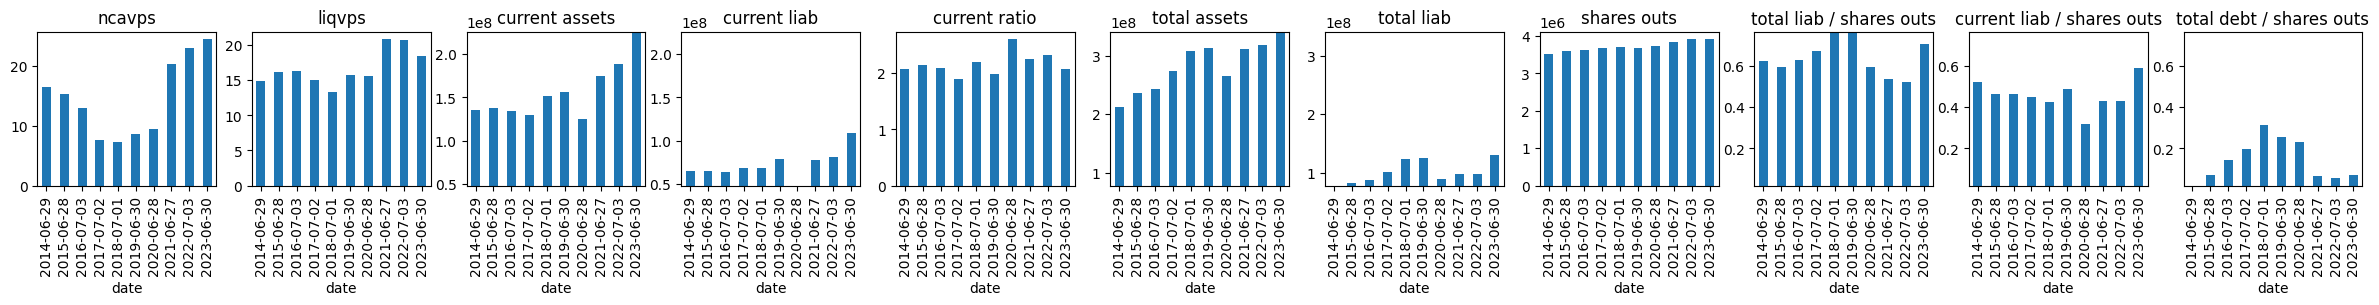

ATXG


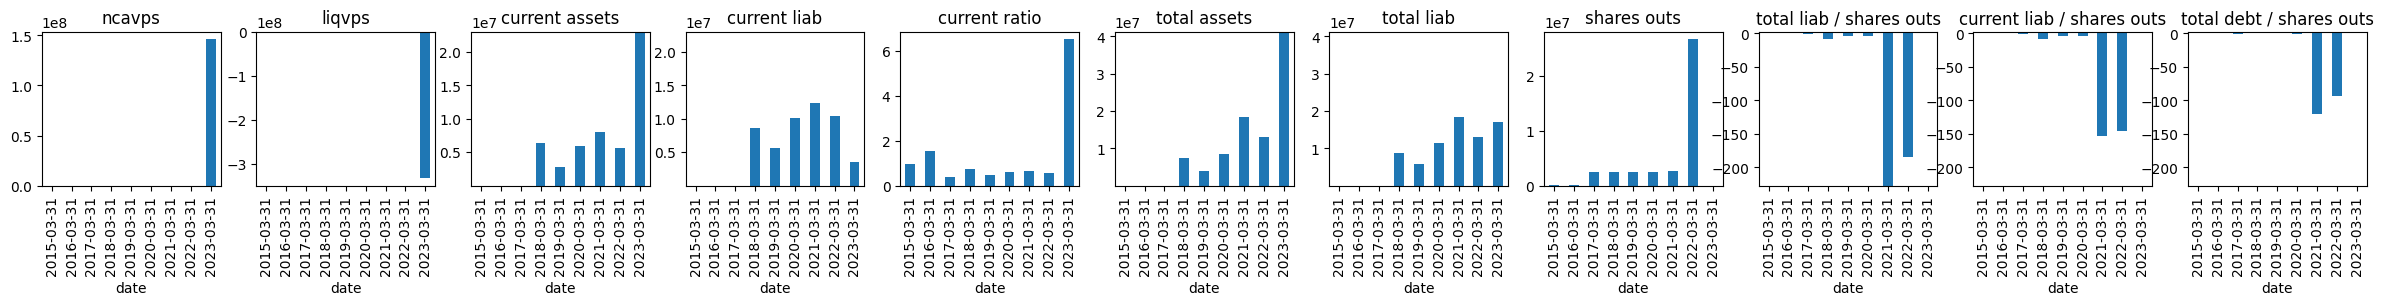

APWC


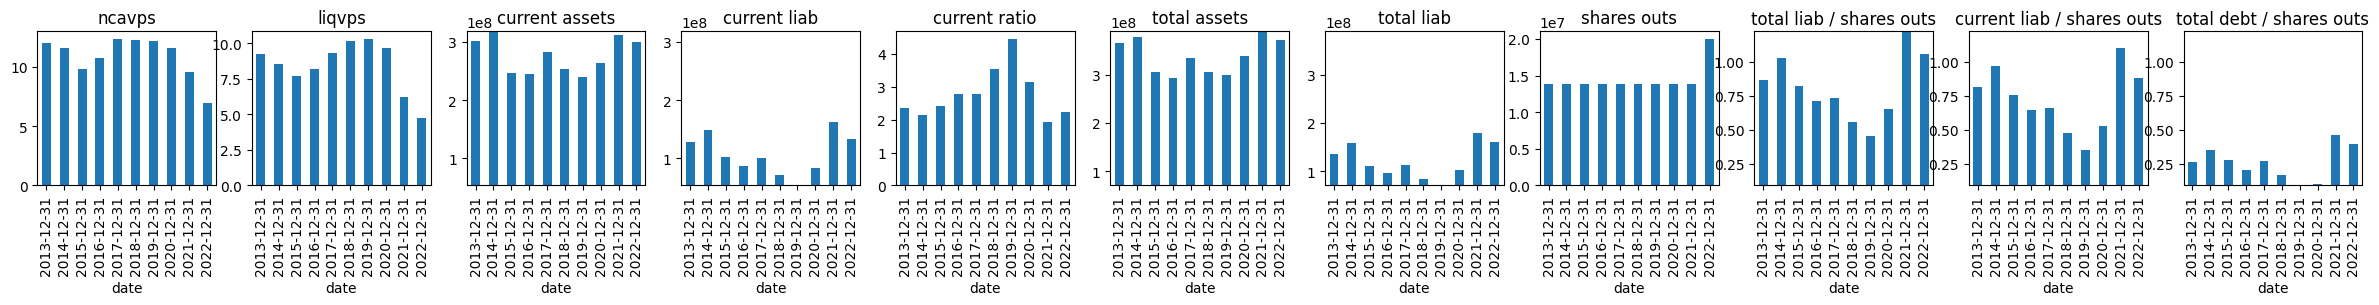

LMFA


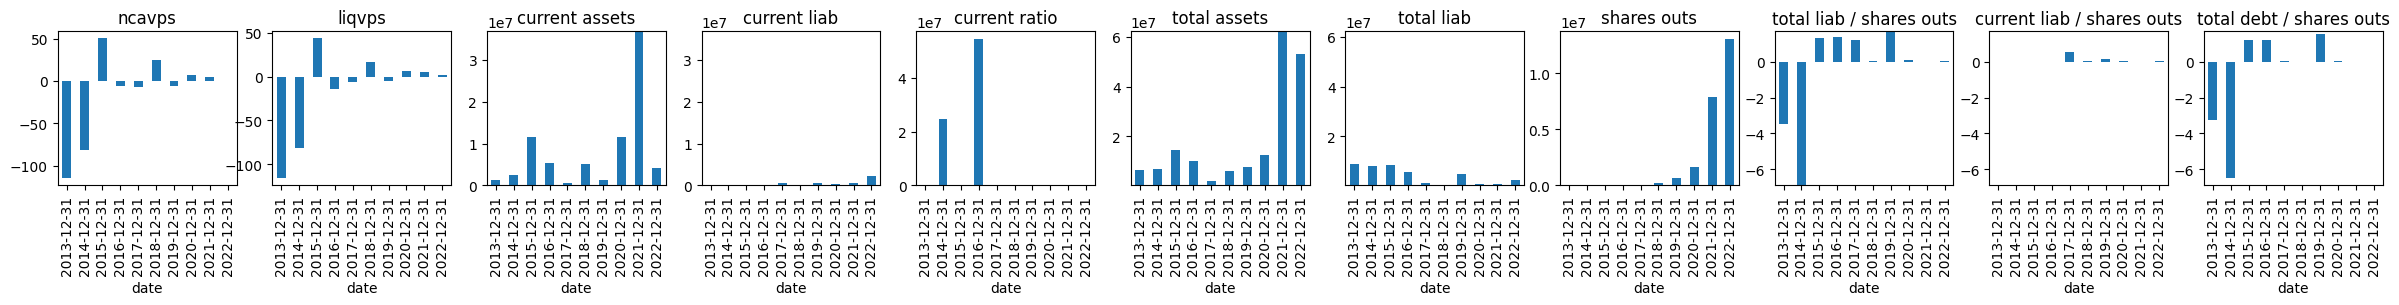

GURE


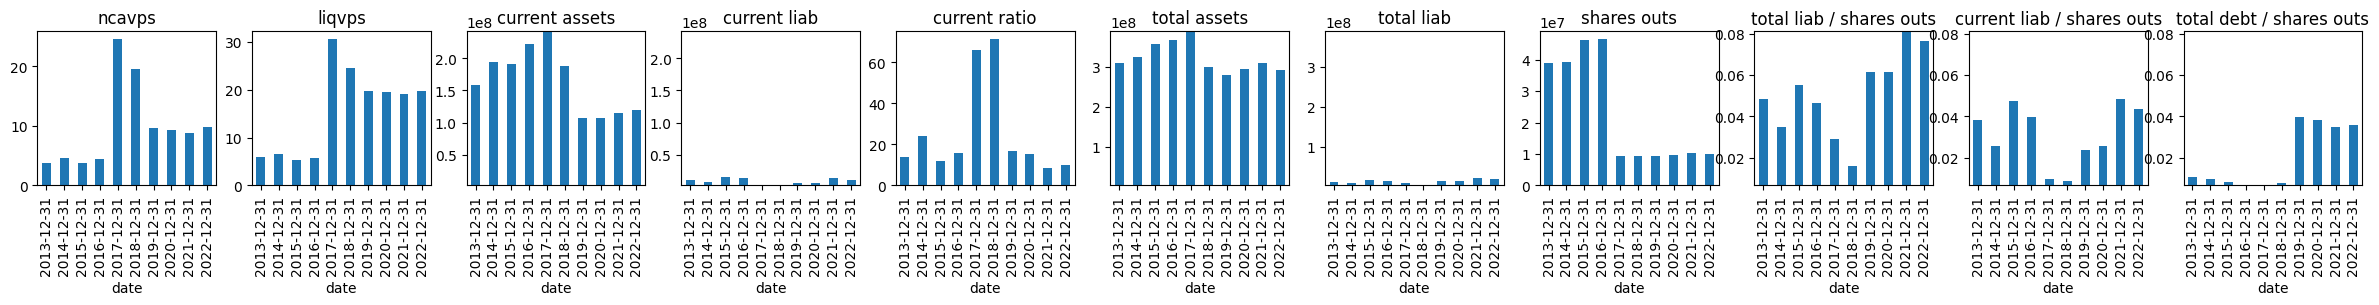

CVR


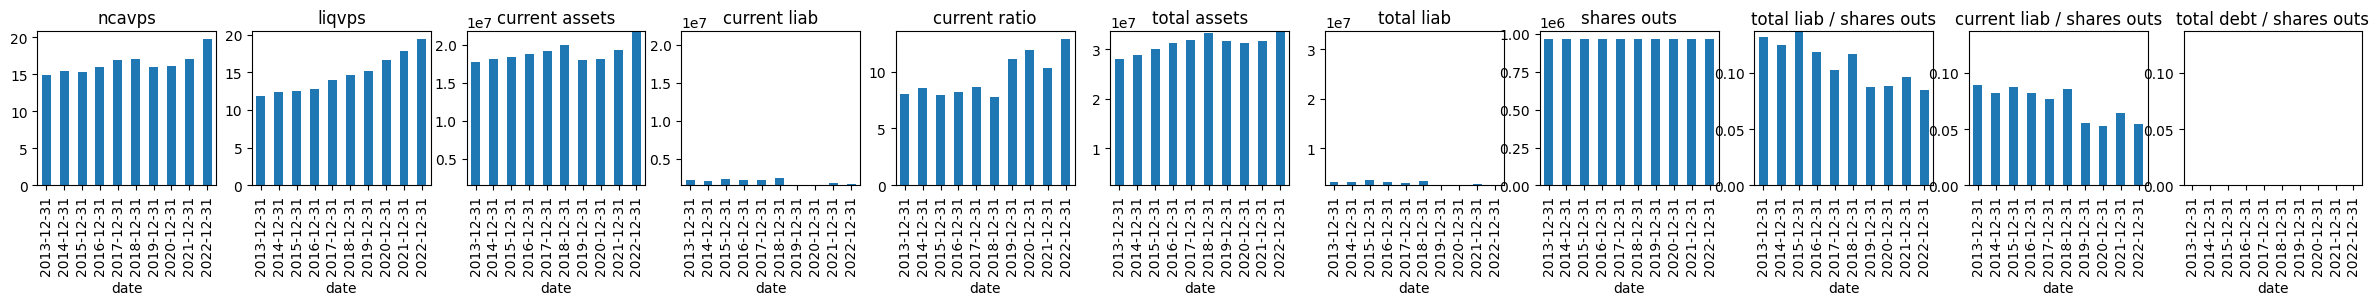

SASI


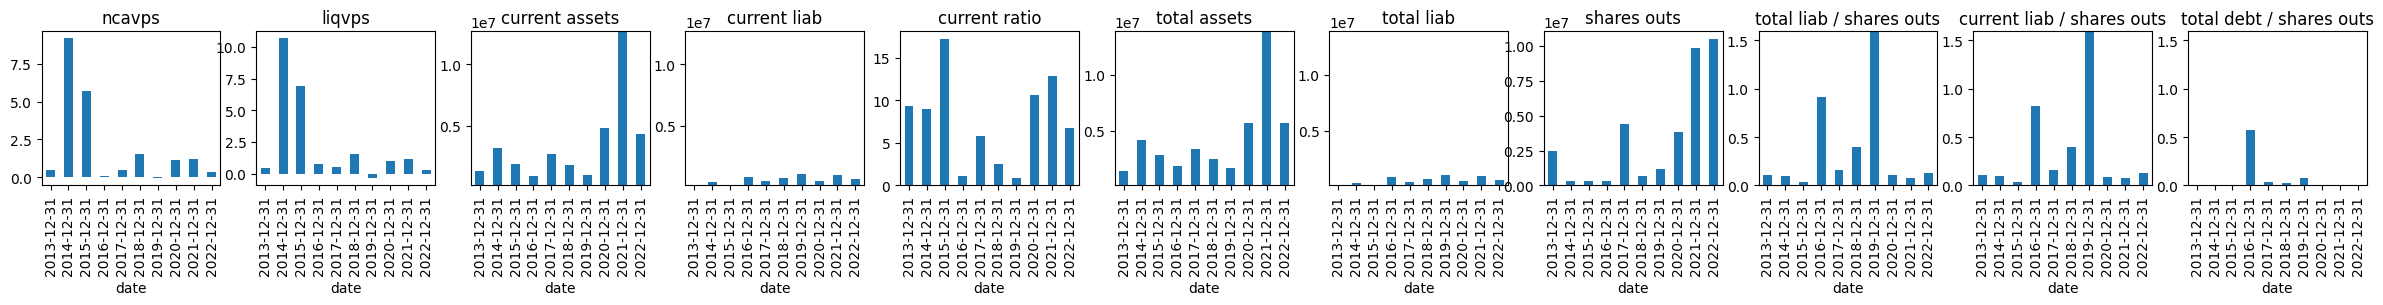

PRSO


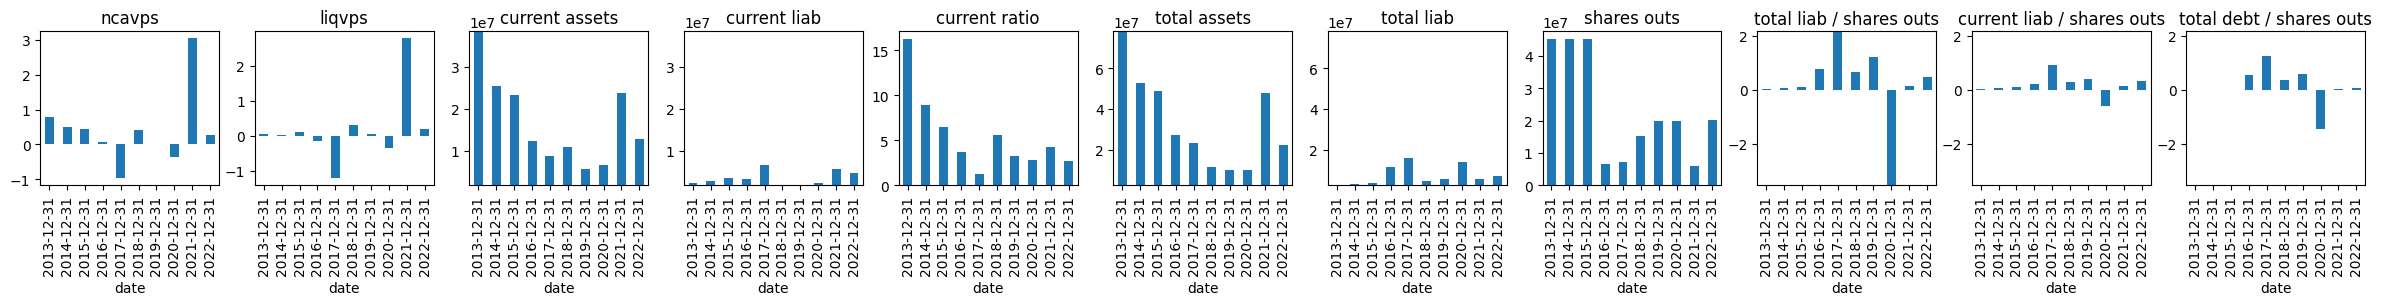

CTHR


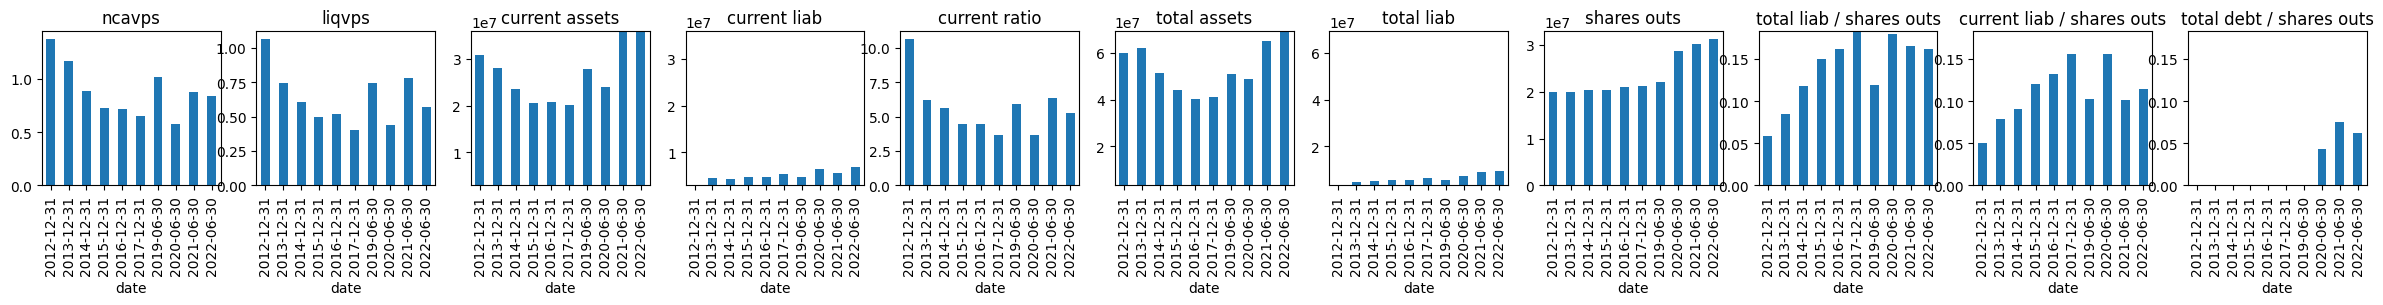

ISPC


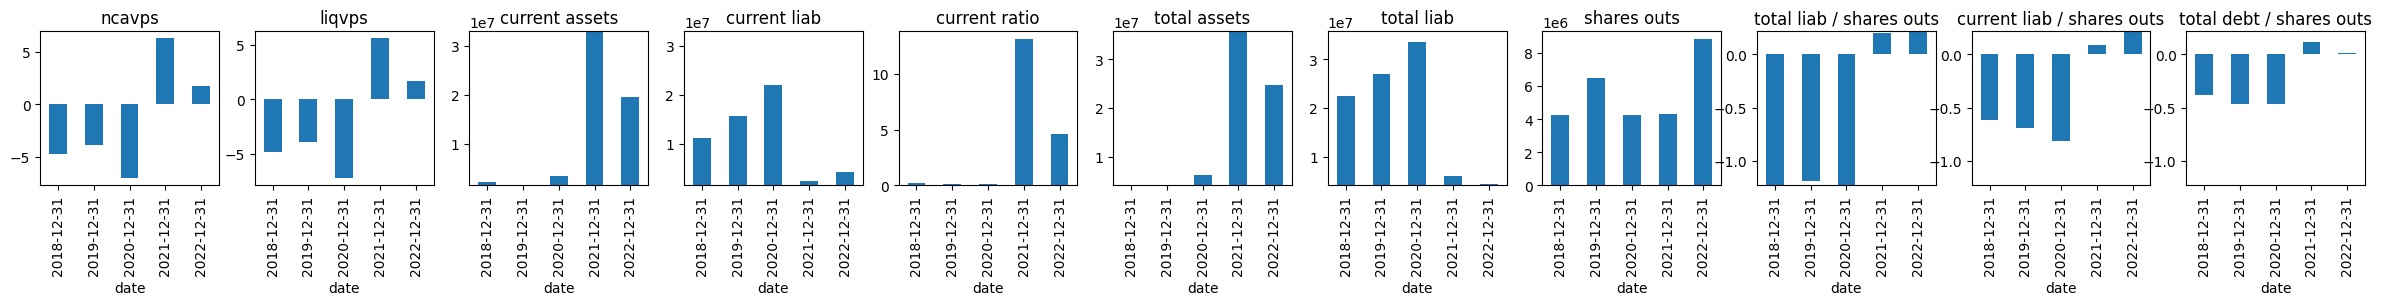

GNLN


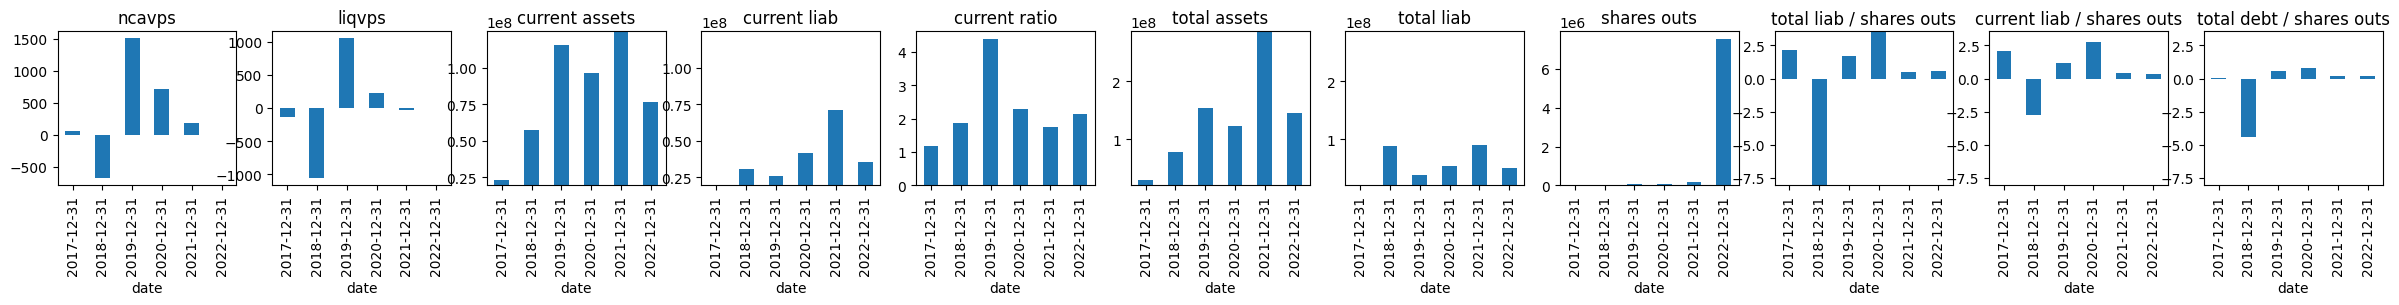

MSN


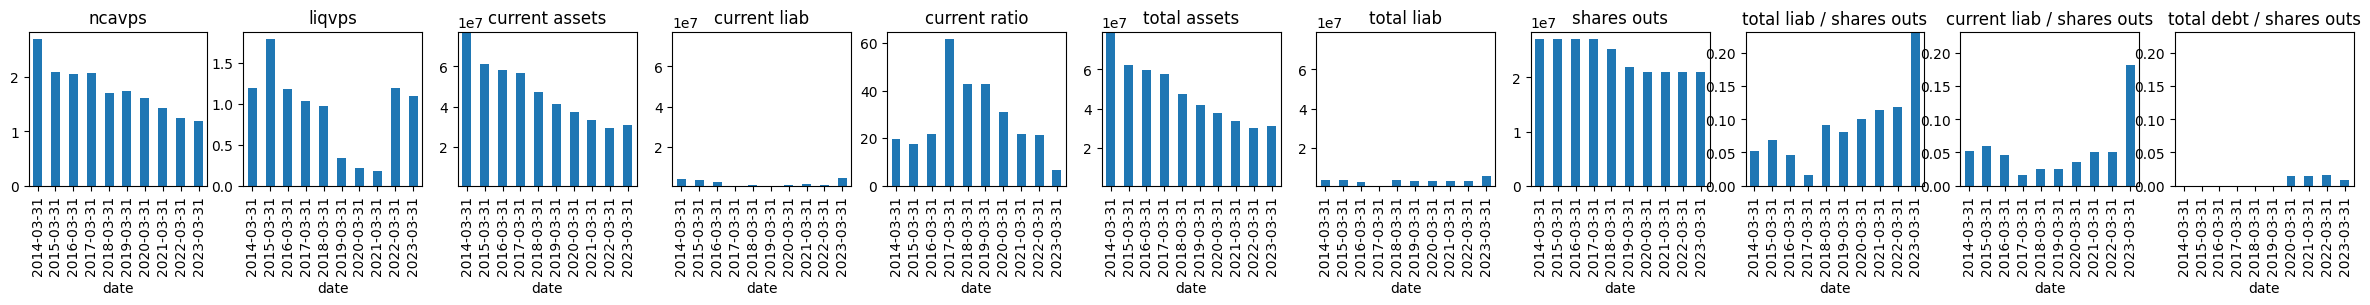

JVA


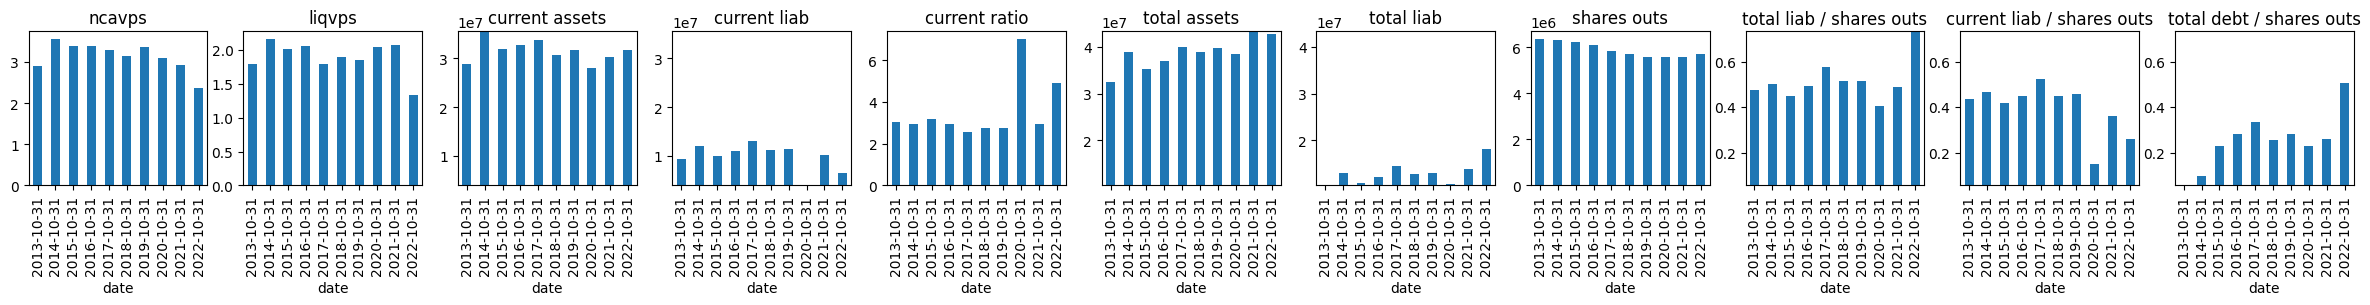

SISI


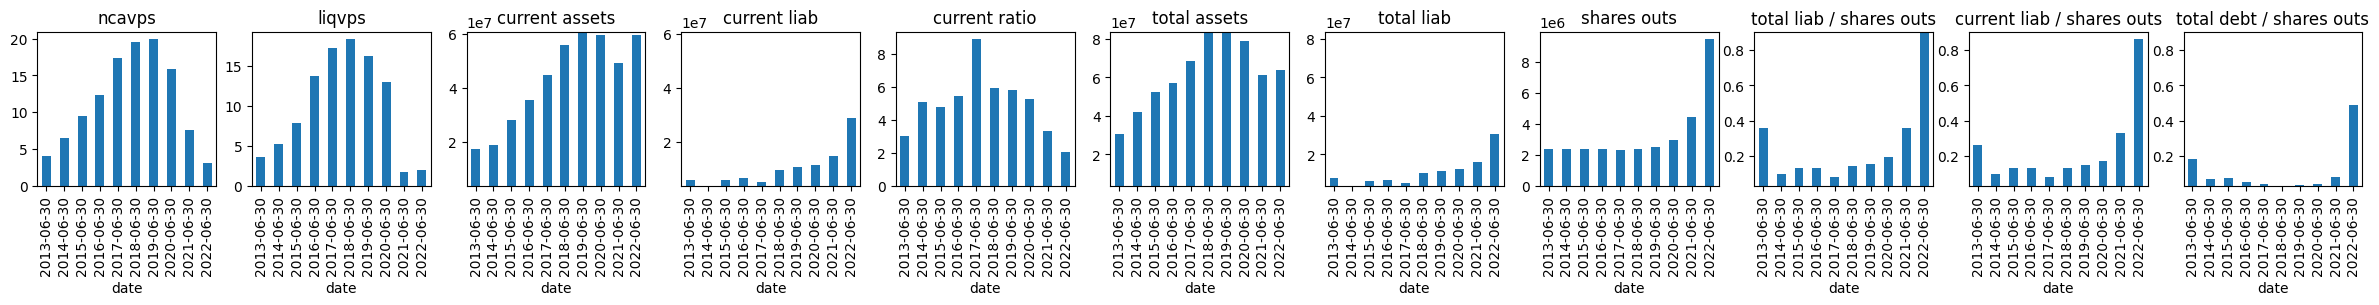

GROM


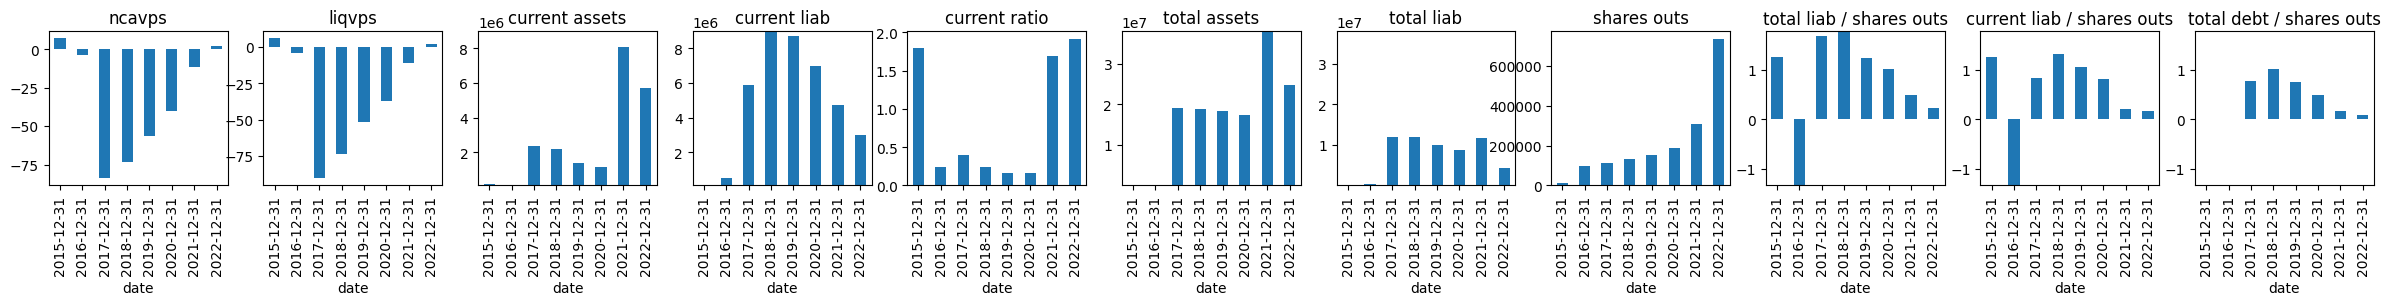

SSY


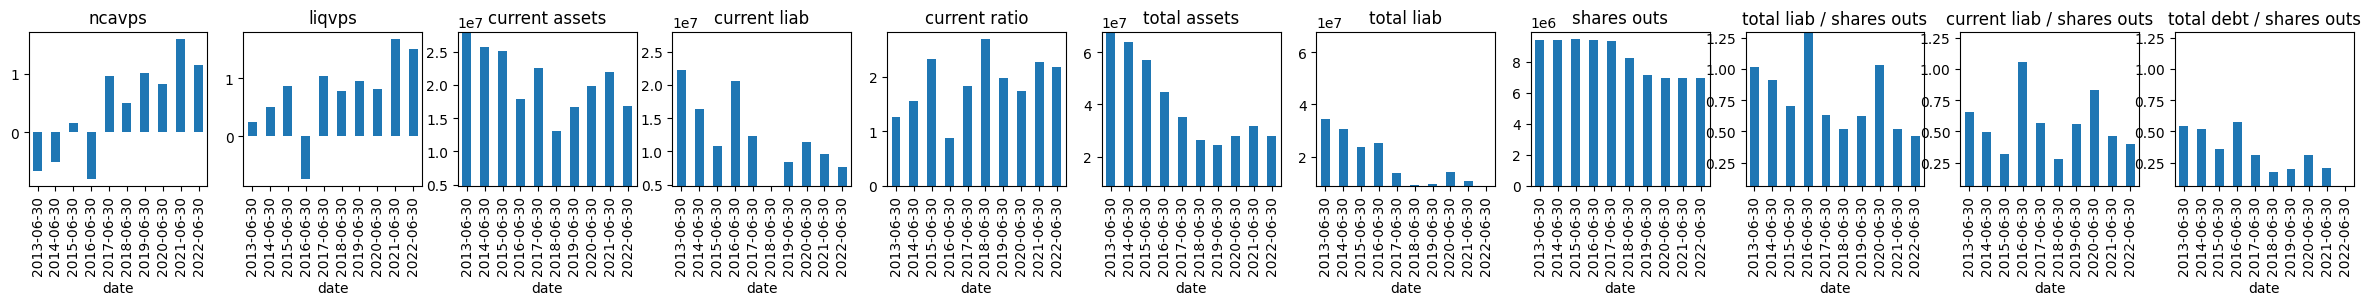

VHC


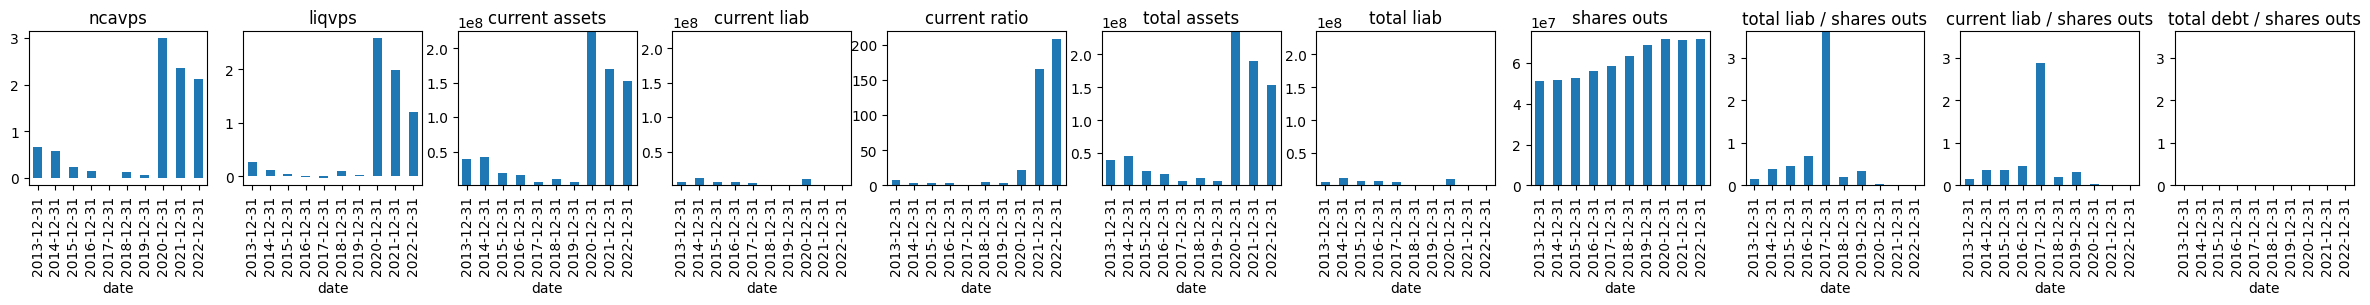

OPTT


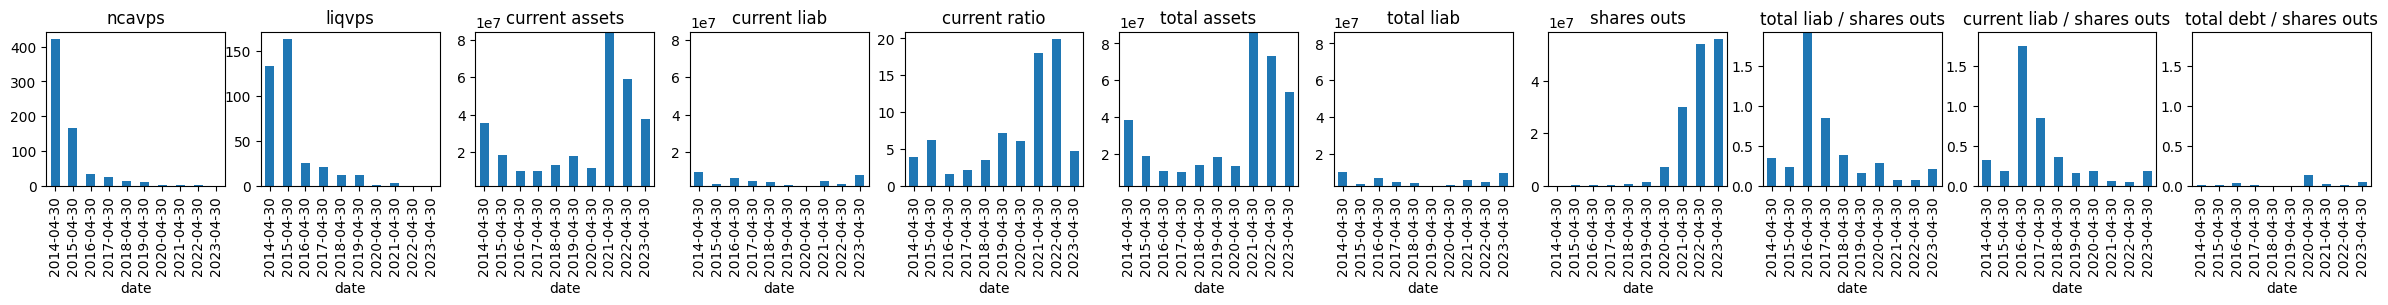

WWR


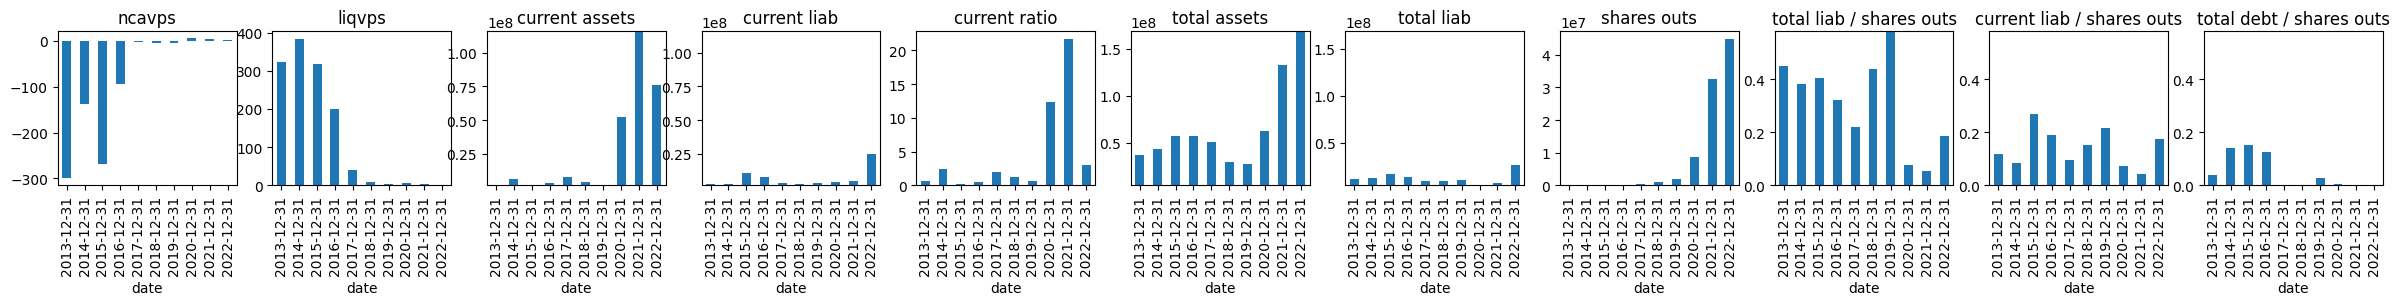

TLRS


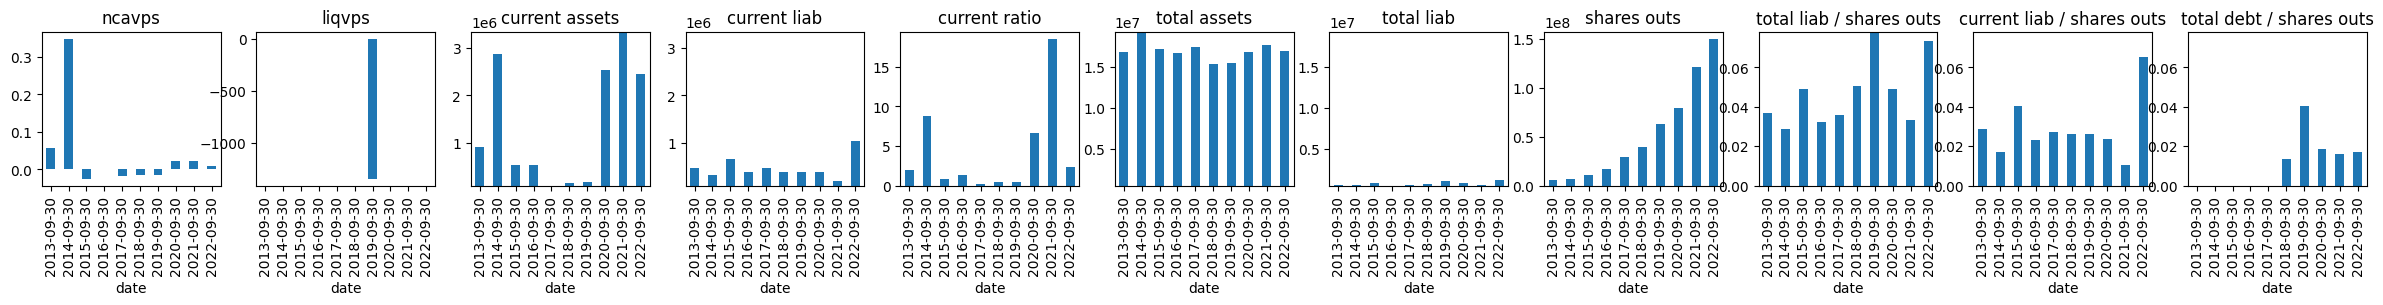

SNES


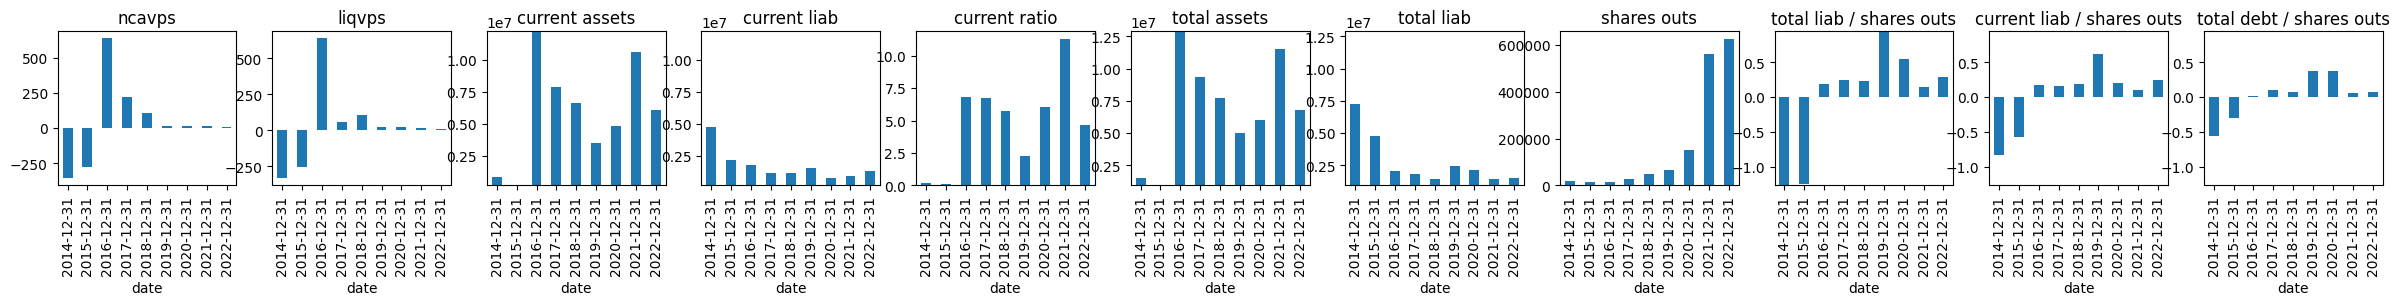

RCAT


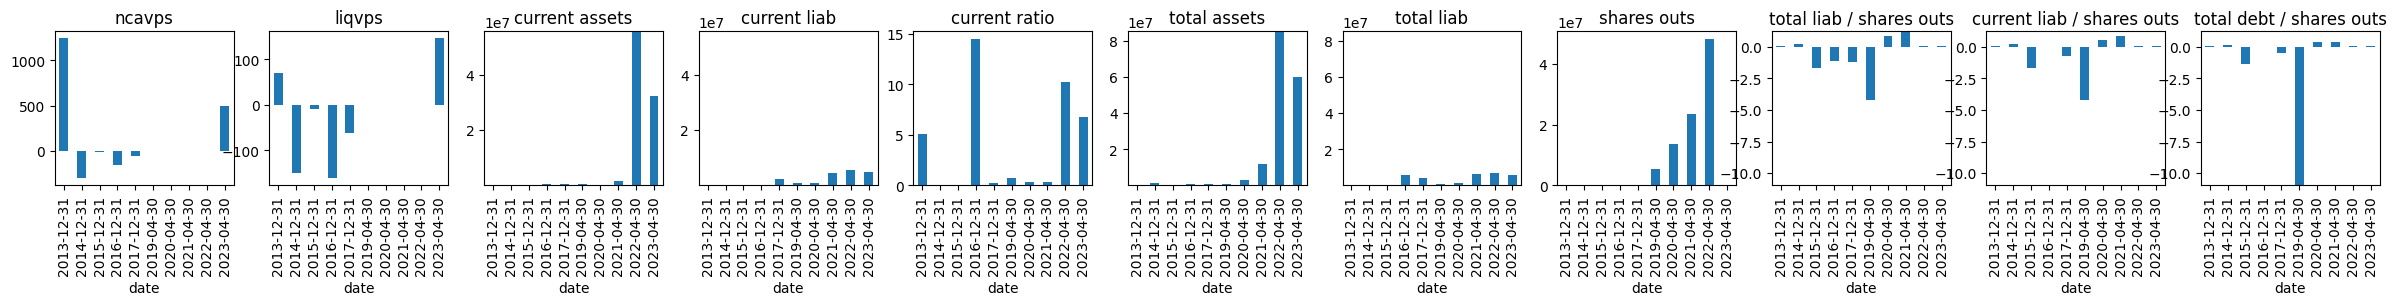

CAN


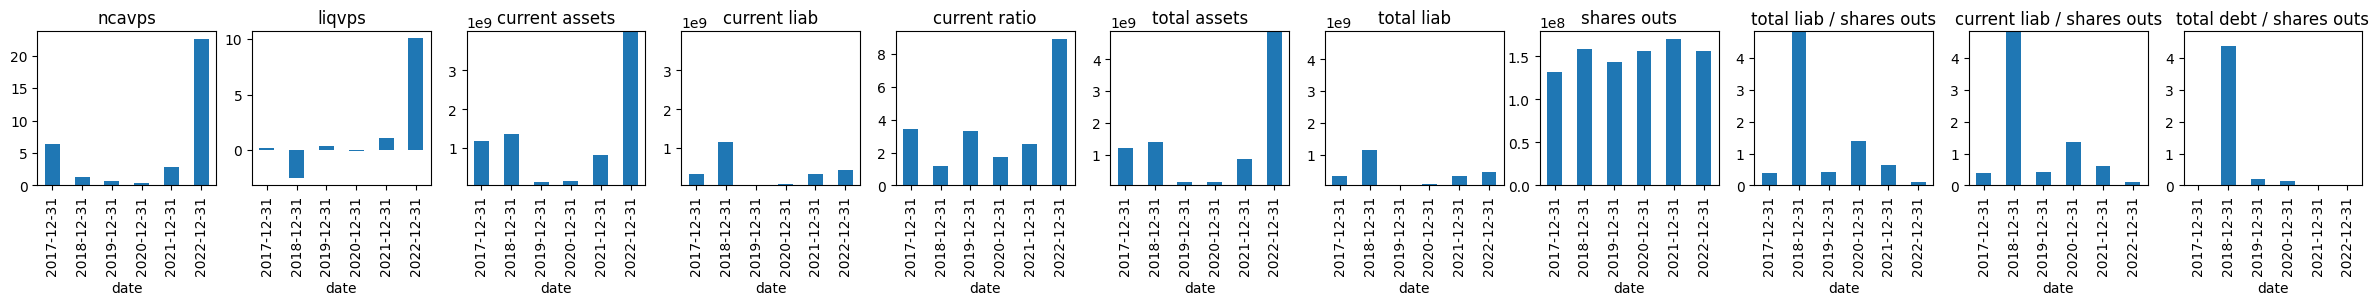

SLRX


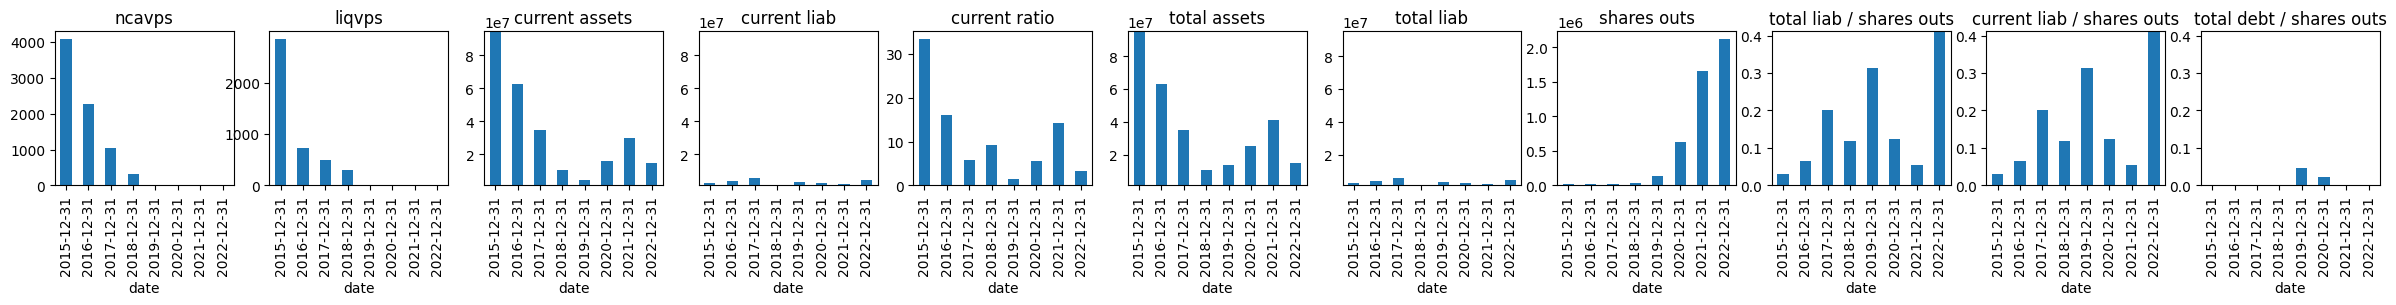

HURC


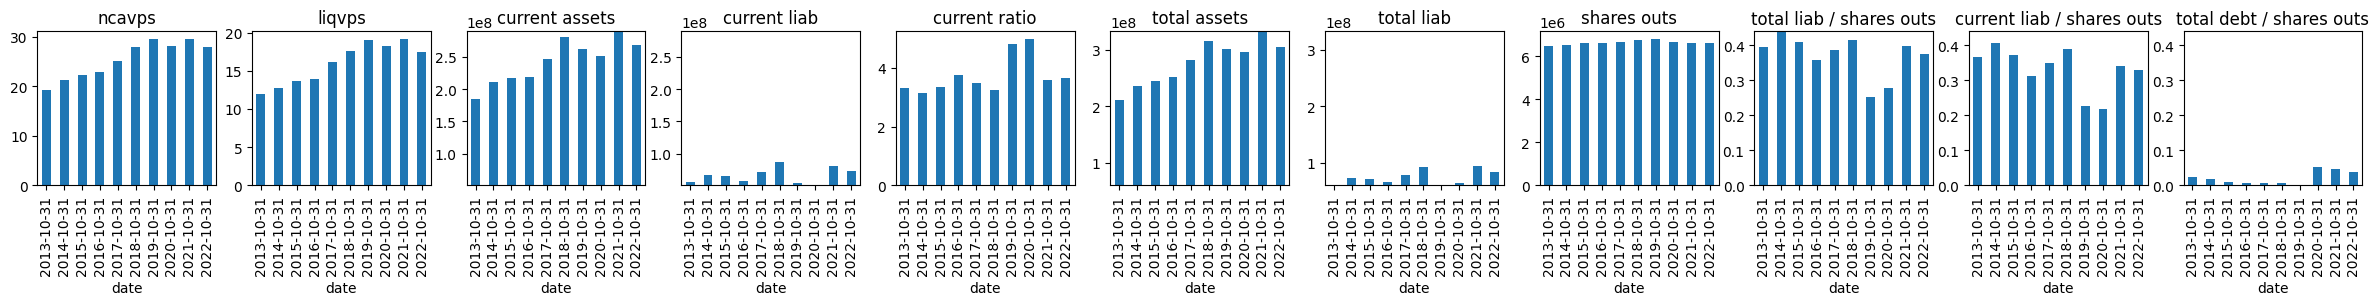

PRCX


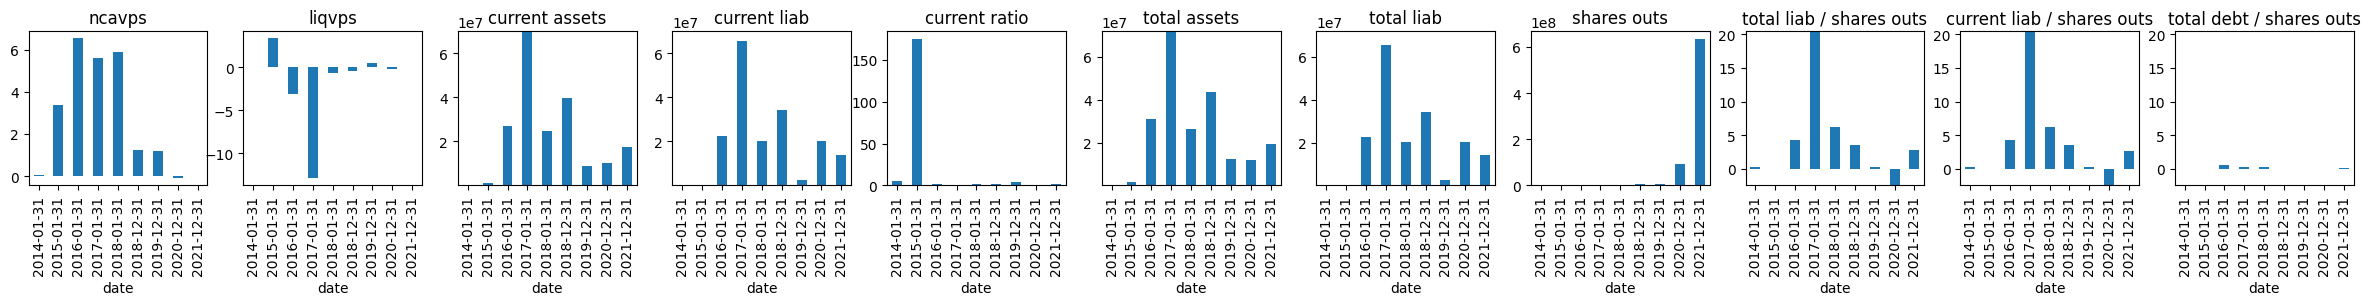

CGA


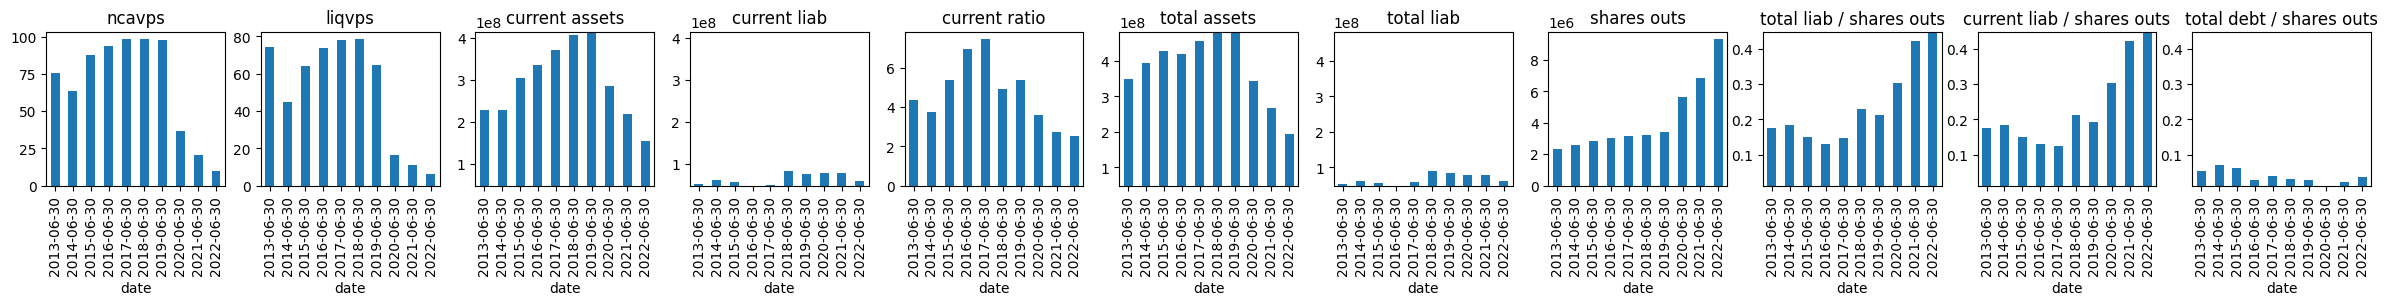

BKYI


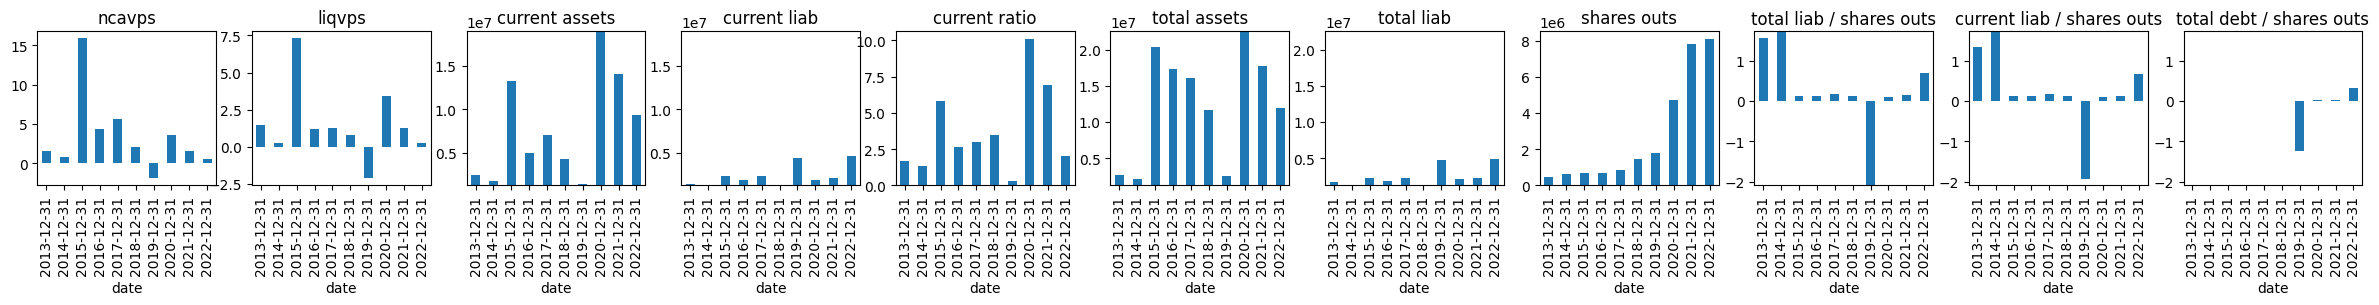

GIFI


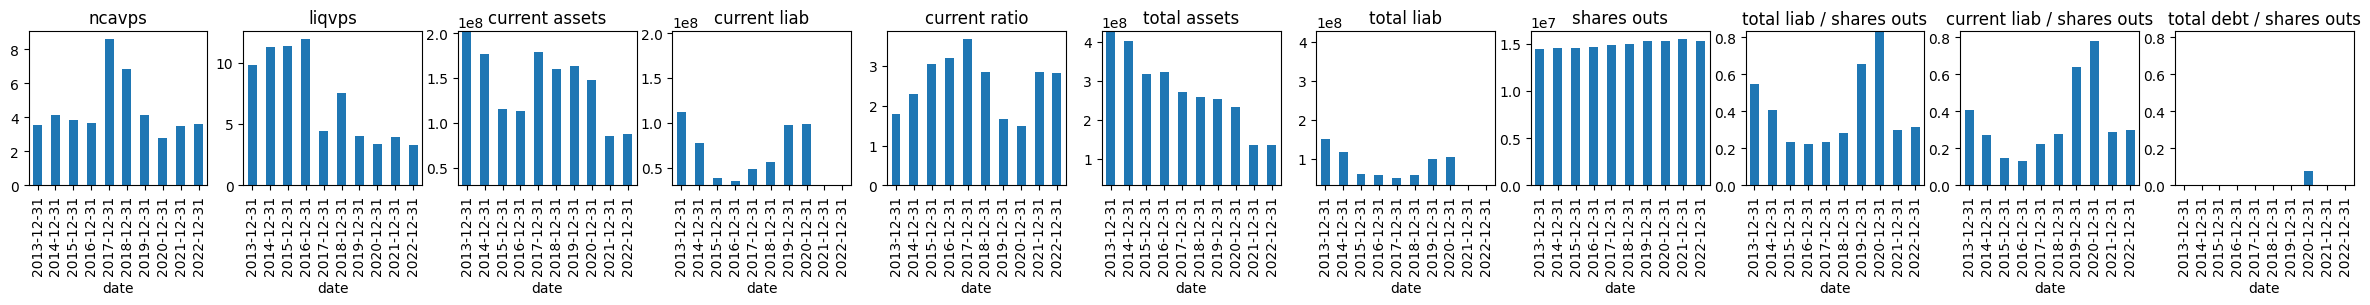

EMKR


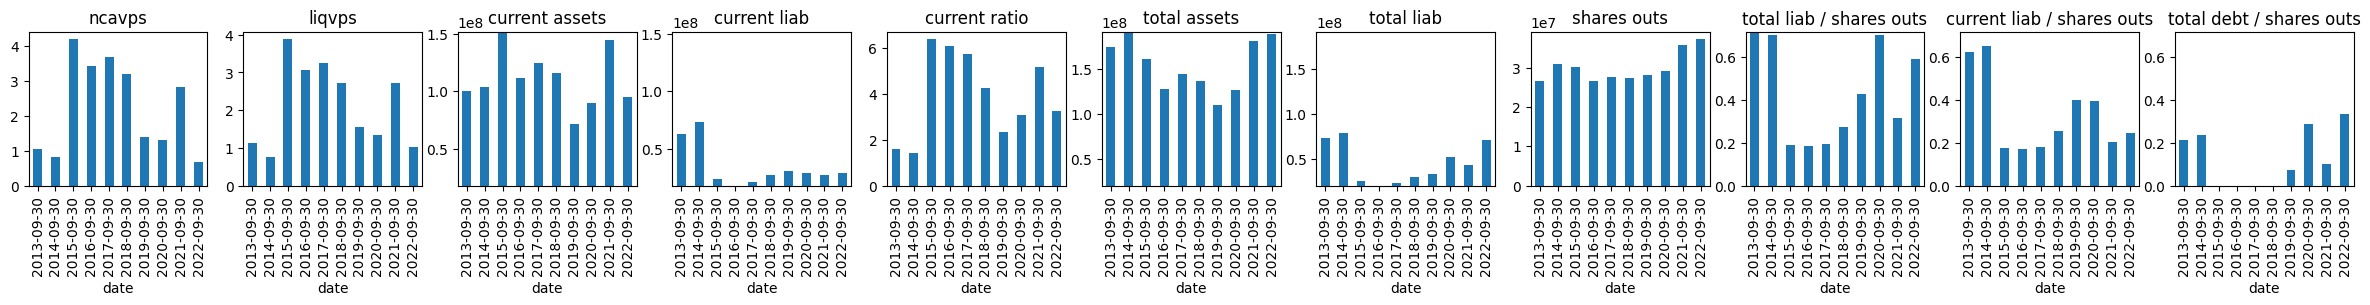

SKAS


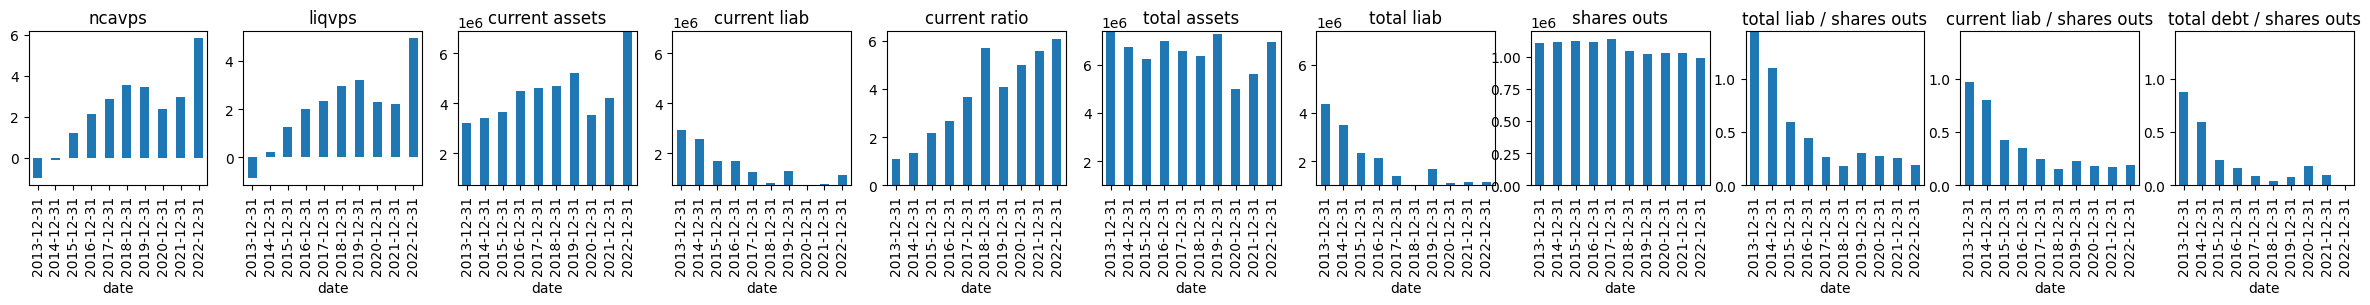

IVAC


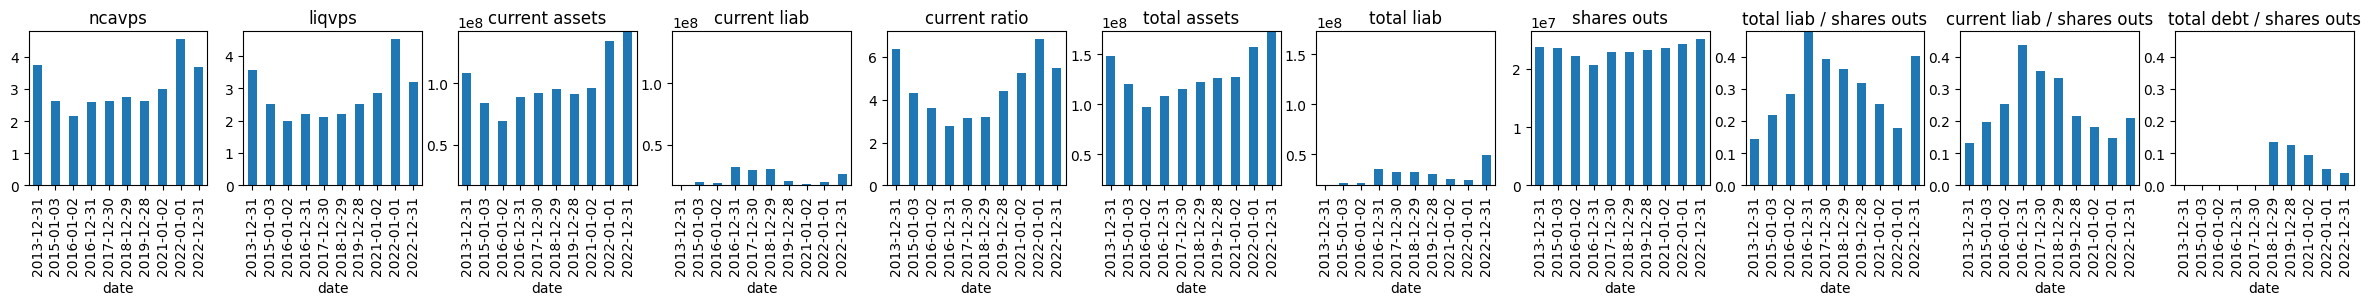

AGAE


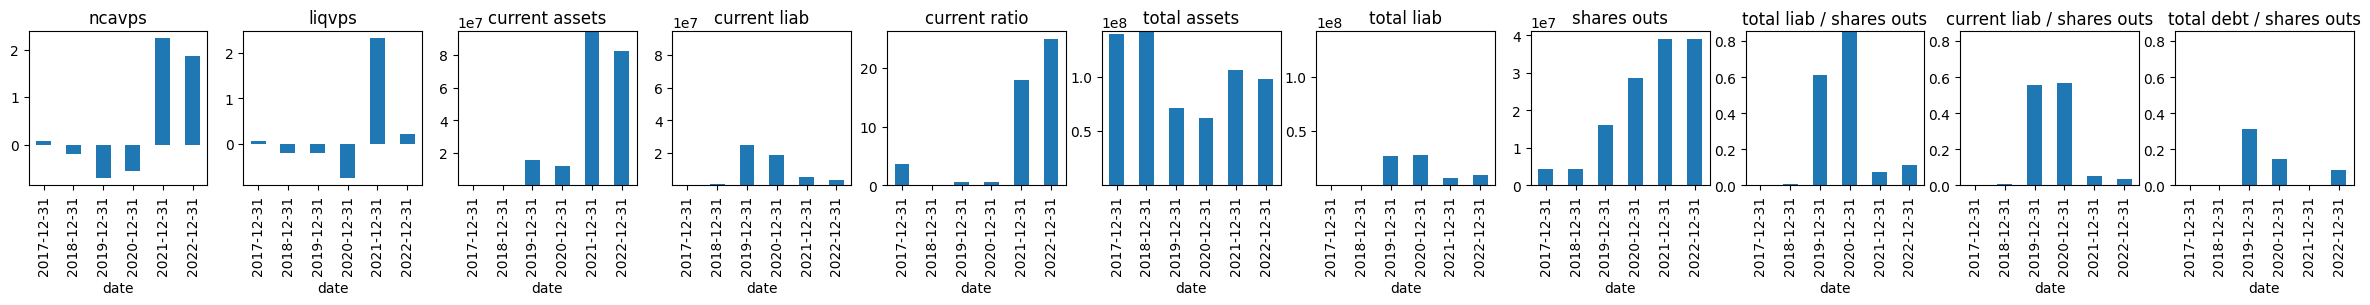

LSF


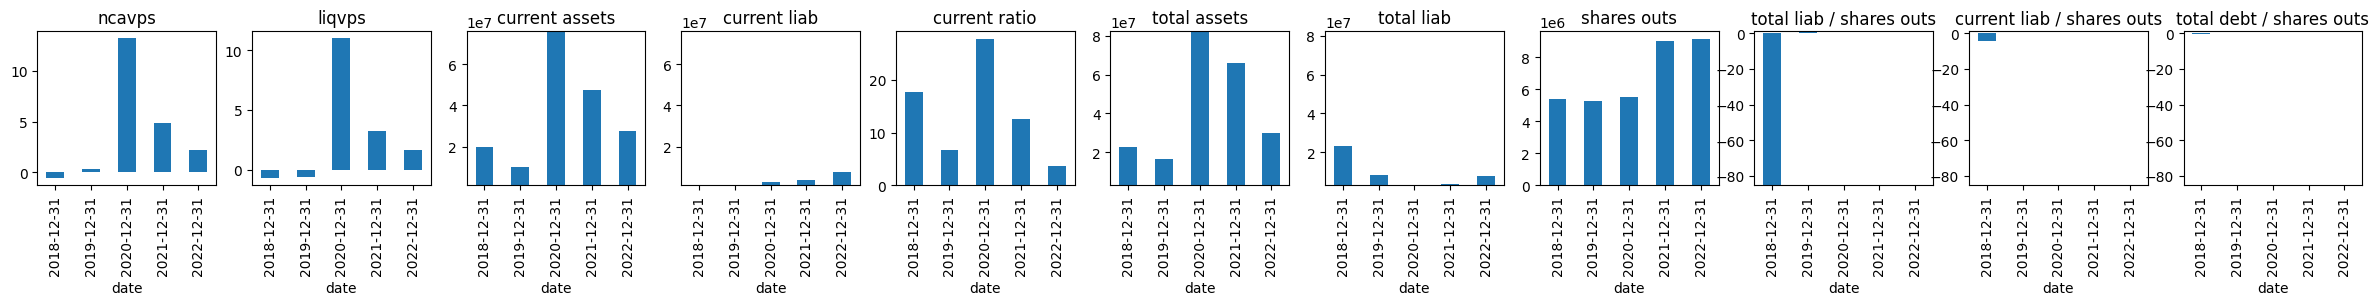

JCTCF


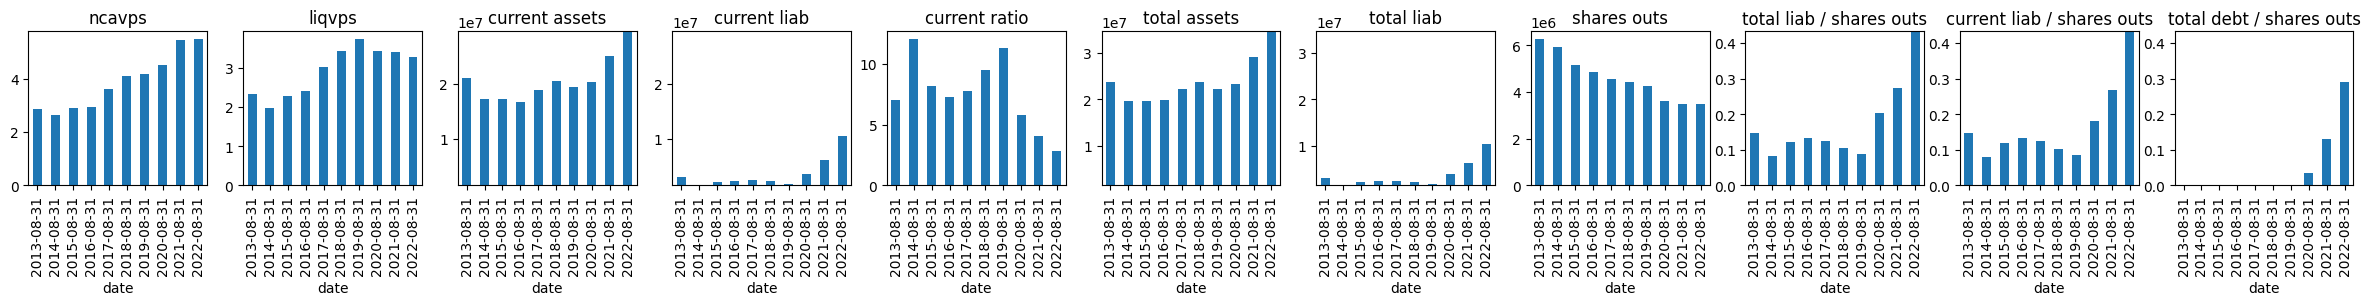

USNU


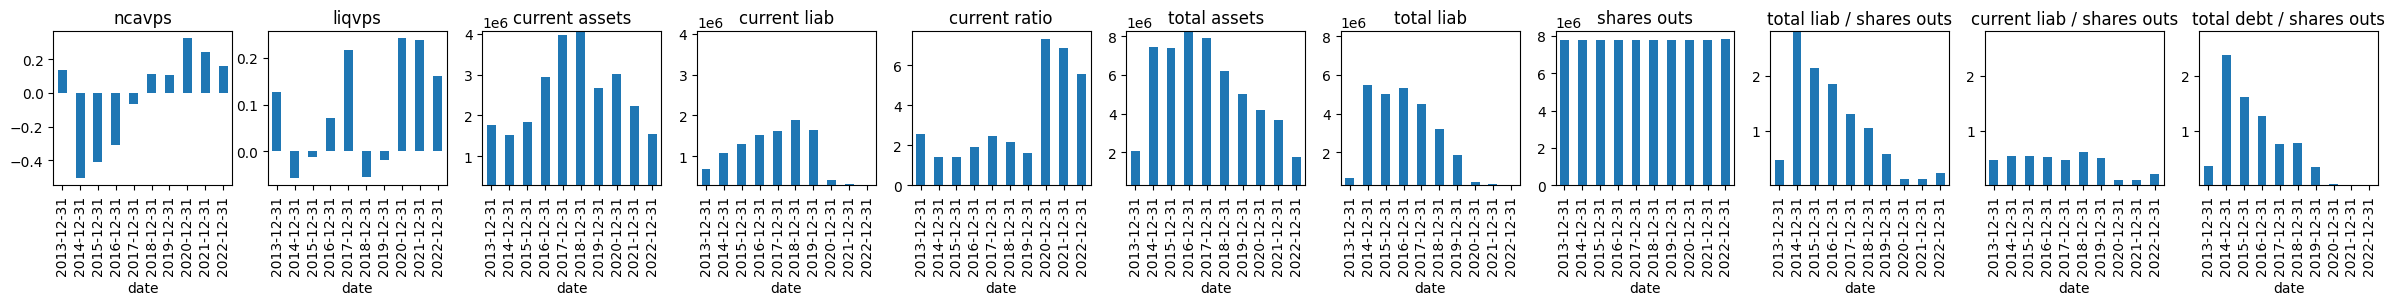

PSNL


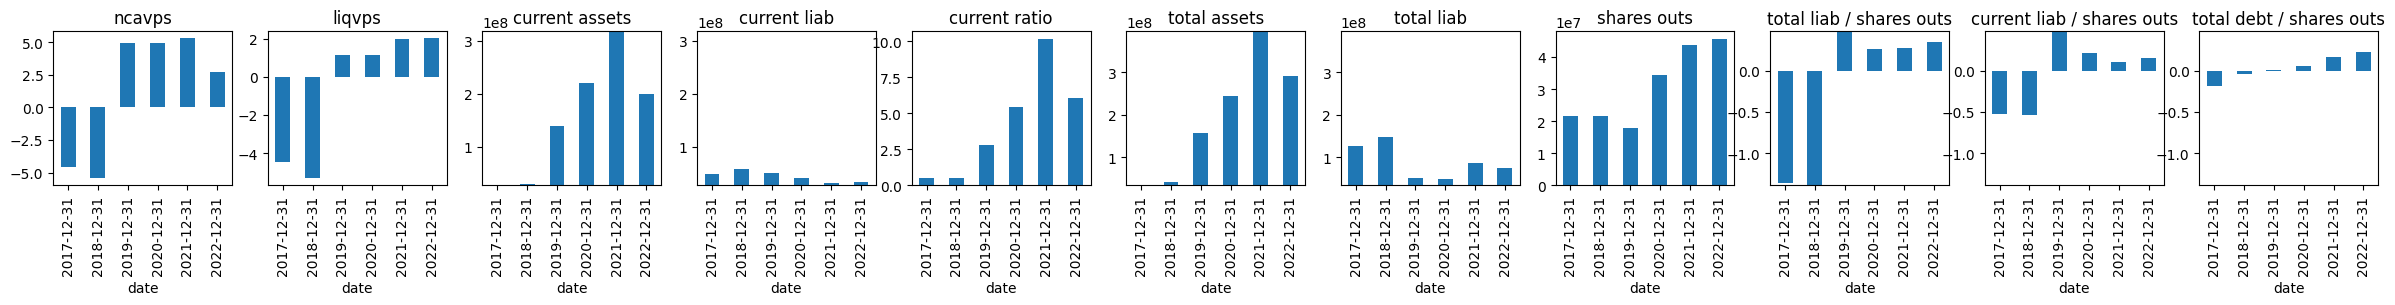

GSMG


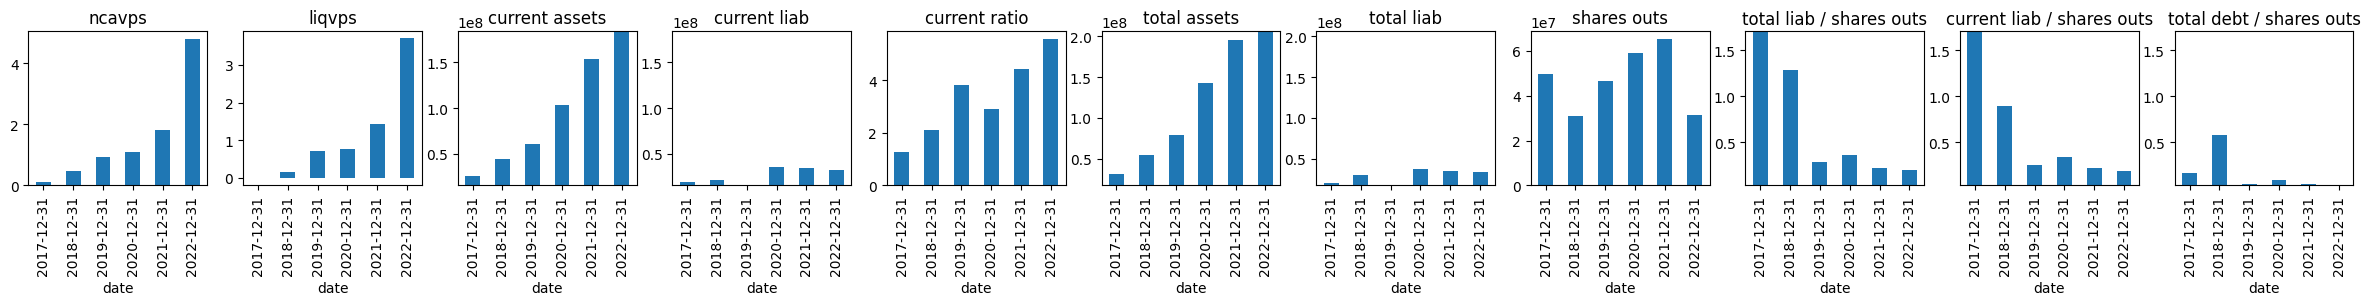

PTE


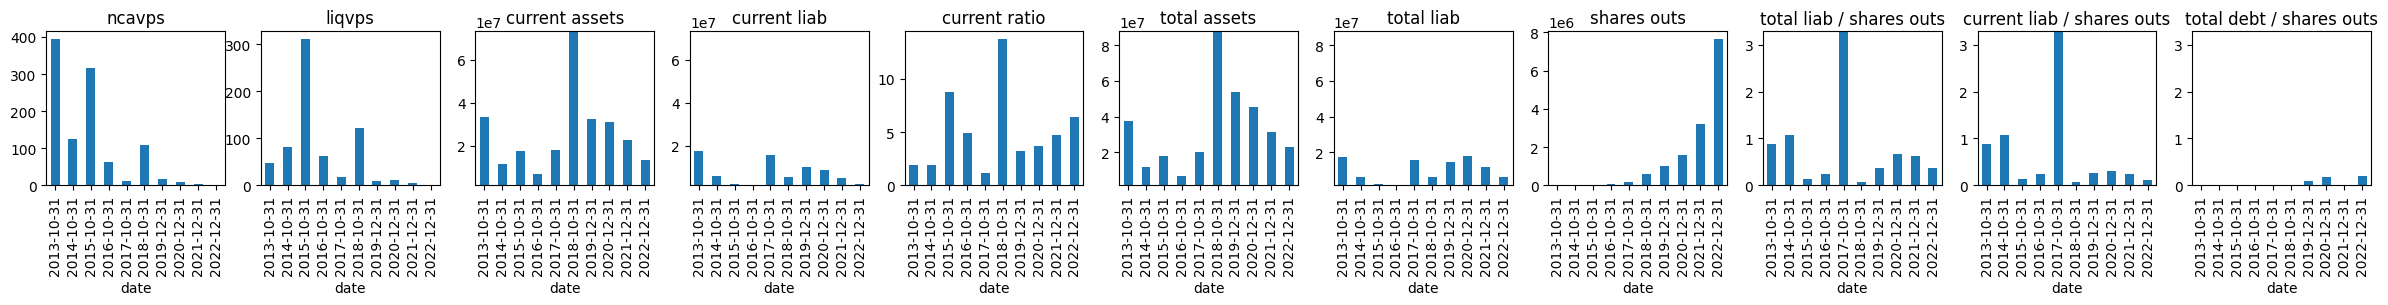

FKWL


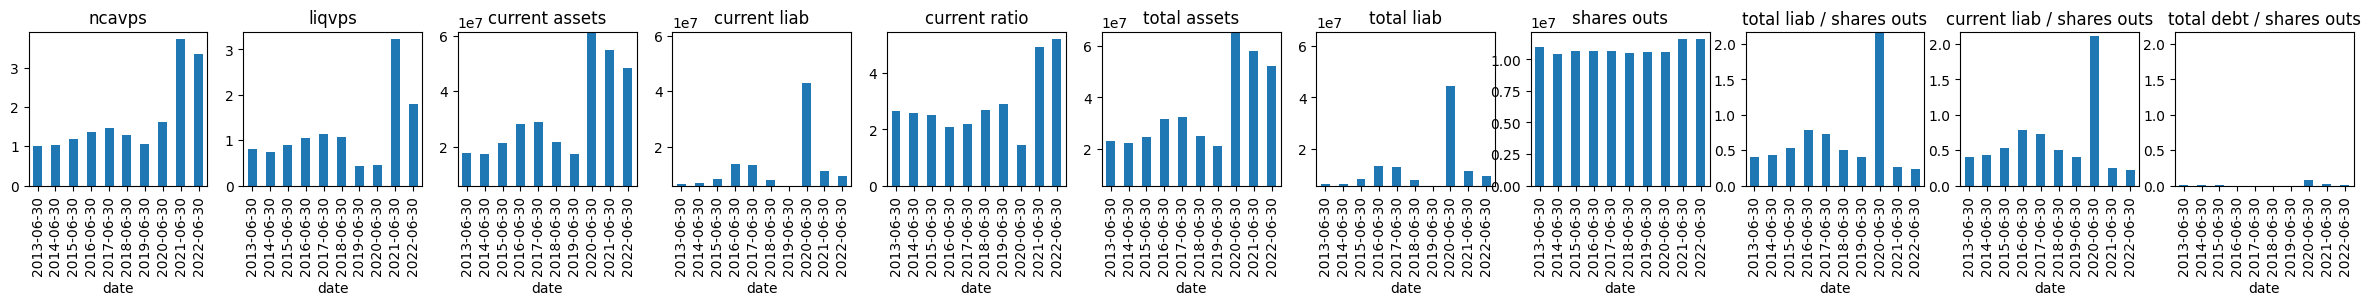

GIGM


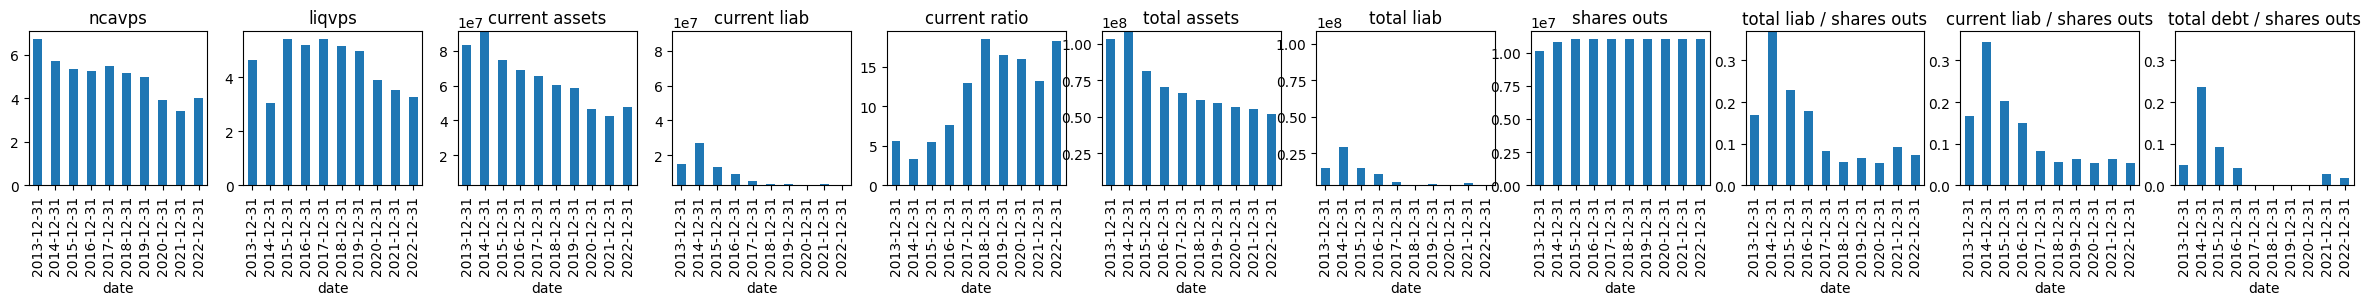

BSQR


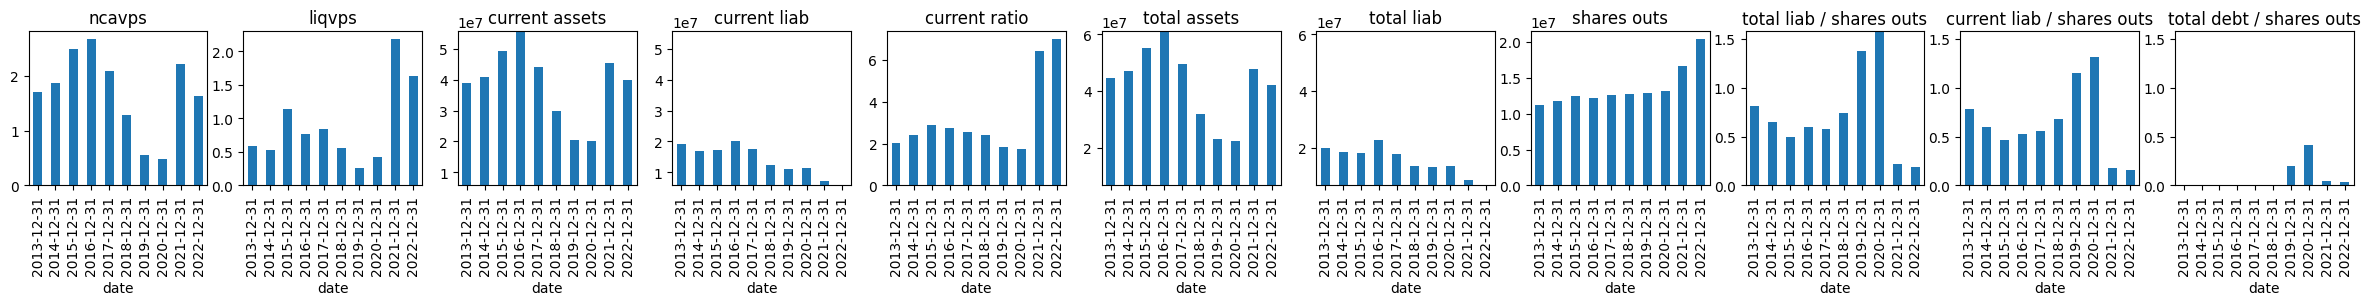

CEAD


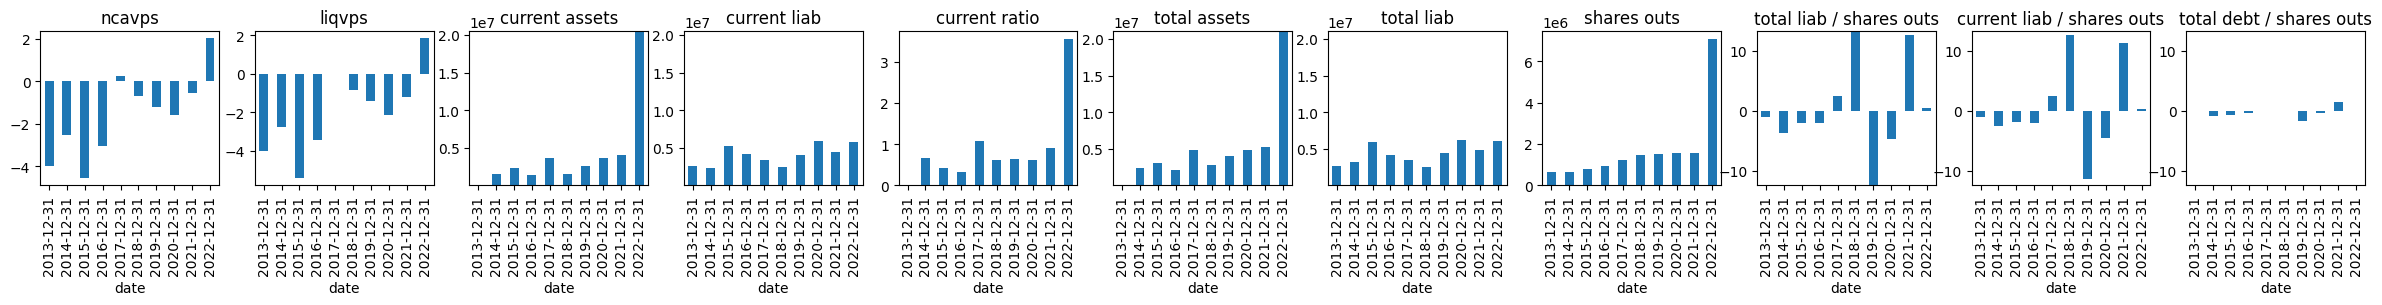

ADES


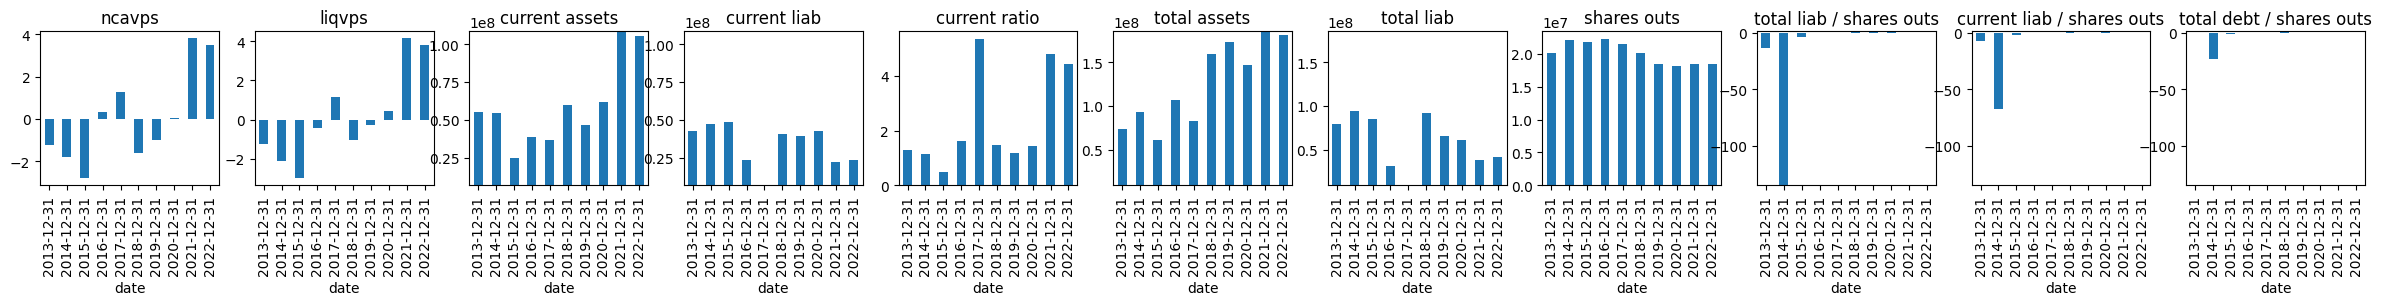

SJ


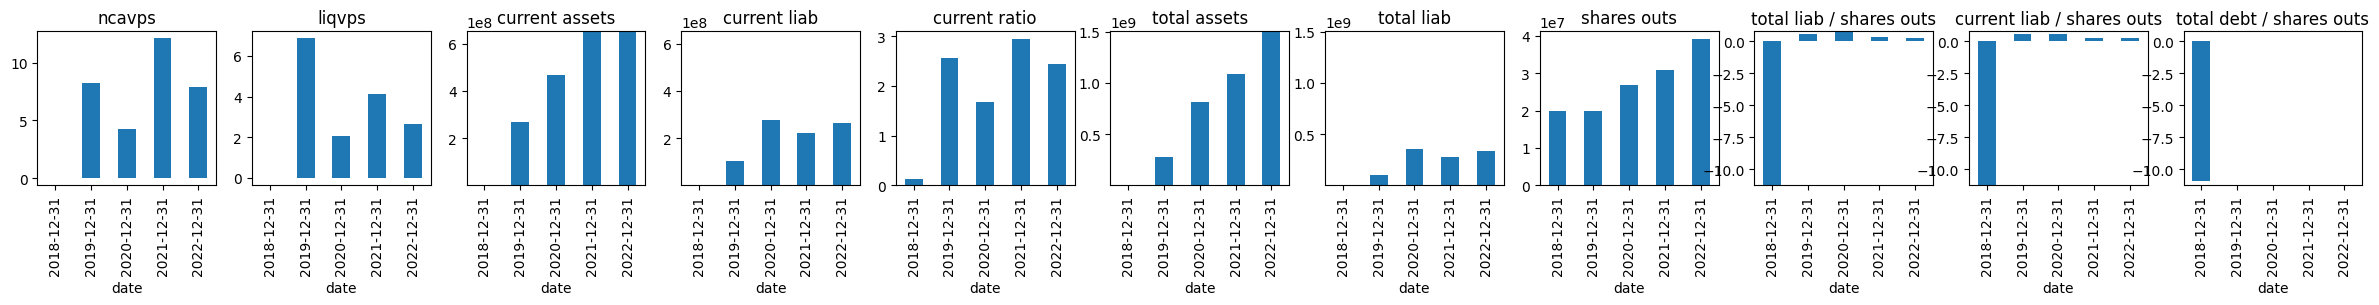

AEY


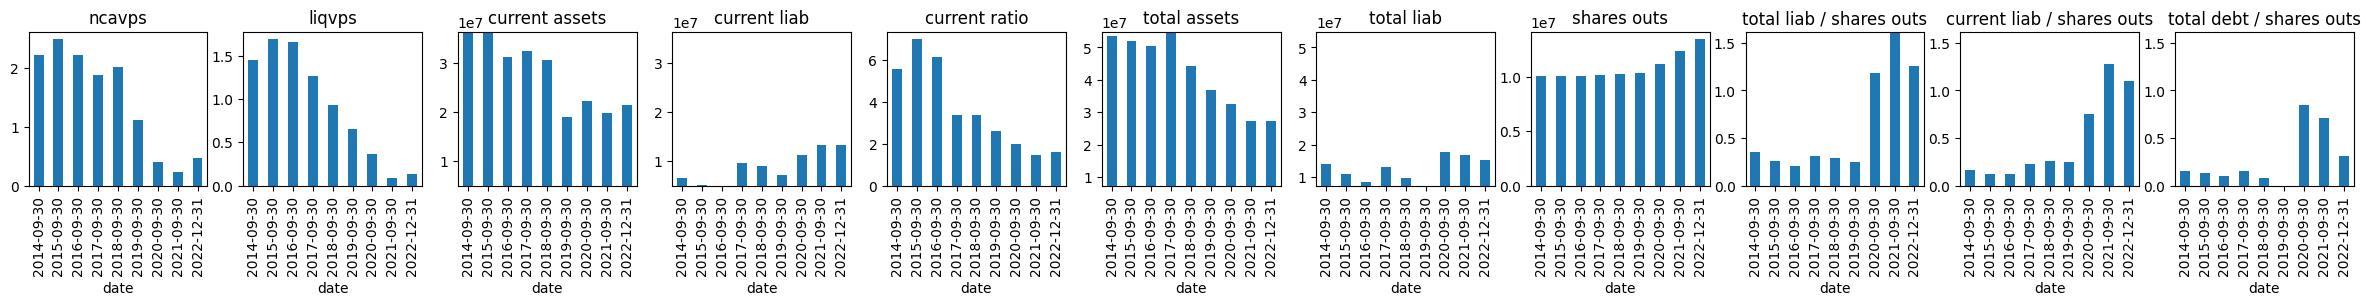

ADD


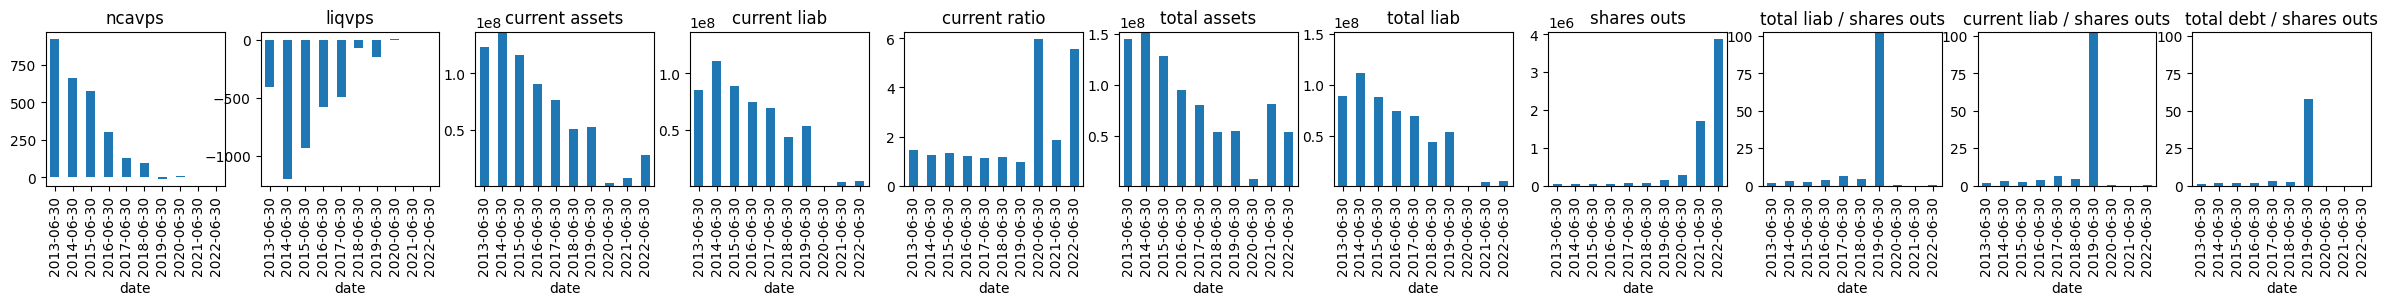

NTWK


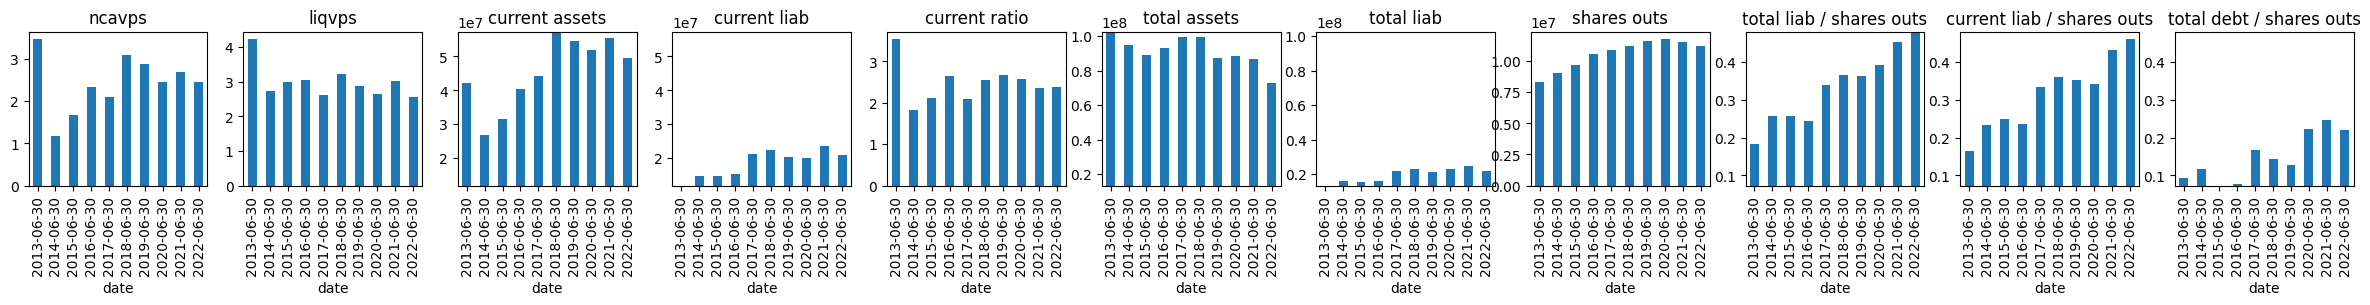

XWEL


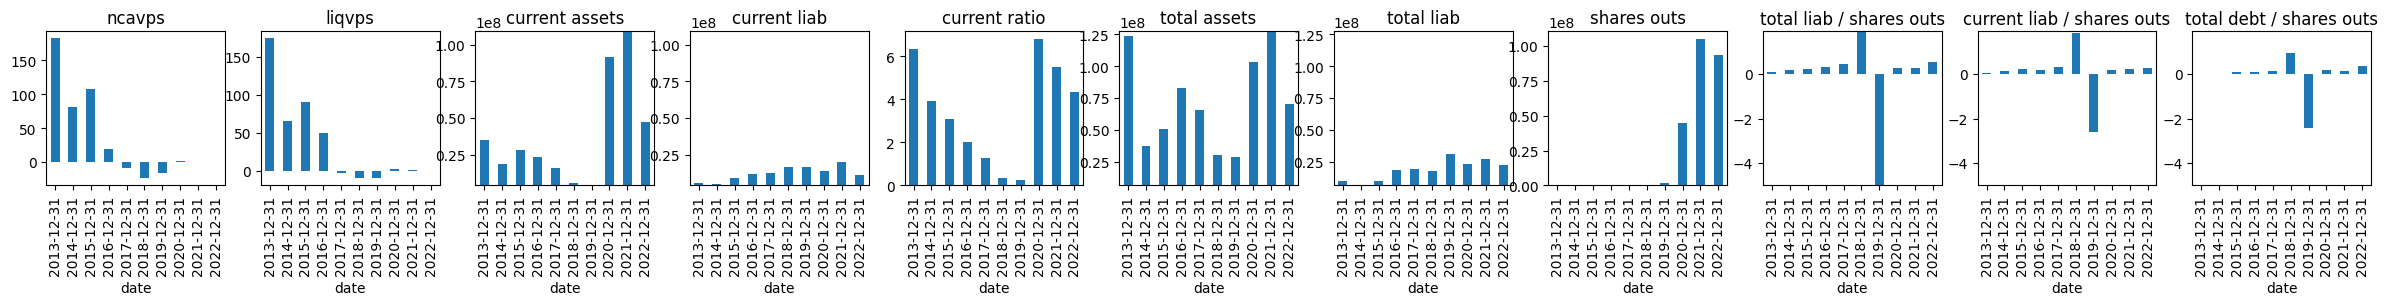

PETZ


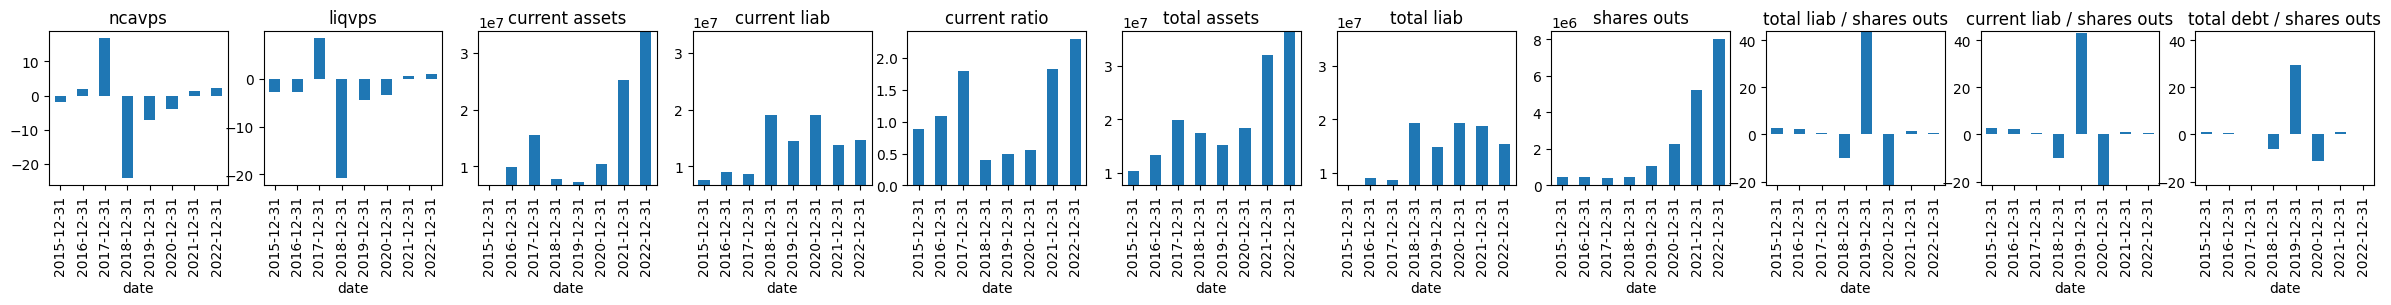

WILC


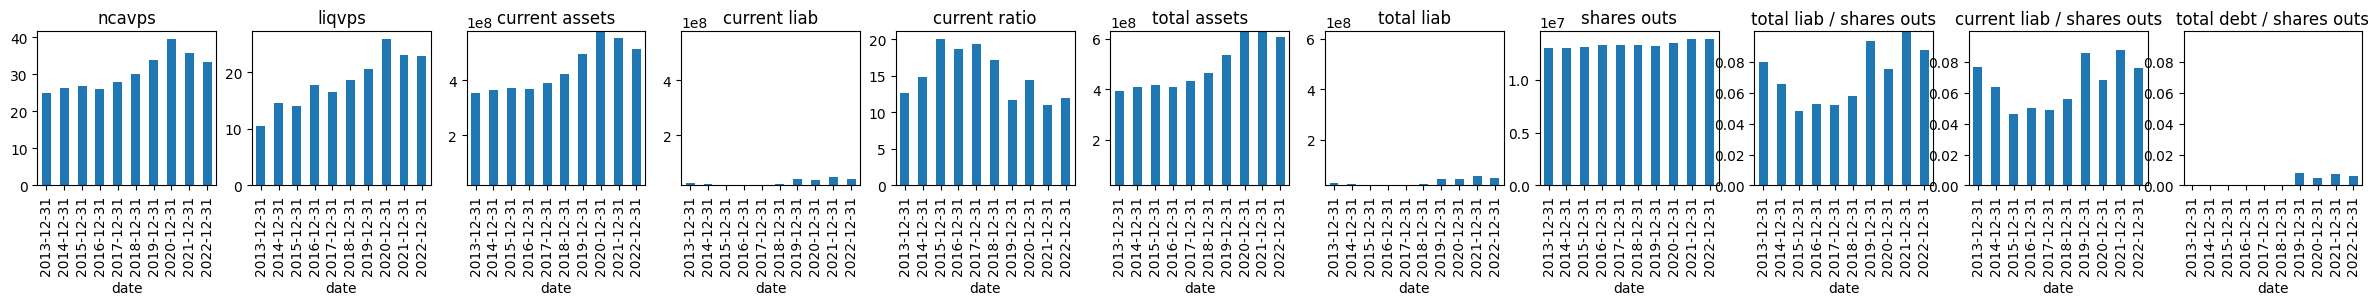

SOLO


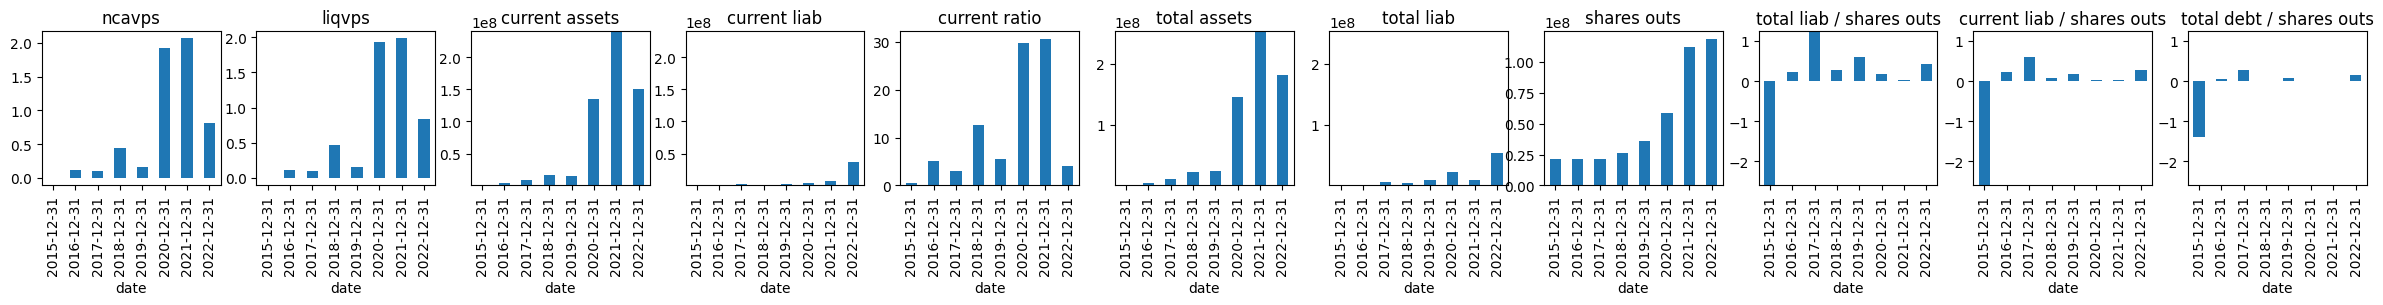

ASRE


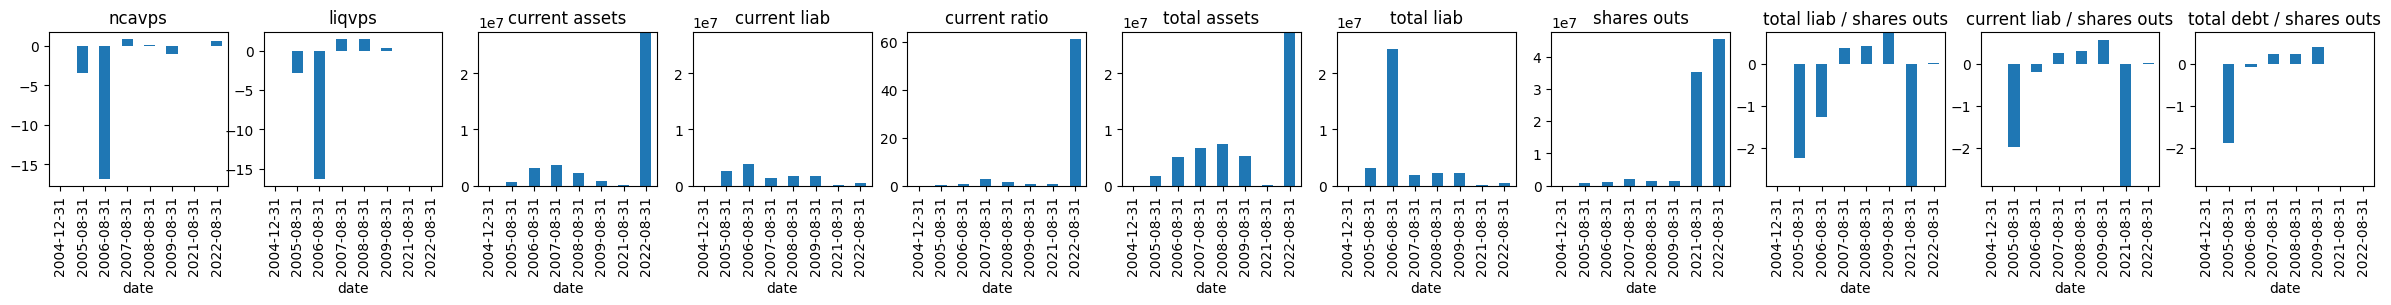

CLRO


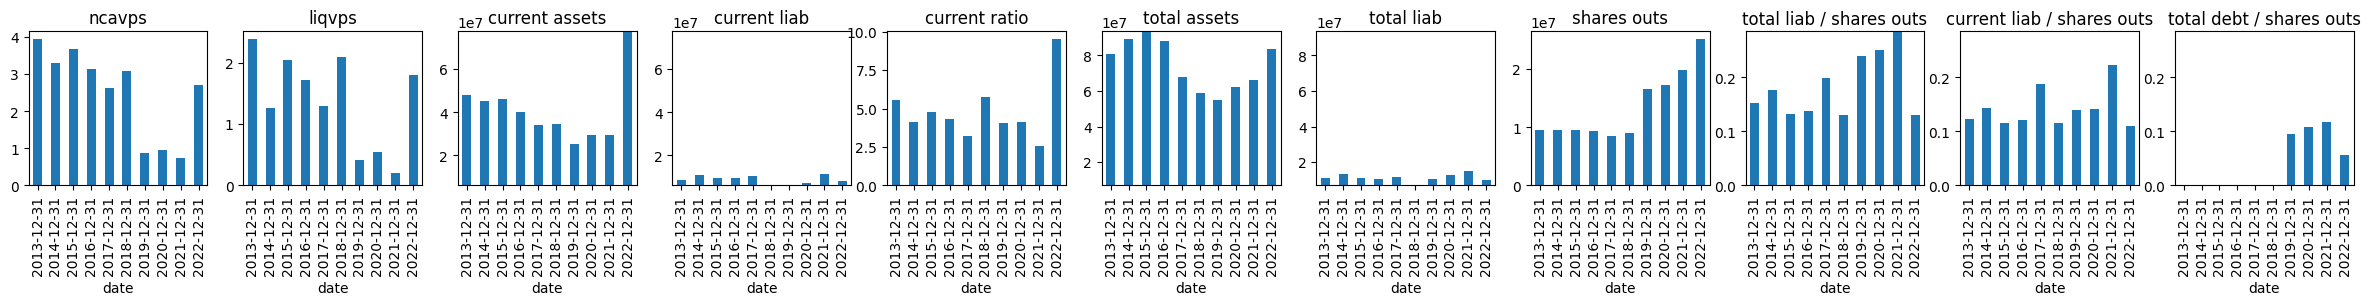

SGLY


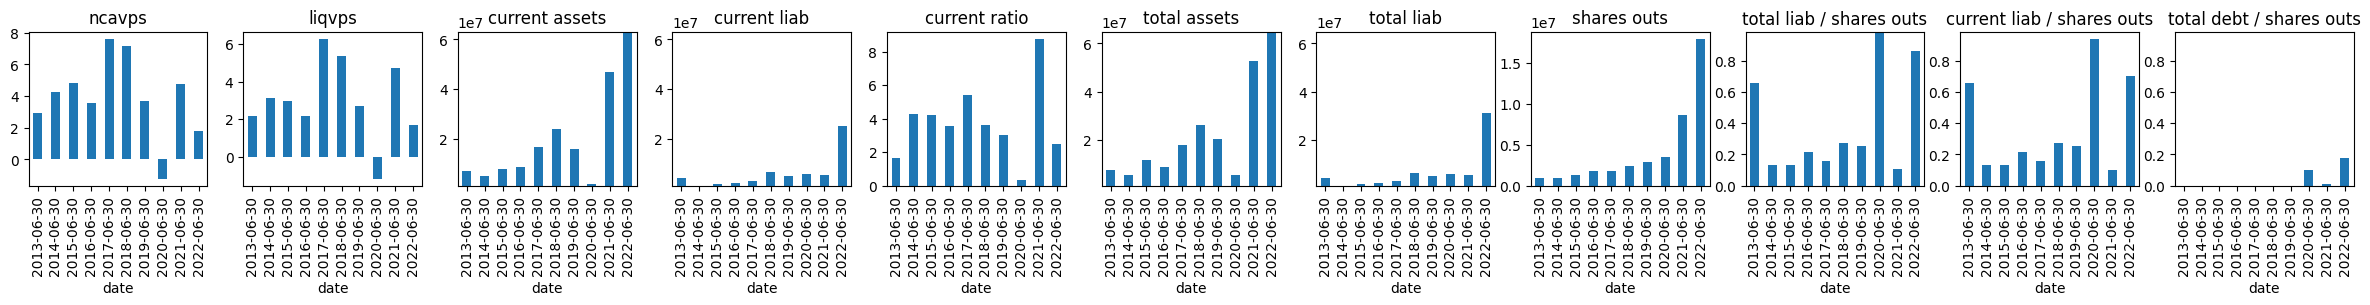

AYRO


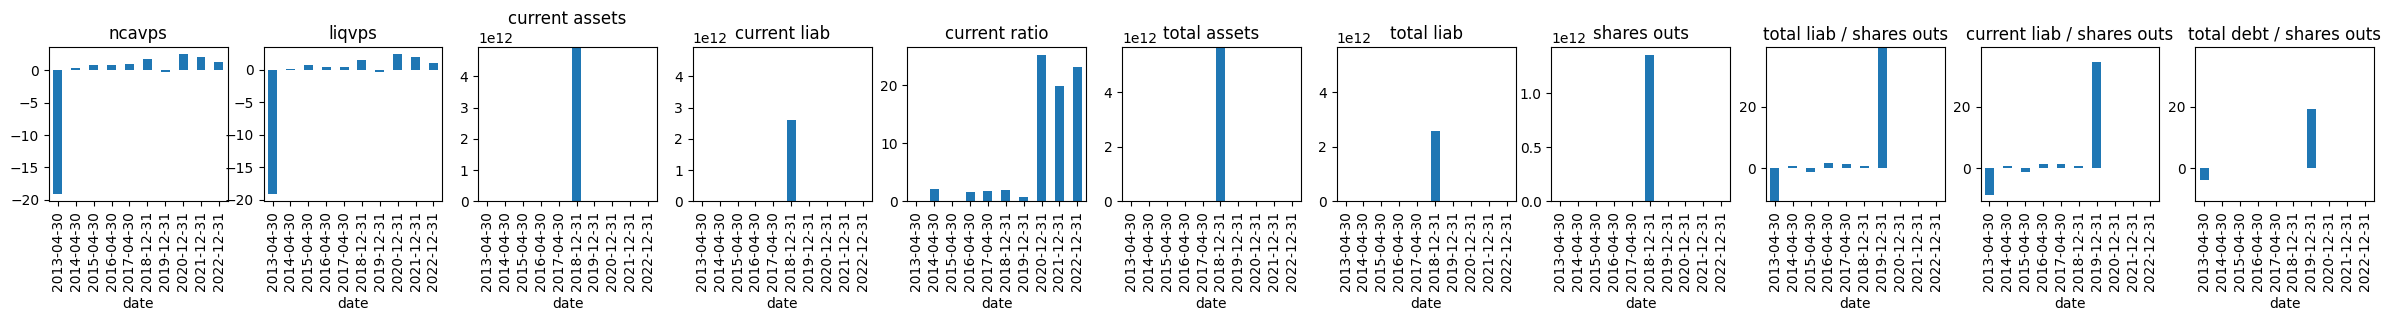

ASTC


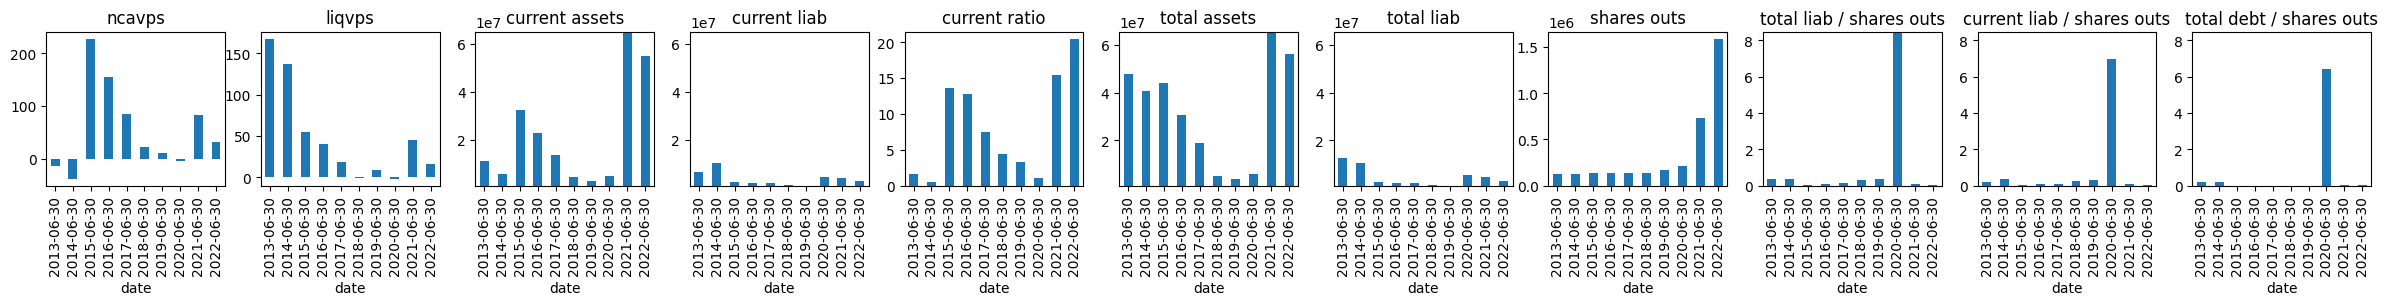

CLPS


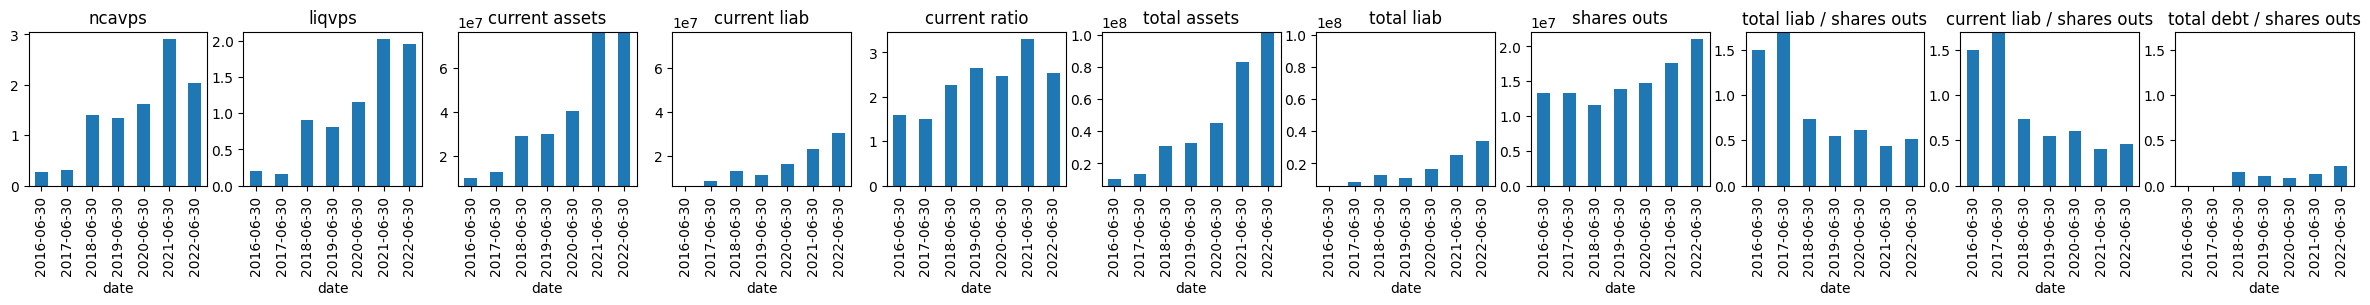

GLBS


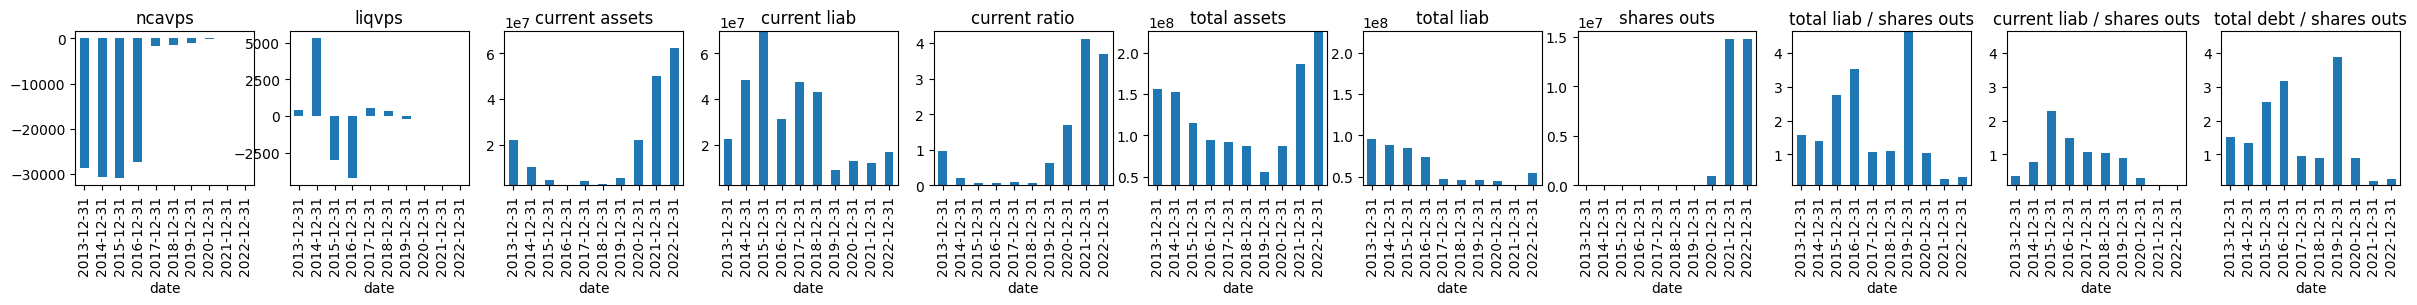

ACB


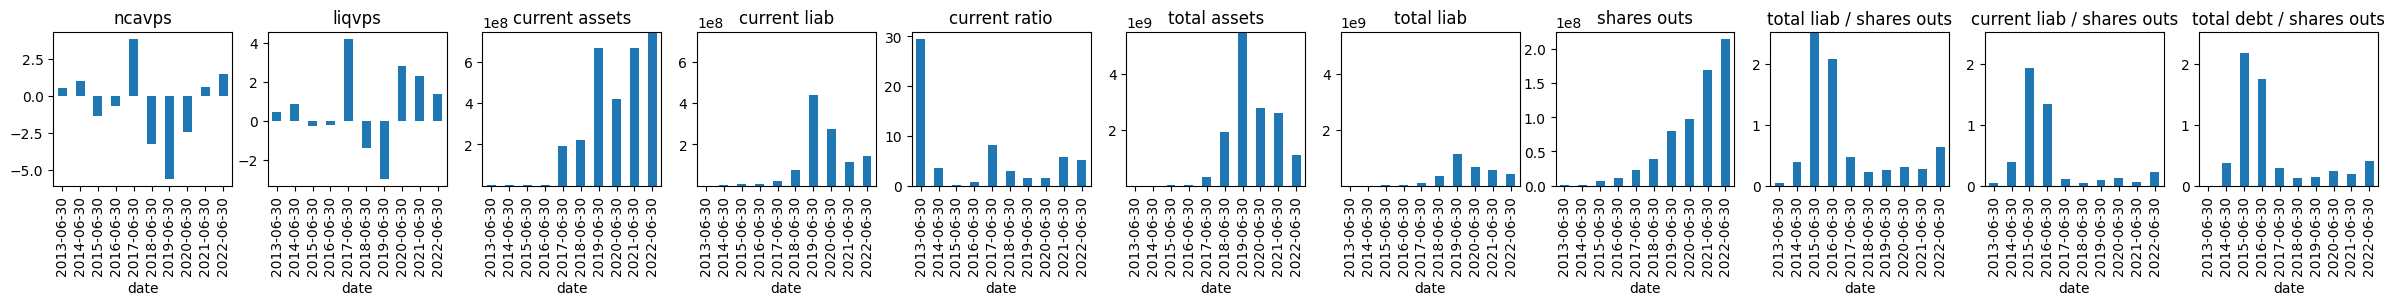

AXTI


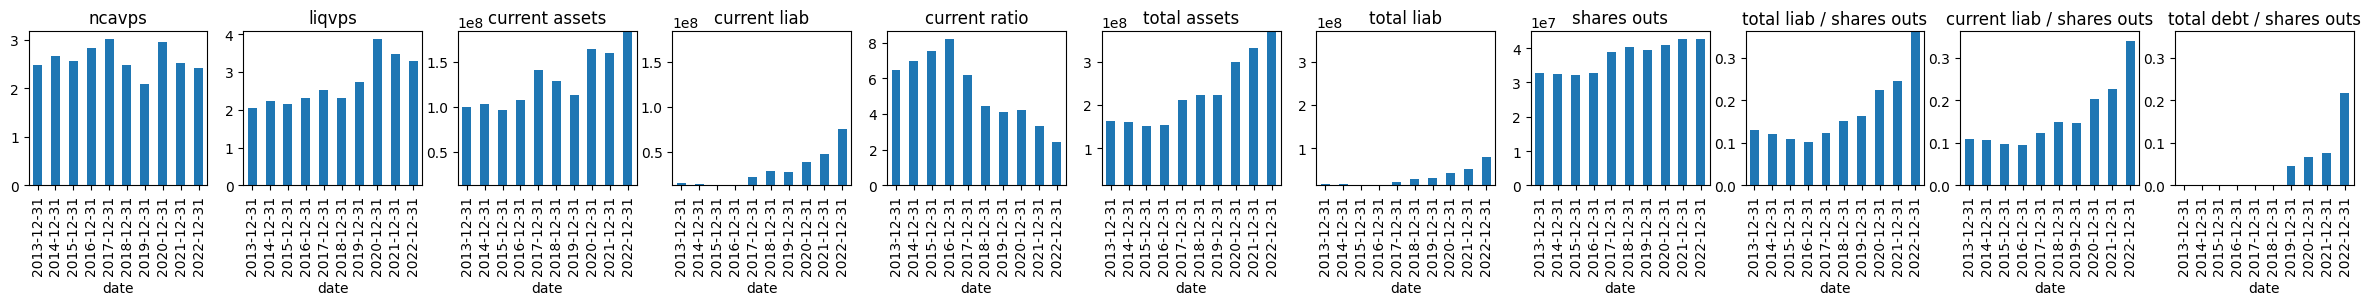

RKDA


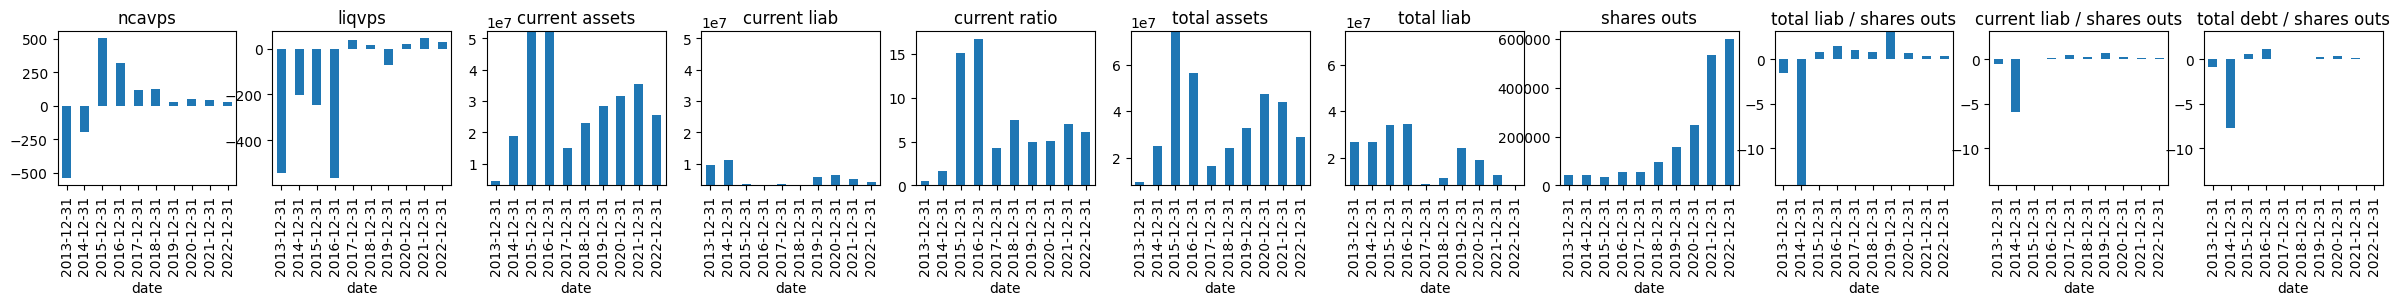

BNSO


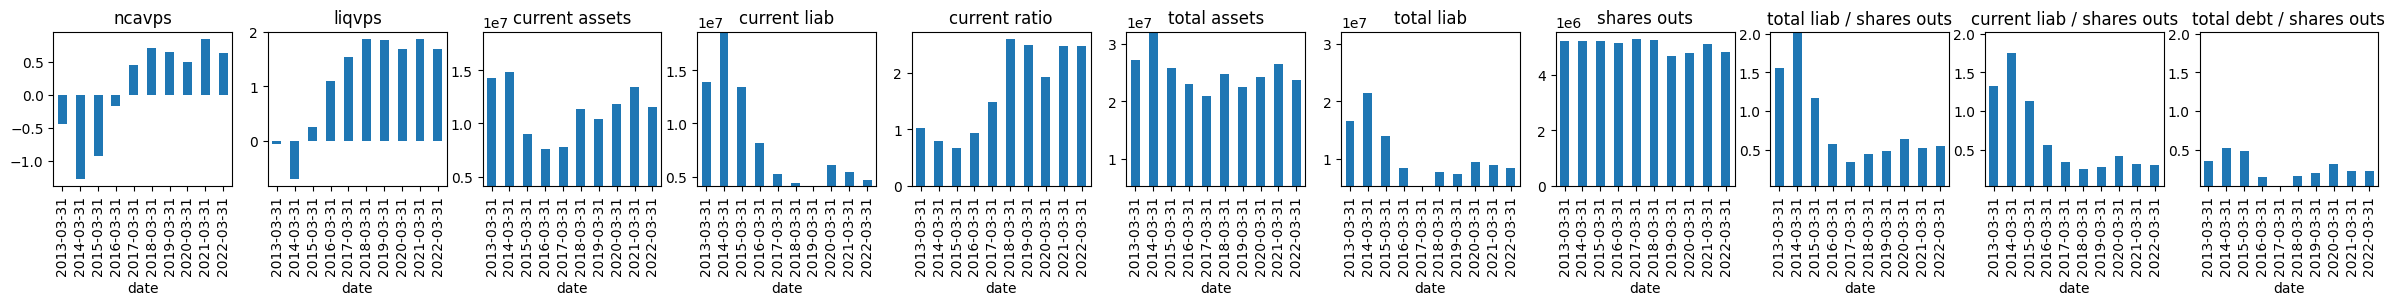

UFI


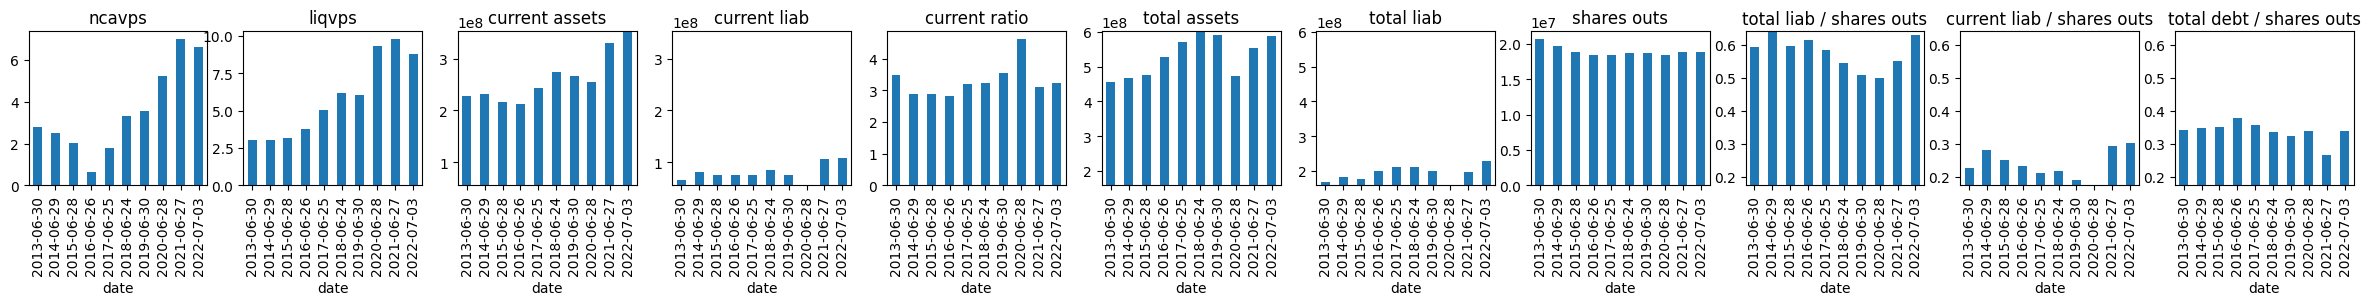

RCON


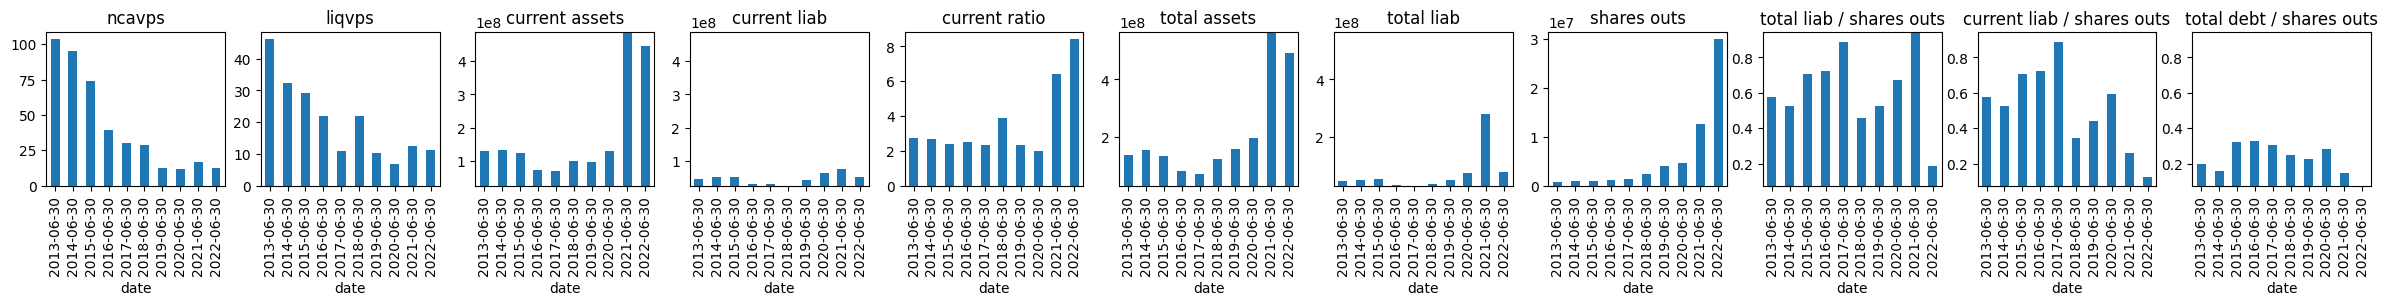

LGL


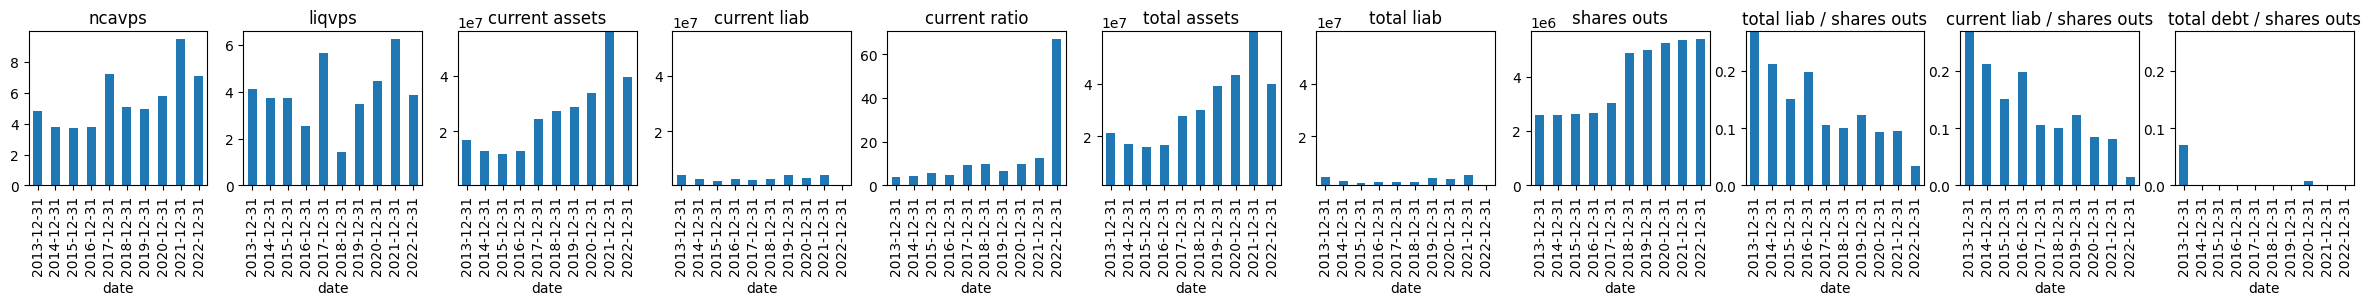

NBY


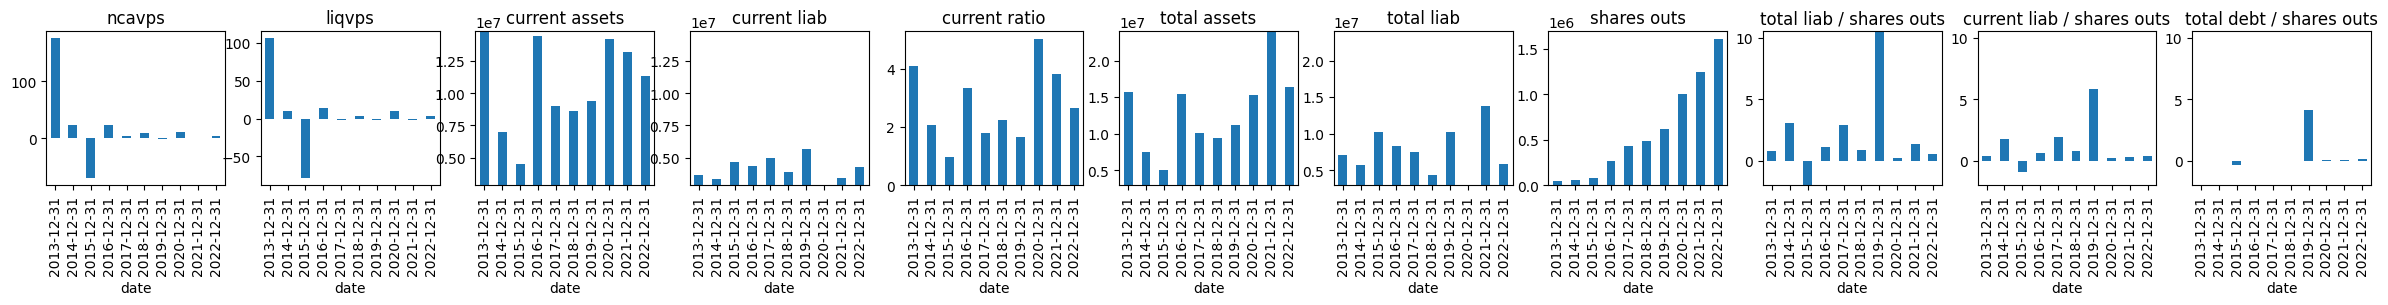

TKAT


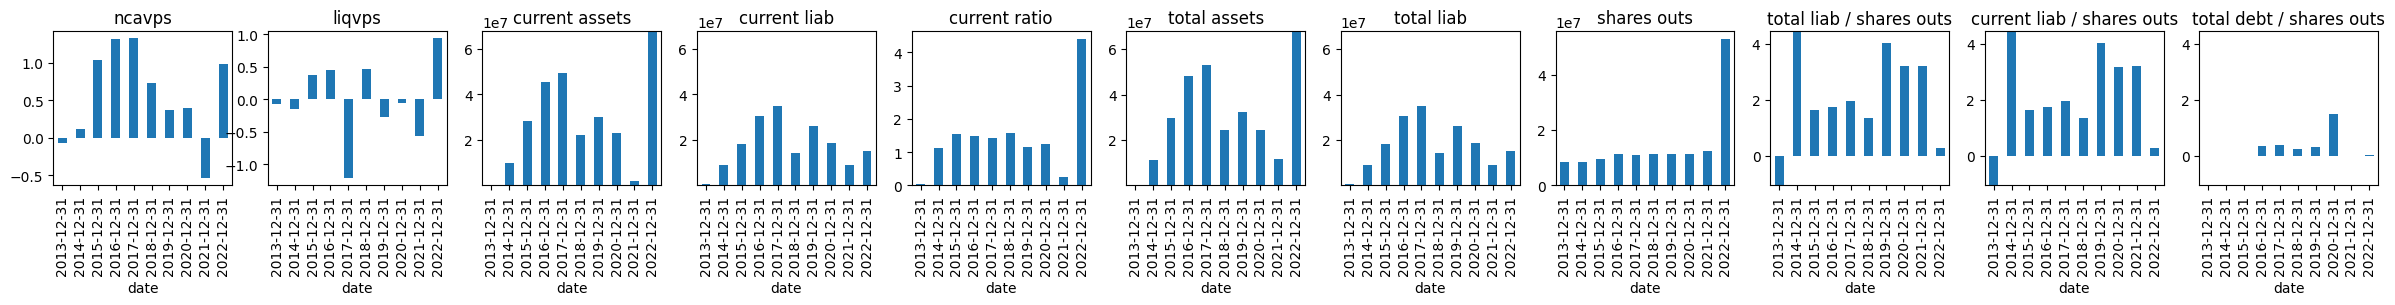

EJH


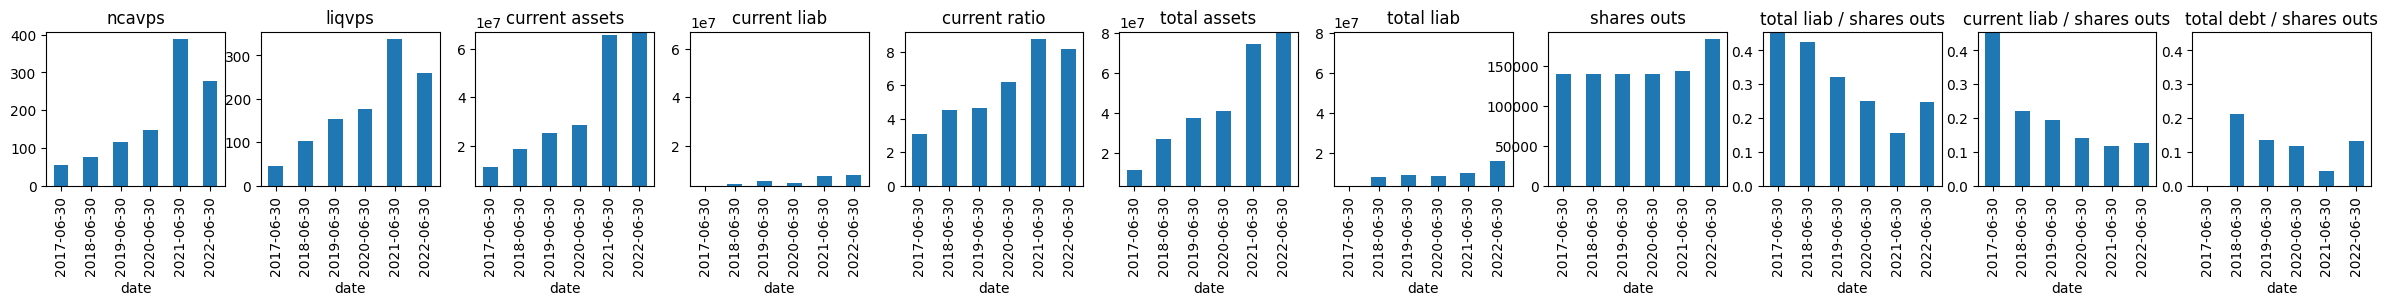

SEV


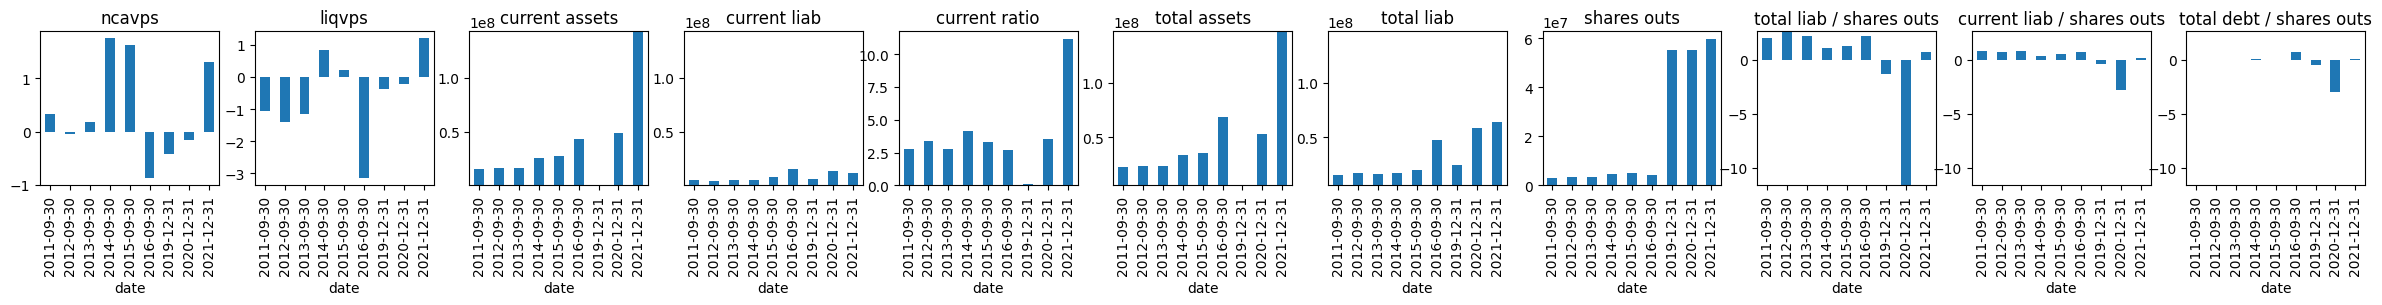

IMTE


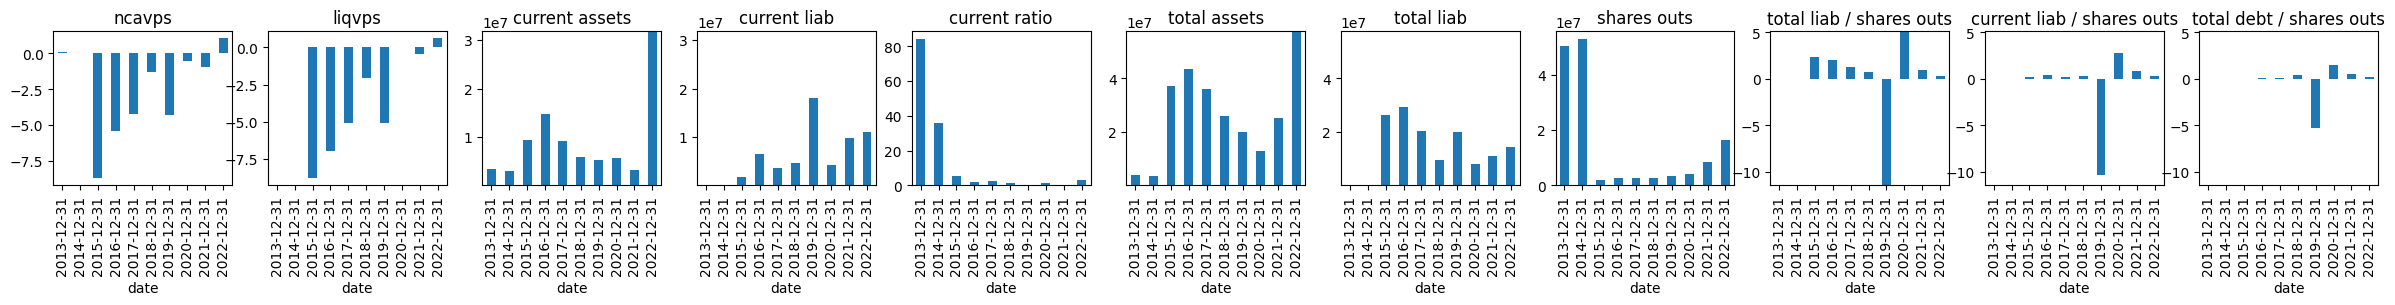

DOGZ


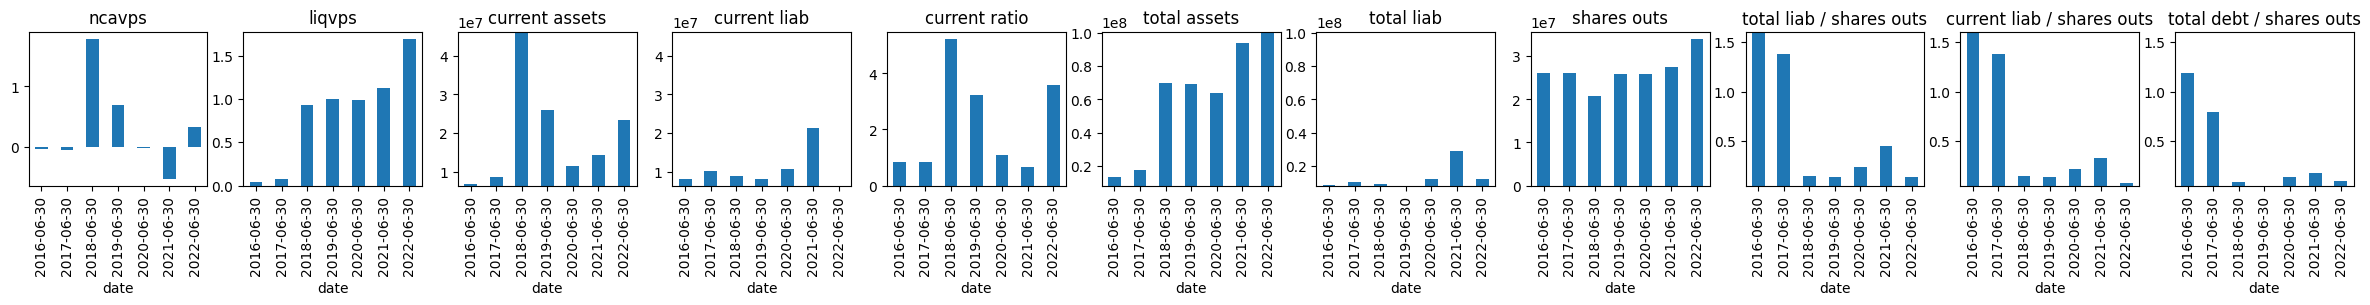

FAMI


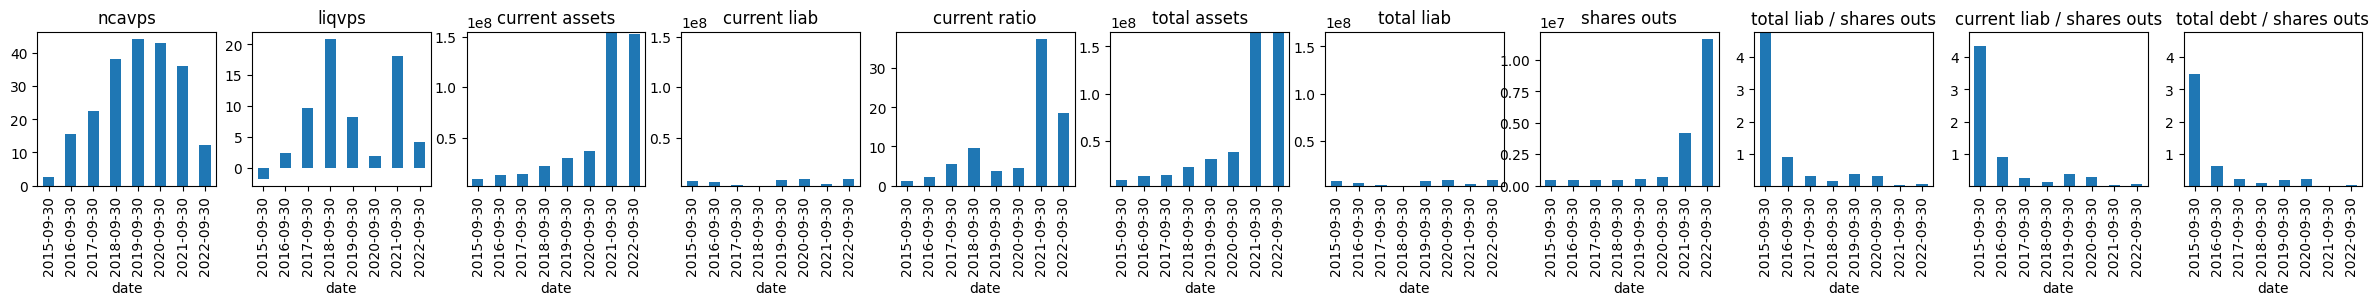

DTEA


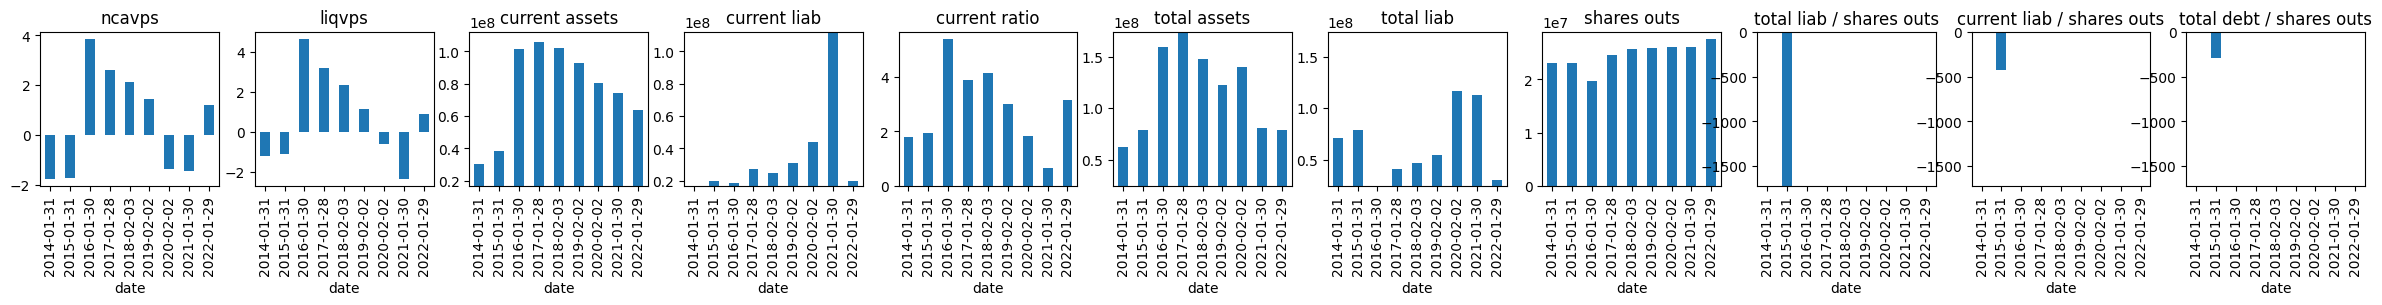

CSTE


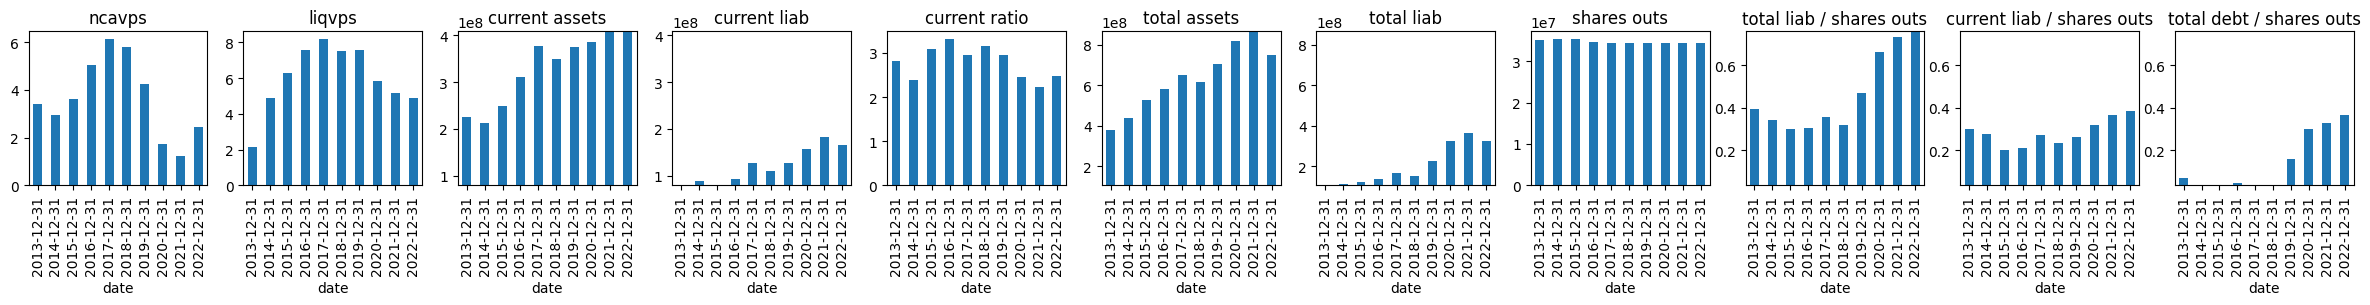

TOFB


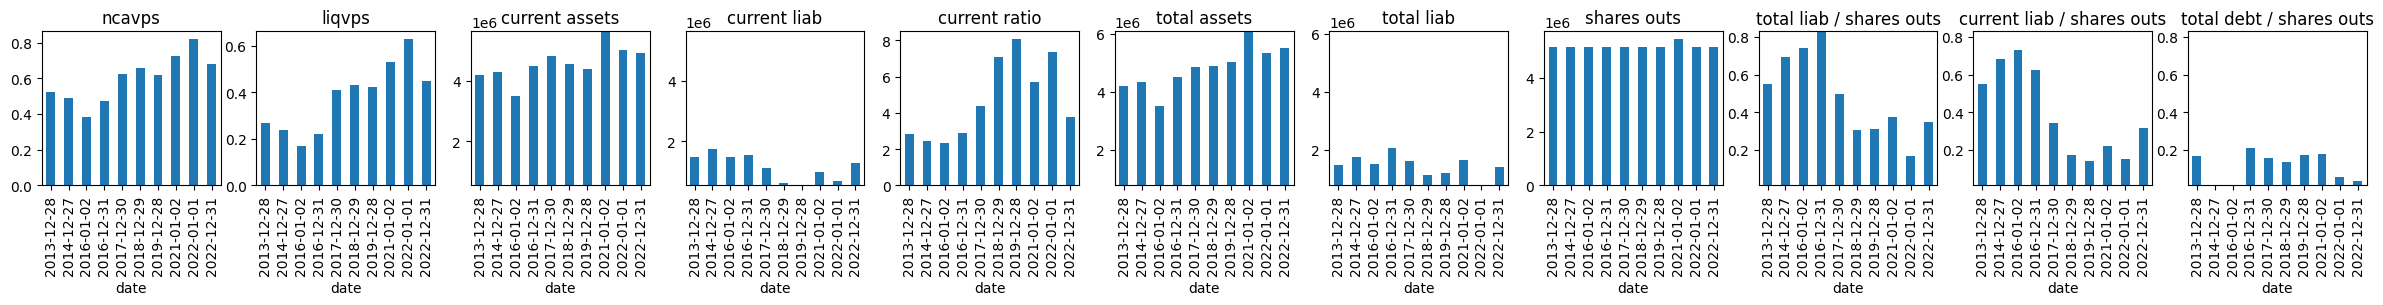

CPU times: user 3min 10s, sys: 7.64 s, total: 3min 18s
Wall time: 7min 25s


In [13]:
%%time
missed_tickers = []
full_df = pd.DataFrame()
for ticker in selected_tickers:
    # define urls
    url_balance_sheet = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?limit=10&apikey={KEY}"
    url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=10&apikey={KEY}"

    try:
        # load data
        response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
        response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
    except:
        missed_tickers.append(ticker)
        
    data_balance_sheet = response_balance_sheet.read().decode("utf-8")
    data_balance_sheet = json.loads(data_balance_sheet)
    if len(data_balance_sheet) < 5:
        continue

    data_income_stmt = response_income_stmt.read().decode("utf-8")
    data_income_stmt = json.loads(data_income_stmt)
    if len(data_income_stmt) < 5:
        continue
        
    balance_sheet_df = pd.DataFrame(data_balance_sheet)
    income_stmt_df = pd.DataFrame(data_income_stmt)
    balance_sheet_df = balance_sheet_df.set_index("date")
    income_stmt_df = income_stmt_df.set_index("date")
    balance_sheet_df = balance_sheet_df[bs_cols]
    income_stmt_df = income_stmt_df[is_cols]

    fs_df = pd.concat([balance_sheet_df, income_stmt_df], axis=1, join="inner")
    fs_df = fs_df.iloc[::-1] # from oldest to newest
    # compute NCAV
    fs_df["ncavps"] = fs_df.apply(compute_ncavps, axis=1)
    # compute LIQV
    fs_df["liqvps"] = fs_df.apply(compute_liqvps, args=(factors,), axis=1)
    # compute current ratio
    fs_df["current_ratio"] = fs_df.apply(compute_current_ratio, axis=1)
    # compute de ratio 1
    fs_df["de_ratio1"] = fs_df.apply(compute_de_ratio1, axis=1)
    # compute de ratio 2
    fs_df["de_ratio2"] = fs_df.apply(compute_de_ratio2, axis=1)
    # compute de ratio 3
    fs_df["de_ratio3"] = fs_df.apply(compute_de_ratio3, axis=1)

    # plot indicators
    print(ticker)
    plot_indicators(fs_df)

    full_df = pd.concat([full_df, fs_df.tail(1)])

    time.sleep(1)

### Good-looking stocks

In [43]:
# stocks selected by hand after visualization of the previous plots
selection = [
    "WILC",
    "HURC",
    "UFI",
    "UEIC",
    "STRT",
    "CNRD",
    #"JRSH",
    "JCTCF",
    "PFHO",
    "BNSO",
    "SSY",
]

In [44]:
price_df = price_to_liquid_df.loc[selection, ["current_price"]]
price_df

current_price
WILC           12.5
HURC          21.36
UFI            8.32
UEIC           9.66
STRT          17.73
CNRD          11.11
JCTCF           4.5
PFHO           0.92
BNSO          1.231
SSY            0.86

In [45]:
selection_df = full_df[full_df["symbol"].isin(selection)].reset_index().set_index("symbol")
selection_df

date  cashAndCashEquivalents  netReceivables    inventory  \
symbol                                                                    
WILC    2022-12-31             150607000.0     173911000.0   71929000.0   
HURC    2022-10-31              63922000.0      38444000.0  156207000.0   
UFI     2022-07-03              53290000.0     106725000.0  173295000.0   
STRT    2022-07-03               8774000.0      75827000.0   80482000.0   
CNRD    2018-12-31              31743000.0      56367000.0    3493000.0   
JCTCF   2022-08-31                484463.0       7191646.0   20632313.0   
BNSO    2022-03-31               6740000.0       2260000.0    2127000.0   
SSY     2022-06-30               6794000.0       6385000.0    1748000.0   

        propertyPlantEquipmentNet  totalCurrentAssets  totalAssets  \
symbol                                                               
WILC                   51074000.0         513209000.0  608432000.0   
HURC                   16943000.0         268069000.0  306237000.0   
UFI                   225167000.0         352266000.0  588718000.0   
STRT                   91729000.0         188232000.0  318680000.0   
CNRD                   61169000.0          96103000.0  160533000.0   
JCTCF                   4828420.0          29629960.0   34516736.0   
BNSO                   10128000.0          11522000.0   23750000.0   
SSY                     9404000.0          16815000.0   27943000.0   

        totalCurrentLiabilities  totalLiabilities  totalStockholdersEquity  \
symbol                                                                       
WILC                 42628000.0        48988000.0              559444000.0   
HURC                 73336000.0        83593000.0              222644000.0   
UFI                 108792000.0       227269000.0              361449000.0   
STRT                 81475000.0        98267000.0              188866000.0   
CNRD                 33573000.0        48406000.0              112127000.0   
JCTCF                10422086.0        10422086.0               24094650.0   
BNSO                  4648000.0         8407000.0               15343000.0   
SSY                   7691000.0         8823000.0               19120000.0   

          totalDebt      netDebt  weightedAverageShsOutDil     ncavps  \
symbol                                                                  
WILC      3478000.0 -147129000.0                  13867017  33.476630   
HURC      8787000.0  -55135000.0                   6632000  27.816043   
UFI     122961000.0   69671000.0                  18868000   6.624815   
STRT     11000000.0    2226000.0                   3910000  23.008951   
CNRD     11875000.0  -19868000.0                   5018000   9.505181   
JCTCF     7000000.0    6515537.0                   3493807   5.497692   
BNSO      3387000.0   -3353000.0                   4857187   0.641318   
SSY       1263000.0   -5531000.0                   6945000   1.150756   

           liqvps  current_ratio  de_ratio1  de_ratio2  de_ratio3  
symbol                                                             
WILC    22.941111      12.039246   0.087566   0.076197   0.006217  
HURC    17.515110       3.655353   0.375456   0.329387   0.039467  
UFI      8.810679       3.237977   0.628772   0.300989   0.340189  
STRT    20.694688       2.310304   0.520300   0.431391   0.058242  
CNRD    14.250624       2.862509   0.431707   0.299419   0.105907  
JCTCF    3.271538       2.842997   0.432548   0.432548   0.290521  
BNSO     1.688829       2.478916   0.547937   0.302939   0.220752  
SSY      1.501581       2.186322   0.461454   0.402249   0.066056

In [46]:
selection_resumed_df = pd.concat([price_df, selection_df[["ncavps", "liqvps", "current_ratio", "de_ratio1", "de_ratio2", "de_ratio3", "date"]]], axis=1, join="inner")

In [47]:
selection_resumed_df["price_to_ncav"] = selection_resumed_df["current_price"] / selection_resumed_df["ncavps"]
selection_resumed_df["price_to_liqv"] = selection_resumed_df["current_price"] / selection_resumed_df["liqvps"]

In [48]:
selection_resumed_df.sort_values(by="price_to_ncav")

current_price     ncavps     liqvps  current_ratio  de_ratio1  \
WILC           12.5  33.476630  22.941111      12.039246   0.087566   
SSY            0.86   1.150756   1.501581       2.186322   0.461454   
HURC          21.36  27.816043  17.515110       3.655353   0.375456   
STRT          17.73  23.008951  20.694688       2.310304   0.520300   
JCTCF           4.5   5.497692   3.271538       2.842997   0.432548   
CNRD          11.11   9.505181  14.250624       2.862509   0.431707   
UFI            8.32   6.624815   8.810679       3.237977   0.628772   
BNSO          1.231   0.641318   1.688829       2.478916   0.547937   

       de_ratio2  de_ratio3        date price_to_ncav price_to_liqv  
WILC    0.076197   0.006217  2022-12-31      0.373395      0.544873  
SSY     0.402249   0.066056  2022-06-30      0.747335       0.57273  
HURC    0.329387   0.039467  2022-10-31      0.767902      1.219518  
STRT    0.431391   0.058242  2022-07-03       0.77057      0.856742  
JCTCF   0.432548   0.290521  2022-08-31      0.818525        1.3755  
CNRD    0.299419   0.105907  2018-12-31      1.168836      0.779615  
UFI     0.300989   0.340189  2022-07-03      1.255884      0.944309  
BNSO    0.302939   0.220752  2022-03-31      1.919485      0.728907

In [49]:
selection_resumed_df.sort_values(by="price_to_liqv")

current_price     ncavps     liqvps  current_ratio  de_ratio1  \
WILC           12.5  33.476630  22.941111      12.039246   0.087566   
SSY            0.86   1.150756   1.501581       2.186322   0.461454   
BNSO          1.231   0.641318   1.688829       2.478916   0.547937   
CNRD          11.11   9.505181  14.250624       2.862509   0.431707   
STRT          17.73  23.008951  20.694688       2.310304   0.520300   
UFI            8.32   6.624815   8.810679       3.237977   0.628772   
HURC          21.36  27.816043  17.515110       3.655353   0.375456   
JCTCF           4.5   5.497692   3.271538       2.842997   0.432548   

       de_ratio2  de_ratio3        date price_to_ncav price_to_liqv  
WILC    0.076197   0.006217  2022-12-31      0.373395      0.544873  
SSY     0.402249   0.066056  2022-06-30      0.747335       0.57273  
BNSO    0.302939   0.220752  2022-03-31      1.919485      0.728907  
CNRD    0.299419   0.105907  2018-12-31      1.168836      0.779615  
STRT    0.431391   0.058242  2022-07-03       0.77057      0.856742  
UFI     0.300989   0.340189  2022-07-03      1.255884      0.944309  
HURC    0.329387   0.039467  2022-10-31      0.767902      1.219518  
JCTCF   0.432548   0.290521  2022-08-31      0.818525        1.3755

### Stocks I'm curious about

In [50]:
# stocks selected by hand after visualization of the previous plots
snd_selection = [
    "GIFI",
    "ADES",
    "UTSI",
    "NTWK",
    "GIGM",
    "MSN",
    "WAFU",
    "JVA",
    "EVOL",
    "QBAK",
]

In [51]:
snd_price_df = price_to_liquid_df.loc[snd_selection, ["current_price"]]
snd_price_df

current_price
GIFI          2.99
ADES          1.74
UTSI           3.4
NTWK          2.21
GIGM          1.37
MSN           0.55
WAFU          2.15
JVA           1.46
EVOL           0.8
QBAK           2.2

In [52]:
snd_selection_df = full_df[full_df["symbol"].isin(snd_selection)].reset_index().set_index("symbol")
snd_selection_df

date  cashAndCashEquivalents  netReceivables   inventory  \
symbol                                                                   
GIFI    2022-12-31              33221000.0      34266000.0   1599000.0   
ADES    2022-12-31              66432000.0      13864000.0  17828000.0   
UTSI    2022-12-31              54500000.0      11495000.0   1807000.0   
NTWK    2022-06-30              23963797.0      23262559.0   1916689.0   
GIGM    2022-12-31              38794467.0        573134.0    372882.0   
WAFU    2022-03-31              11763445.0       4348225.0         0.0   
JVA     2022-10-31               2515873.0       9501520.0  19252214.0   
EVOL    2021-12-31              39445000.0             0.0         0.0   
QBAK    2019-12-31               3863000.0       2366000.0   2540000.0   

        propertyPlantEquipmentNet  totalCurrentAssets  totalAssets  \
symbol                                                               
GIFI                   31154000.0          87069000.0  134866000.0   
ADES                   34855000.0         105662000.0  181164000.0   
UTSI                    3344000.0          81722000.0   88923000.0   
NTWK                   10351787.0          49428136.0   72608632.0   
GIGM                     102729.0          48008107.0   52137230.0   
WAFU                     869424.0          16202300.0   18003906.0   
JVA                     6071563.0          31701733.0   42692525.0   
EVOL                       4000.0          39551000.0   39555000.0   
QBAK                     798000.0           9080000.0   10038000.0   

        totalCurrentLiabilities  totalLiabilities  totalStockholdersEquity  \
symbol                                                                       
GIFI                 30789000.0        32242000.0              102624000.0   
ADES                 23884000.0        41185000.0              139979000.0   
UTSI                 28527000.0        31563000.0               57360000.0   
NTWK                 20830926.0        21754409.0               45403834.0   
GIGM                  2637444.0         3530618.0               48606612.0   
WAFU                  5987703.0         5993766.0               11221484.0   
JVA                   6439509.0        18141858.0               24795129.0   
EVOL                  1827000.0         1827000.0               37728000.0   
QBAK                  2543000.0         3295000.0                6743000.0   

         totalDebt     netDebt  weightedAverageShsOutDil    ncavps    liqvps  \
symbol                                                                         
GIFI           0.0 -33221000.0                  15293296  3.585035  3.284078   
ADES     4581000.0 -61851000.0                  18453000  3.494120  3.814439   
UTSI     3122000.0 -51378000.0                   9056000  5.538759  3.915380   
NTWK    10039306.0 -13924491.0                  11250219  2.459839  2.569296   
GIGM      893000.0 -37901467.0                  11052235  4.024298  3.258609   
WAFU      142530.0 -11620915.0                   4435164  2.301726  2.216552   
JVA     12560193.0  10044320.0                   5708599  2.375342  1.330363   
EVOL           0.0 -39445000.0                  12258000  3.077500  3.069072   
QBAK      705000.0  -3158000.0                   1925000  3.005195  2.347771   

        current_ratio  de_ratio1  de_ratio2  de_ratio3  
symbol                                                  
GIFI         2.827926   0.314176   0.300018   0.000000  
ADES         4.423966   0.294223   0.170626   0.032726  
UTSI         2.864725   0.550262   0.497333   0.054428  
NTWK         2.372825   0.479132   0.458792   0.221111  
GIGM        18.202512   0.072637   0.054261   0.018372  
WAFU         2.705929   0.534133   0.533593   0.012702  
JVA          4.923005   0.731670   0.259709   0.506559  
EVOL        21.648056   0.048426   0.048426   0.000000  
QBAK         3.570586   0.488655   0.377132   0.104553

In [53]:
snd_selection_resumed_df = pd.concat([snd_price_df, snd_selection_df[["ncavps", "liqvps", "current_ratio", "de_ratio1", "de_ratio2", "de_ratio3", "date"]]], axis=1, join="inner")

In [54]:
snd_selection_resumed_df["price_to_ncav"] = snd_selection_resumed_df["current_price"] / snd_selection_resumed_df["ncavps"]
snd_selection_resumed_df["price_to_liqv"] = snd_selection_resumed_df["current_price"] / snd_selection_resumed_df["liqvps"]

In [55]:
snd_selection_resumed_df.sort_values(by="price_to_ncav")

current_price    ncavps    liqvps  current_ratio  de_ratio1  de_ratio2  \
EVOL           0.8  3.077500  3.069072      21.648056   0.048426   0.048426   
GIGM          1.37  4.024298  3.258609      18.202512   0.072637   0.054261   
ADES          1.74  3.494120  3.814439       4.423966   0.294223   0.170626   
UTSI           3.4  5.538759  3.915380       2.864725   0.550262   0.497333   
JVA           1.46  2.375342  1.330363       4.923005   0.731670   0.259709   
QBAK           2.2  3.005195  2.347771       3.570586   0.488655   0.377132   
GIFI          2.99  3.585035  3.284078       2.827926   0.314176   0.300018   
NTWK          2.21  2.459839  2.569296       2.372825   0.479132   0.458792   
WAFU          2.15  2.301726  2.216552       2.705929   0.534133   0.533593   

      de_ratio3        date price_to_ncav price_to_liqv  
EVOL   0.000000  2021-12-31      0.259951      0.260665  
GIGM   0.018372  2022-12-31      0.340432      0.420425  
ADES   0.032726  2022-12-31      0.497979      0.456161  
UTSI   0.054428  2022-12-31      0.613856       0.86837  
JVA    0.506559  2022-10-31      0.614648      1.097445  
QBAK   0.104553  2019-12-31      0.732066      0.937059  
GIFI   0.000000  2022-12-31      0.834023      0.910453  
NTWK   0.221111  2022-06-30      0.898433      0.860158  
WAFU   0.012702  2022-03-31      0.934081      0.969975

In [56]:
snd_selection_resumed_df.sort_values(by="price_to_liqv")

current_price    ncavps    liqvps  current_ratio  de_ratio1  de_ratio2  \
EVOL           0.8  3.077500  3.069072      21.648056   0.048426   0.048426   
GIGM          1.37  4.024298  3.258609      18.202512   0.072637   0.054261   
ADES          1.74  3.494120  3.814439       4.423966   0.294223   0.170626   
NTWK          2.21  2.459839  2.569296       2.372825   0.479132   0.458792   
UTSI           3.4  5.538759  3.915380       2.864725   0.550262   0.497333   
GIFI          2.99  3.585035  3.284078       2.827926   0.314176   0.300018   
QBAK           2.2  3.005195  2.347771       3.570586   0.488655   0.377132   
WAFU          2.15  2.301726  2.216552       2.705929   0.534133   0.533593   
JVA           1.46  2.375342  1.330363       4.923005   0.731670   0.259709   

      de_ratio3        date price_to_ncav price_to_liqv  
EVOL   0.000000  2021-12-31      0.259951      0.260665  
GIGM   0.018372  2022-12-31      0.340432      0.420425  
ADES   0.032726  2022-12-31      0.497979      0.456161  
NTWK   0.221111  2022-06-30      0.898433      0.860158  
UTSI   0.054428  2022-12-31      0.613856       0.86837  
GIFI   0.000000  2022-12-31      0.834023      0.910453  
QBAK   0.104553  2019-12-31      0.732066      0.937059  
WAFU   0.012702  2022-03-31      0.934081      0.969975  
JVA    0.506559  2022-10-31      0.614648      1.097445

### New Interesting Stocks

In [57]:
thd_selection = [
    "CSTE",
    "CNRD",
    "GIFI",
    "UTSI",
    "GURE",
    "GIGM",
    "MSN",
    "JVA",
    "QBAK",
]

In [58]:
thd_price_df = price_to_liquid_df.loc[thd_selection, ["current_price"]]
thd_price_df

current_price
CSTE          5.27
CNRD         11.11
GIFI          2.99
UTSI           3.4
GURE          2.46
GIGM          1.37
MSN           0.55
JVA           1.46
QBAK           2.2

In [59]:
thd_selection_df = full_df[full_df["symbol"].isin(thd_selection)].reset_index().set_index("symbol")
thd_selection_df

date  cashAndCashEquivalents  netReceivables   inventory  \
symbol                                                                   
CNRD    2018-12-31              31743000.0      56367000.0   3493000.0   
GIFI    2022-12-31              33221000.0      34266000.0   1599000.0   
UTSI    2022-12-31              54500000.0      11495000.0   1807000.0   
GURE    2022-12-31             108226214.0       5363803.0   1598572.0   
GIGM    2022-12-31              38794467.0        573134.0    372882.0   
JVA     2022-10-31               2515873.0       9501520.0  19252214.0   
QBAK    2019-12-31               3863000.0       2366000.0   2540000.0   

        propertyPlantEquipmentNet  totalCurrentAssets  totalAssets  \
symbol                                                               
CNRD                   61169000.0          96103000.0  160533000.0   
GIFI                   31154000.0          87069000.0  134866000.0   
UTSI                    3344000.0          81722000.0   88923000.0   
GURE                  158179061.0         119425371.0  292431342.0   
GIGM                     102729.0          48008107.0   52137230.0   
JVA                     6071563.0          31701733.0   42692525.0   
QBAK                     798000.0           9080000.0   10038000.0   

        totalCurrentLiabilities  totalLiabilities  totalStockholdersEquity  \
symbol                                                                       
CNRD                 33573000.0        48406000.0              112127000.0   
GIFI                 30789000.0        32242000.0              102624000.0   
UTSI                 28527000.0        31563000.0               57360000.0   
GURE                 11775765.0        20813137.0              271618205.0   
GIGM                  2637444.0         3530618.0               48606612.0   
JVA                   6439509.0        18141858.0               24795129.0   
QBAK                  2543000.0         3295000.0                6743000.0   

         totalDebt     netDebt  weightedAverageShsOutDil    ncavps     liqvps  \
symbol                                                                          
CNRD    11875000.0 -19868000.0                   5018000  9.505181  14.250624   
GIFI           0.0 -33221000.0                  15293296  3.585035   3.284078   
UTSI     3122000.0 -51378000.0                   9056000  5.538759   3.915380   
GURE     9684158.0 -98542056.0                  10038982  9.822932  19.787189   
GIGM      893000.0 -37901467.0                  11052235  4.024298   3.258609   
JVA     12560193.0  10044320.0                   5708599  2.375342   1.330363   
QBAK      705000.0  -3158000.0                   1925000  3.005195   2.347771   

        current_ratio  de_ratio1  de_ratio2  de_ratio3  
symbol                                                  
CNRD         2.862509   0.431707   0.299419   0.105907  
GIFI         2.827926   0.314176   0.300018   0.000000  
UTSI         2.864725   0.550262   0.497333   0.054428  
GURE        10.141623   0.076626   0.043354   0.035654  
GIGM        18.202512   0.072637   0.054261   0.018372  
JVA          4.923005   0.731670   0.259709   0.506559  
QBAK         3.570586   0.488655   0.377132   0.104553

In [60]:
thd_selection_resumed_df = pd.concat([thd_price_df, thd_selection_df[["ncavps", "liqvps", "current_ratio", "de_ratio1", "de_ratio2", "de_ratio3", "date"]]], axis=1, join="inner")

In [61]:
thd_selection_resumed_df["price_to_ncav"] = thd_selection_resumed_df["current_price"] / thd_selection_resumed_df["ncavps"]
thd_selection_resumed_df["price_to_liqv"] = thd_selection_resumed_df["current_price"] / thd_selection_resumed_df["liqvps"]

In [62]:
thd_selection_resumed_df.sort_values(by="price_to_ncav")

current_price    ncavps     liqvps  current_ratio  de_ratio1  de_ratio2  \
GURE          2.46  9.822932  19.787189      10.141623   0.076626   0.043354   
GIGM          1.37  4.024298   3.258609      18.202512   0.072637   0.054261   
UTSI           3.4  5.538759   3.915380       2.864725   0.550262   0.497333   
JVA           1.46  2.375342   1.330363       4.923005   0.731670   0.259709   
QBAK           2.2  3.005195   2.347771       3.570586   0.488655   0.377132   
GIFI          2.99  3.585035   3.284078       2.827926   0.314176   0.300018   
CNRD         11.11  9.505181  14.250624       2.862509   0.431707   0.299419   

      de_ratio3        date price_to_ncav price_to_liqv  
GURE   0.035654  2022-12-31      0.250434      0.124323  
GIGM   0.018372  2022-12-31      0.340432      0.420425  
UTSI   0.054428  2022-12-31      0.613856       0.86837  
JVA    0.506559  2022-10-31      0.614648      1.097445  
QBAK   0.104553  2019-12-31      0.732066      0.937059  
GIFI   0.000000  2022-12-31      0.834023      0.910453  
CNRD   0.105907  2018-12-31      1.168836      0.779615

In [63]:
thd_selection_resumed_df.sort_values(by="price_to_liqv")

current_price    ncavps     liqvps  current_ratio  de_ratio1  de_ratio2  \
GURE          2.46  9.822932  19.787189      10.141623   0.076626   0.043354   
GIGM          1.37  4.024298   3.258609      18.202512   0.072637   0.054261   
CNRD         11.11  9.505181  14.250624       2.862509   0.431707   0.299419   
UTSI           3.4  5.538759   3.915380       2.864725   0.550262   0.497333   
GIFI          2.99  3.585035   3.284078       2.827926   0.314176   0.300018   
QBAK           2.2  3.005195   2.347771       3.570586   0.488655   0.377132   
JVA           1.46  2.375342   1.330363       4.923005   0.731670   0.259709   

      de_ratio3        date price_to_ncav price_to_liqv  
GURE   0.035654  2022-12-31      0.250434      0.124323  
GIGM   0.018372  2022-12-31      0.340432      0.420425  
CNRD   0.105907  2018-12-31      1.168836      0.779615  
UTSI   0.054428  2022-12-31      0.613856       0.86837  
GIFI   0.000000  2022-12-31      0.834023      0.910453  
QBAK   0.104553  2019-12-31      0.732066      0.937059  
JVA    0.506559  2022-10-31      0.614648      1.097445

### Attractive international stocks accepted by FMP API

In [14]:
int_selection = [
    "JCTCF",
    "IVAC",
    "ADES",
    "VHC",
    "CVR",
    "GSMG",
    "BNSO",
    "GIFI",
    "USNU",
    "NCSM",
    "WILC",
    "GIGM",
    "STRT",
    "HURC",
    "MSN",
    "NTWK",
    "SSY",
    "SKAS",
    "CAAS",
    "UFI",
    "CSTE",
    "JVA",
    "TOFB",
]

In [15]:
int_price_df = price_to_liquid_df.loc[int_selection, ["current_price"]]
int_price_df

current_price
JCTCF        4.5352
IVAC           3.53
ADES           1.84
VHC           0.363
CVR            18.4
GSMG         0.4448
BNSO           1.12
GIFI         3.3268
USNU          0.091
NCSM          17.77
WILC          11.54
GIGM           1.43
STRT          22.35
HURC          21.11
MSN          0.5601
NTWK           2.29
SSY            0.97
SKAS           5.55
CAAS           4.13
UFI            7.33
CSTE           4.26
JVA            1.27
TOFB         0.5503

In [16]:
int_selection_df = full_df[full_df["symbol"].isin(int_selection)].reset_index().set_index("symbol")
int_selection_df

date  cashAndCashEquivalents  netReceivables    inventory  \
symbol                                                                    
JCTCF   2022-08-31                484463.0       7191646.0   20632313.0   
IVAC    2022-12-31              94445000.0      15823000.0   30003000.0   
ADES    2022-12-31              66432000.0      13864000.0   17828000.0   
VHC     2022-12-31              86561000.0         14000.0          0.0   
CVR     2022-12-31               4045101.0       4975137.0    9121230.0   
GSMG    2022-12-31              70482000.0      98034000.0          0.0   
BNSO    2022-03-31               6740000.0       2260000.0    2127000.0   
GIFI    2022-12-31              33221000.0      34266000.0    1599000.0   
USNU    2022-12-31               1537000.0             0.0          0.0   
NCSM    2022-12-31              16234000.0      31572000.0   37042000.0   
WILC    2022-12-31             150607000.0     173911000.0   71929000.0   
GIGM    2022-12-31              38794467.0        573134.0     372882.0   
STRT    2023-06-30              20571000.0      89811000.0   77597000.0   
HURC    2022-10-31              63922000.0      38444000.0  156207000.0   
MSN     2023-03-31              25268000.0       1410000.0    3813000.0   
NTWK    2022-06-30              23963797.0      23262559.0    1916689.0   
SSY     2022-06-30               6794000.0       6385000.0    1748000.0   
SKAS    2022-12-31               5552157.0        524442.0      13551.0   
CAAS    2022-12-31             121216000.0     224324000.0  112236000.0   
UFI     2022-07-03              53290000.0     106725000.0  173295000.0   
CSTE    2022-12-31              52081000.0     110468000.0  238232000.0   
JVA     2022-10-31               2515873.0       9501520.0   19252214.0   
TOFB    2022-12-31               1072000.0       1305000.0    2463000.0   

        propertyPlantEquipmentNet  totalCurrentAssets  totalAssets  \
symbol                                                               
JCTCF                   4828420.0          29629960.0   34516736.0   
IVAC                    7048000.0         142169000.0  173059000.0   
ADES                   34855000.0         105662000.0  181164000.0   
VHC                       11000.0         152261000.0  152975000.0   
CVR                    11861793.0          21764334.0   33626127.0   
GSMG                     910000.0         183845000.0  205963000.0   
BNSO                   10128000.0          11522000.0   23750000.0   
GIFI                   31154000.0          87069000.0  134866000.0   
USNU                      20000.0           1555000.0    1747000.0   
NCSM                   27831000.0          87663000.0  138599000.0   
WILC                   51074000.0         513209000.0  608432000.0   
GIGM                     102729.0          48008107.0   52137230.0   
STRT                   94446000.0         225782000.0  340930000.0   
HURC                   16943000.0         268069000.0  306237000.0   
MSN                      202000.0          31095000.0   31371000.0   
NTWK                   10351787.0          49428136.0   72608632.0   
SSY                     9404000.0          16815000.0   27943000.0   
SKAS                      42862.0           6870063.0    6912925.0   
CAAS                  115298000.0         520718000.0  714352000.0   
UFI                   225167000.0         352266000.0  588718000.0   
CSTE                  313390000.0         407858000.0  752981000.0   
JVA                     6071563.0          31701733.0   42692525.0   
TOFB                     211000.0           4920000.0    5517000.0   

        totalCurrentLiabilities  totalLiabilities  totalStockholdersEquity  \
symbol                                                                       
JCTCF                10422086.0        10422086.0               24094650.0   
IVAC                 25975000.0        49607000.0              123452000.0   
ADES                 23884000.0        41185000.0              139979000.0 

In [17]:
int_selection_resumed_df = pd.concat([int_price_df, int_selection_df[["ncavps", "liqvps", "current_ratio", "de_ratio1", "de_ratio2", "de_ratio3", "date"]]], axis=1, join="inner")

In [18]:
int_selection_resumed_df["price_to_ncav"] = int_selection_resumed_df["current_price"] / int_selection_resumed_df["ncavps"]
int_selection_resumed_df["price_to_liqv"] = int_selection_resumed_df["current_price"] / int_selection_resumed_df["liqvps"]

In [19]:
int_selection_resumed_df.sort_values(by="price_to_ncav")

current_price     ncavps     liqvps  current_ratio  de_ratio1  \
GSMG         0.4448   4.806551   3.709432       5.587484   0.194052   
VHC           0.363   2.124201   1.203456     208.291353   0.004802   
WILC          11.54  33.476630  22.941111      12.039246   0.087566   
GIGM           1.43   4.024298   3.258609      18.202512   0.072637   
MSN          0.5601   1.196760   1.088605       6.689974   0.232217   
ADES           1.84   3.494120   3.814439       4.423966   0.294223   
JVA            1.27   2.375342   1.330363       4.923005   0.731670   
USNU          0.091   0.161180   0.160593       5.553569   0.234867   
NCSM          17.77  23.982730  21.803688       4.954671   0.322282   
HURC          21.11  27.816043  17.515110       3.655353   0.375456   
TOFB         0.5503   0.679278   0.449393       3.799228   0.346266   
JCTCF        4.5352   5.497692   3.271538       2.842997   0.432548   
SSY            0.97   1.150756   1.501581       2.186322   0.461454   
STRT          22.35  24.451926  18.452135       2.071661   0.702335   
GIFI         3.3268   3.585035   3.284078       2.827926   0.314176   
CVR            18.4  19.795437  19.465271      12.868823   0.085176   
NTWK           2.29   2.459839   2.569296       2.372825   0.479132   
CAAS           4.13   4.366039   1.903624       1.429778   1.241572   
SKAS           5.55   5.814384   4.941664       6.077550   0.195486   
IVAC           3.53   3.674262   3.184359       5.473301   0.401832   
UFI            7.33   6.624815   8.810679       3.237977   0.628772   
BNSO           1.12   0.641318   1.688829       2.478916   0.547937   
CSTE           4.26   2.430585   4.909937       2.472106   0.759510   

       de_ratio2  de_ratio3        date price_to_ncav price_to_liqv  
GSMG    0.190822   0.029578  2022-12-31       0.09254      0.119911  
VHC     0.004802   0.000000  2022-12-31      0.170888      0.301631  
WILC    0.076197   0.006217  2022-12-31      0.344718      0.503027  
GIGM    0.054261   0.018372  2022-12-31      0.355341      0.438838  
MSN     0.182568   0.007934  2023-03-31      0.468014      0.514512  
ADES    0.170626   0.032726  2022-12-31      0.526599      0.482378  
JVA     0.259709   0.506559  2022-10-31       0.53466      0.954627  
USNU    0.225989   0.018563  2022-12-31      0.564588       0.56665  
NCSM    0.194367   0.141493  2022-12-31       0.74095         0.815  
HURC    0.329387   0.039467  2022-10-31      0.758915      1.205245  
TOFB    0.316008   0.033919  2022-12-31      0.810125      1.224541  
JCTCF   0.432548   0.290521  2022-08-31      0.824928      1.386259  
SSY     0.402249   0.066056  2022-06-30      0.842924      0.645986  
STRT    0.589231   0.070284  2023-06-30      0.914038      1.211242  
GIFI    0.300018   0.000000  2022-12-31      0.927969      1.013009  
CVR     0.054580   0.000000  2022-12-31      0.929507      0.945273  
NTWK    0.458792   0.221111  2022-06-30      0.930955      0.891295  
CAAS    1.168599   0.149783  2022-12-31      0.945937      2.169546  
SKAS    0.195486   0.000000  2022-12-31      0.954529      1.123103  
IVAC    0.210406   0.039052  2022-12-31      0.960737      1.108544  
UFI     0.300989   0.340189  2022-07-03      1.106446      0.831945  
BNSO    0.302939   0.220752  2022-03-31      1.746404      0.663181  
CSTE    0.386712   0.364702  2022-12-31      1.752665      0.867628

In [20]:
int_selection_resumed_df.sort_values(by="price_to_liqv")

current_price     ncavps     liqvps  current_ratio  de_ratio1  \
GSMG         0.4448   4.806551   3.709432       5.587484   0.194052   
VHC           0.363   2.124201   1.203456     208.291353   0.004802   
GIGM           1.43   4.024298   3.258609      18.202512   0.072637   
ADES           1.84   3.494120   3.814439       4.423966   0.294223   
WILC          11.54  33.476630  22.941111      12.039246   0.087566   
MSN          0.5601   1.196760   1.088605       6.689974   0.232217   
USNU          0.091   0.161180   0.160593       5.553569   0.234867   
SSY            0.97   1.150756   1.501581       2.186322   0.461454   
BNSO           1.12   0.641318   1.688829       2.478916   0.547937   
NCSM          17.77  23.982730  21.803688       4.954671   0.322282   
UFI            7.33   6.624815   8.810679       3.237977   0.628772   
CSTE           4.26   2.430585   4.909937       2.472106   0.759510   
NTWK           2.29   2.459839   2.569296       2.372825   0.479132   
CVR            18.4  19.795437  19.465271      12.868823   0.085176   
JVA            1.27   2.375342   1.330363       4.923005   0.731670   
GIFI         3.3268   3.585035   3.284078       2.827926   0.314176   
IVAC           3.53   3.674262   3.184359       5.473301   0.401832   
SKAS           5.55   5.814384   4.941664       6.077550   0.195486   
HURC          21.11  27.816043  17.515110       3.655353   0.375456   
STRT          22.35  24.451926  18.452135       2.071661   0.702335   
TOFB         0.5503   0.679278   0.449393       3.799228   0.346266   
JCTCF        4.5352   5.497692   3.271538       2.842997   0.432548   
CAAS           4.13   4.366039   1.903624       1.429778   1.241572   

       de_ratio2  de_ratio3        date price_to_ncav price_to_liqv  
GSMG    0.190822   0.029578  2022-12-31       0.09254      0.119911  
VHC     0.004802   0.000000  2022-12-31      0.170888      0.301631  
GIGM    0.054261   0.018372  2022-12-31      0.355341      0.438838  
ADES    0.170626   0.032726  2022-12-31      0.526599      0.482378  
WILC    0.076197   0.006217  2022-12-31      0.344718      0.503027  
MSN     0.182568   0.007934  2023-03-31      0.468014      0.514512  
USNU    0.225989   0.018563  2022-12-31      0.564588       0.56665  
SSY     0.402249   0.066056  2022-06-30      0.842924      0.645986  
BNSO    0.302939   0.220752  2022-03-31      1.746404      0.663181  
NCSM    0.194367   0.141493  2022-12-31       0.74095         0.815  
UFI     0.300989   0.340189  2022-07-03      1.106446      0.831945  
CSTE    0.386712   0.364702  2022-12-31      1.752665      0.867628  
NTWK    0.458792   0.221111  2022-06-30      0.930955      0.891295  
CVR     0.054580   0.000000  2022-12-31      0.929507      0.945273  
JVA     0.259709   0.506559  2022-10-31       0.53466      0.954627  
GIFI    0.300018   0.000000  2022-12-31      0.927969      1.013009  
IVAC    0.210406   0.039052  2022-12-31      0.960737      1.108544  
SKAS    0.195486   0.000000  2022-12-31      0.954529      1.123103  
HURC    0.329387   0.039467  2022-10-31      0.758915      1.205245  
STRT    0.589231   0.070284  2023-06-30      0.914038      1.211242  
TOFB    0.316008   0.033919  2022-12-31      0.810125      1.224541  
JCTCF   0.432548   0.290521  2022-08-31      0.824928      1.386259  
CAAS    1.168599   0.149783  2022-12-31      0.945937      2.169546

### Set of questions that I should ask myself after I have identified potentially good opportunities

* Do I know why the company is undervalued?
* Is the reason for the company to be undervalued transitory?
* Which percentage of the company operations are in China?
* Does the company work in one of the industries that I discard?
* Does the company have significant off-balance sheet liabilities?
* What type of inventory and receivables does the company have?
* Am I certain of the calculations?
* Has the company been trading below liq value for a long time?

### How to transform those questions into prompts to feed a LLM-based search engine ?

* are there any recent negative news about the company {COMPANY_NAME}?
* have there been any recent scandals or controversies involving {COMPANY_NAME}?
* Are there any pending lawsuits or legal issues involving {COMPANY_NAME}?
    * What is the current status on the lawsuit?
    * Go deeper in this one ...
* recent stock catalysts for {COMPANY_NAME}
    * Have there been any recent developments or announcements related to {COMPANY_NAME}' products or services
    * is there any recent news about merge and acquisitions regarding {COMPANY_NAME}?
    * Dig deeper on this one
* are there insiders stock purchases in {COMPANY_NAME}?

## Analyzed Companies

*Date : 20/06/2023*

**WILC** : 

- bunch of scandals : funds malversation in 2006, 2009, 2016 and they have ongoing processes
- I think not a good investment 

**SSY** : 

- They stopped their repurchase plan in 2020 cuz of COVID
- Reduced demand for certain hospital services
- Not a clear vision on how/when the conditions will go back to normal
- Should go down for it to be a more attractive investment. At 0.72 it'll have a MOS of 33% to NCAV

**EVOL** : 

- Former CEO quit but still part of the board of directors. I think not a big issue
- They sold their two main business operations in Jan 2022
- Dutch auction tender offer june 2022 (shares buyback sort of)
- They'll be a R&D company for now in Machine Learning and similar fields
- Very cheap (price/ncav of 26% so 74% discount), but should have a more clear business model or catalyst for it to be worth it
- 
- They're buying back shares and ncav as of 29/08/2023 is 2.6 vs price of 0.56

*Date 21/06/2023*

**GIGM** : 
* Decreasing total revenues
* The stock is often trading below liquidation value. Last time above liqvps was 15/08/2021. Another run was aug 2022 but not above liqv or ncav
* On 2014 they published in their financial statement of 2013 that they're sentitive to copyright infringement. There might be a correlation between this and the decline, but not sure
* They want to expand through companies purchases (M&A) so this is going to burn the cash and current assets a bit if any of the opportunities is seized
* Burn rate of around 10%
* According to its last run til 1.87, I estimate that the company should trade at around 1.15 to make a safe 50% if the stock goes all the way up til 1.7 (conservative estimation since the ncavps is 4.024298 and liqvps is 3.258609)
*
* As of 29/08/2023 they're ncav is 3.9 and price is 1.4 

*Date 26/06/2023*

**MSN** : 

* It's a company that does not disclose much information
* The performance has been weaker and weaker since 2015 (judging by ncav)
* information about how sensitive they are to copyright infringement if it happens
* Control of Emerson Radio Corp changed twice since 2016
* No news of potential catalyst (positive of negative)
* if next burn rate of 12% (burn rate between 2021 and 2022) the price to ncavps will still be 0.49 (51% discount)


*Date 27/06/2023*

**ADES**:

* Violation of some GAAP stuff in 2017. In January 2022 a fair fund approved to pay the "harmed" investors -> The doc was published in Jan 2023. ADES had to pay some money to the SEC. It's settled
* Appointment of a new member to the board of directors that might bring relevant expertise 
* Company provides solutions to coal-powered plants but seems like more on limiting pollution. No clear track of ADES affected by contamination scandals
* They bought Arq Limited in august 2022. That might have hit a bit the price.
* Big flop in earnings reports (-220%) of May.
* Value is there when using data of dec 2022
* They diluted shares in 2023



*Date 28/06/2023*

**GURE**

* Chinese

**UTSI**

* Chinese

**USNU**

* court case in 2010 with another company but not a scandal type of thing
* court case in 2020 for improper billing practices and they had to pay 1M
* burn rate of 16%
* in the last two years it has reached ncav levels
* Below 0.05 could be attractive (at 0.05 it would have a MOS of 30%)

*Date 29/06/2023*

**JRSH**

* Actual ncavps is 3.39837
* Actual liqvps is 3.21024
* It was constantly growing until the last report two days ago
* lower sales from two major U.S. customers
* shipments being deferred by customers to the fiscal 2024
* shift in product mix to lower margin items (??? dont' know if of customers or company)
* according to CEO:  retail continues face a weak economic env, consumers limiting spending on higher priced items
* They're looking to expand/grow
* 2024 might be the same as 2023
* focused on expanding their customer base, increasing production capacity, and improving operational efficienc
* acquired property in 2019 that they plan to develop as market conditions improve
* Should fall below 2.2 to be more attractive in current conditions

*Date 30/06/2023*

**JVA**

* Bought Steep N Brew in 2018 and in 2022 the announced they got rid of it cuz not that profitable
* They increased debt (long term debt)
* They will be acquired by Delta Corp Holdings Limited, but they aren't a public company -> better to steer away from it

**NCSM**

* changes in its leadership and management team after CEO retirement
* a couple of lawsuits one settled in 2020 and the other won 2022
* They acquired Spectrum Tracer Services in 2017
* I don't know why it is undervalued wrt both ncav and liqv <------
* At current date it is at 30% discount of NCAV (17). Recheck around 15
* They incresed a lot their liabilities and now their NCAV (23-08-23) is around 5

*Date 04/07/2023*

**STRT**

* They are diluting some shares
* Gross profit decreasing since 2021
* Their net income goes up and down
* One case in 1997 where STRT filed a lawsuit against General Automotive for infringement but no infringement was found
* one case in 2006 apparently but not much info found
* They sold their 1/3rd stake in a joint venture and gained full control of the other joint venture they had with the same company (at least under the restructuring agreement I read about)
* They have relatively solid customers like Hyundai/Kia, Ford, GM
* They plan to explore and execute targeted mergers and acquisitions in the foreseable future (direction not specified)
* Mergin is low: now it is a 15% of discount relative to NCAV. Recheck if stock price goes below 17

*Date 05/07/2023*

**HURC**

* They're buying back shares
* They increased dividend payment and their payout ratio is above 100%
* Significantly high institutional ownership (61%) -> stock price might be sensitive to their trading actions
* They bought a company in 2019
* For a margin of safety of around 33% check below 19
* Their NCAV is growing but they are not growing sales or income

**SKAS**
* NCAV trending upwards
* gros profit recovering pre-covid values
* Net income getting better (higher)
* Stable outstanding shares
* In 2016 they acquired an aircraft maintenance services company
* Lawsuit filed against SKAS in 2021 but no further information about it
* SKAS' subsidiary bought by a company on sept 2022 -> SKAS will not engage in any business involving the operation of a fixed based operation supplying aviation fuels and lubricants or the supply of other goods or provision of services typically supplied or performed at fixed base operations at airports at any facility located within one hundred (100) miles of the Garden City Regional Airport in Garden City, Kansas
* Got a concession to operate exclusively in a manhattan heliport on April 30, 2023 -> I Think this contract was cancelled due to conflic of interest
* Now the company is trading at a 25% discount to NCAV
*
* NCAV 6.4 & LIQV 6.1 on 26/08/23
* Had a negative quarter in march 2023 and now positive again
* Trading at 13% of current ncav and 21% of projected ncav @ 10% growth in 2024. Re-assess @ 5

*Date 26/07/2023*

**JCTCF**

* They closed their Jewett-Cameron Seed Company (JCSC) subsidiary cuz flat revenues and rising operating costs
* Buying back shares
* affected by higher cost from China and all accross the US since after covid
* Unable to pass costs to consumers
* ex CFO was bullish in mid-2022 (seekingalpha articles) and stock is cheaper now
* No inside purchases
* 59% of outs shared owned by institutions
* stock price should fall below 4 to have a MOS of in 2024 of 33% (including growth projections)

*Date 02/08/2023*

**VHC**

* NCAV is 2.12 and LIQV is 1.2 -> mos of 0.78 (ncav) and 0.61 (liqv)
* They lost 2 patents in court that vhc has accused Apple of infringing. News came out at end of march 2023
* It seems that the grow in NCAV is due to the money that Apple paid to them after the first court verdict
* They declared a special dividend of 1$ per share at the end of march -> negative for the valuation but won't be constant
* VHC committed to promptly distribute to shareholders 80% of future proceeds, if any, and net of related legal costs, licensing costs and taxes, that it receives from its current litigation with Apple
* On june 2023, They signed an NDA with a company/holding to sell their products
* Kendall Larsen, President & CEO purchased stocks in the open market on june 2023 and on may 2023, others from the board bought too (between 0.38 & 0.44)
* This look like a buy

*Date 03/08/2023*

**GIFI**

* They got inot shipyards in 2016 that didn't turn as profitable as expected. They started steering away from it in 2019
* Lawsuit in january 2023 for wrongful termination of a contract. If they lose I think they'll have to pay something. The trial is expected to take place on October 16th, 2023
* There are some talks with one of the institution holders to see how to improve the stock perf, among other things (news from june 2023)
* People from the obard have exercised (bought) stocks at around 3.25 on june 1st, 2023
* Today is just slightly below ncav. It should be below 2.4 for a mos of 33% -> To recheck after the trial of October 16th, 2023

*Date 24/08/2023*

**TOFB**

* The latest NCAV is slightly lower than the one from Dec 2022 (0.63 vs 0.67)
* MOS of 33% from 0.63 @ 0.41
* The 10y trend in upwards
* Mostly stable shared outstanding
* They received notification that they should stay 10 consecutive days with market cap > 5M to stay in OTCX, otherwise they'll go to OTCB
* Revenues are lower than same period last year
* net income is negative since june 2022
* They increase inventory since 2022 but it's been like that for the last 5 quarters (product eventually expires but maybe they just increased production & distribution capabilities
* As a general note I should learn how to identify when a company increases production / distribution capabilities by looking at their financial statement :)

*25/08/2023*

**CVR**

* The company pays dividends every quarter but they cut it from 0.22 to 0.10 per share
* Last NCAV is 16.7. Should be around 11 for a MOS of 33%
* Their ncav and assets are growing for 10 years
* Slight decrease of revenues. Negative net income since december 2022
* Stable shares
* No inisiders purchases
* They have been granted permission to build stuff for a medical application
* Quite silent company in the news

**NTWK**

* Stable nb of shares
* First positive quarter (net income) since march 2022
* Their assets are decreasing but their liabilities are also decreasing
* Recognized by Monitor Daily in ‘Most Innovative Companies in the Equipment Finance Ecosystem’ on April 2023
* They earned a AWS CloudFormation Badge for their expertise in the stuff on April 2023
* They earned Buy Rating from StockNews.com -> perhaps positive sentiment
* The president purchased stocks @ 2.19 for a total of 400K+ on 06/26/2023. And he purchased a lot more earlier this year
* I generally like it. NCAV 1.97. Should be at 1.3 for a MOS of 33%

**CAAS**

* Chinese

*28/08/2023*

**IVAC**

* There is some shares dillution
* Their revenues dropped significantly and their net income became negative since 2022
* 3% increase in revenues from last quarter. 160% increase in revenues from Q1 2022 (I did not confirm it myself)
* They work with thin-film products that HDD use. The HDD industry seems to be a complicated right now
* They explore "strategic alternatives for the business"
* The stock is @ 90%+ of NCAV (stock price 3.43). It seems likely that it will keep going down

**UFI**

* NCAV 4.36 so company is overpriced
* Stable shares
* The legal advisor of the company and board member is buying shares since the beginning of the year for more than its current public price of 6.40
* They bought the company Nylon Portfolio of Fiber and Yarn Products, Inc but I cannot find further info
* Check below 3 for a MoS

**BNSO**
* They suspended their reports filings in the US -> They are not subject anymore to SEC standards. This is a double-edged sword
* 0.16 ncav, 1.17 liqv -> Company overvalued @ 2.63
* Not sure it is worth digging deeper at the moment

**CSTE**
* ncav 1.92 (overvalued), liqv 4.74 (13% MOS)
* Struggling with expenses and a slowing U.S. market in Q3 2023
* In March 2023 they named CEO the was who was CEO between 2009 to 2016
* They closed a plant and fired 150 employees to reduce costs
* It is expected that the plant closing will cost 4 - 8 M USD til Q2 2024
* They expect to save 10 to 15 M USD with the possibility to save more after the closing process is accomplished
* Check around 3 for a MOS of ~ 36%

### List of companies

*Date 20/06/2023*

"TK",
"SSY",
"JRSH",
"TUSK",
"USNU",
"HURC",
"NCSM",
"UTSI",
"GURE",
"NTWK",
"STRT",
"WILC",
"MSN",
"SKAS",
"ADES",
"JVA",
"UFI",
"GIGM",
"WAFU",
"JCTCF",
"BNSO",
"GIFI",

*Date 02/08/2023*

"NCSM",
"ADES",
"HURC",
"TOFB",
"SSY",
"USNU",
"GURE",
"UFI",
"JCTCF",
"WAFU",
"GIFI",
"TUSK",
"VHC",
"NTWK",
"SKAS",
"MSN",
"UTSI",

*Date 22/08/2023*

"JCTCF",
"IVAC",
"ADES",
"VHC",
"CVR",
"GSMG",
"BNSO",
"GIFI",
"USNU",
"NCSM",
"WILC",
"GIGM",
"STRT",
"HURC",
"MSN",
"NTWK",
"SSY",
"SKAS",
"CAAS",
"UFI",
"CSTE",
"JVA",
"TOFB",

## TMP ##

<timed exec>:10: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
<timed exec>:11: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.


TSN


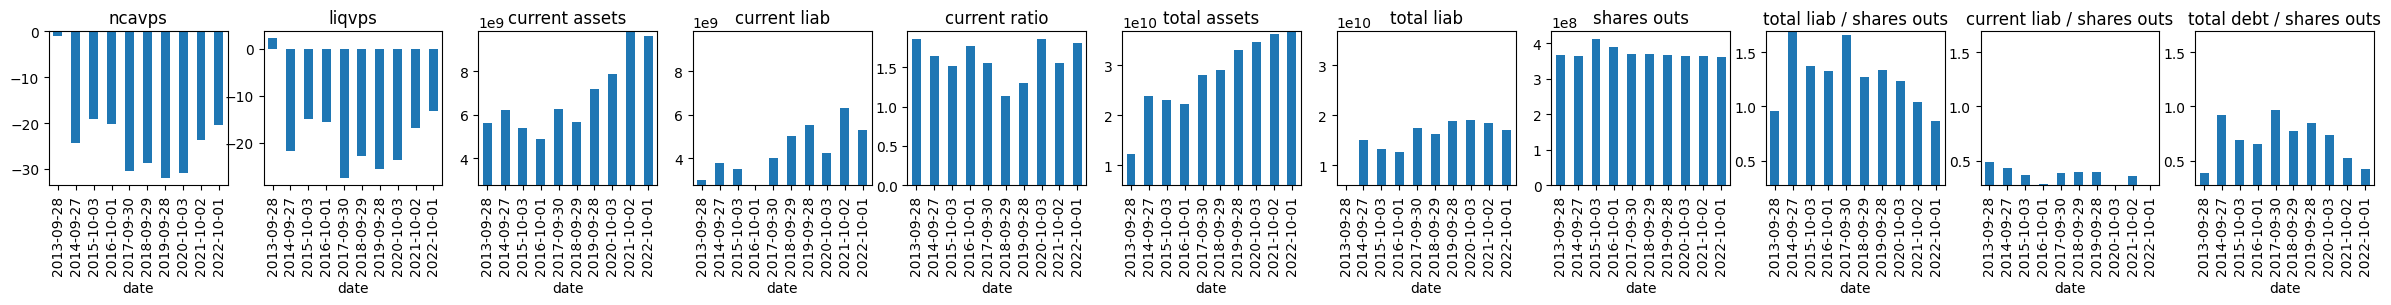

CPU times: user 1.68 s, sys: 69.9 ms, total: 1.75 s
Wall time: 2.94 s


In [16]:
%%time
#missed_tickers = []
#full_df = pd.DataFrame()
for ticker in ["TSN"]:
    # define urls
    url_balance_sheet = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?limit=10&apikey={KEY}"
    url_income_stmt = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=10&apikey={KEY}"

    try:
        # load data
        response_balance_sheet = urlopen(url_balance_sheet, cafile=certifi.where())
        response_income_stmt = urlopen(url_income_stmt, cafile=certifi.where())
    except:
        missed_tickers.append(ticker)
        
    data_balance_sheet = response_balance_sheet.read().decode("utf-8")
    data_balance_sheet = json.loads(data_balance_sheet)
    if len(data_balance_sheet) < 5:
        continue

    data_income_stmt = response_income_stmt.read().decode("utf-8")
    data_income_stmt = json.loads(data_income_stmt)
    if len(data_income_stmt) < 5:
        continue
        
    balance_sheet_df = pd.DataFrame(data_balance_sheet)
    income_stmt_df = pd.DataFrame(data_income_stmt)
    balance_sheet_df = balance_sheet_df.set_index("date")
    income_stmt_df = income_stmt_df.set_index("date")
    balance_sheet_df = balance_sheet_df[bs_cols]
    income_stmt_df = income_stmt_df[is_cols]

    fs_df = pd.concat([balance_sheet_df, income_stmt_df], axis=1, join="inner")
    fs_df = fs_df.iloc[::-1] # from oldest to newest
    # compute NCAV
    fs_df["ncavps"] = fs_df.apply(compute_ncavps, axis=1)
    # compute LIQV
    fs_df["liqvps"] = fs_df.apply(compute_liqvps, args=(factors,), axis=1)
    # compute current ratio
    fs_df["current_ratio"] = fs_df.apply(compute_current_ratio, axis=1)
    # compute de ratio 1
    fs_df["de_ratio1"] = fs_df.apply(compute_de_ratio1, axis=1)
    # compute de ratio 2
    fs_df["de_ratio2"] = fs_df.apply(compute_de_ratio2, axis=1)
    # compute de ratio 3
    fs_df["de_ratio3"] = fs_df.apply(compute_de_ratio3, axis=1)

    # plot indicators
    print(ticker)
    plot_indicators(fs_df)

In [41]:
fs_df

symbol  cashAndCashEquivalents  netReceivables  inventory  \
date                                                                   
2013-12-31   CSTE                22248000        75157000   57867000   
2014-12-31   CSTE                54327000        78946000   80212000   
2015-12-31   CSTE                62807000        91415000   95479000   
2016-12-31   CSTE               106270000       102556000  101474000   
2017-12-31   CSTE               138707000       106320000  132940000   
2018-12-31   CSTE                93562000        98050000  158492000   
2019-12-31   CSTE               139372000       112348000  122686000   
2020-12-31   CSTE               114248000       111303000  152073000   
2021-12-31   CSTE                74315000       118258000  204725000   
2022-12-31   CSTE                52081000       110468000  238232000   

            propertyPlantEquipmentNet  totalCurrentAssets  totalAssets  \
date                                                                     
2013-12-31                   93634000           225272000    377556000   
2014-12-31                  172993000           213485000    439000000   
2015-12-31                  225438000           249701000    529742000   
2016-12-31                  222818000           310300000    584700000   
2017-12-31                  216653000           377967000    652987000   
2018-12-31                  213338000           350104000    616922000   
2019-12-31                  278440000           374406000    705483000   
2020-12-31                  346811000           385736000    820921000   
2021-12-31                  375802000           408526000    867653000   
2022-12-31                  313390000           407858000    752981000   

            totalCurrentLiabilities  totalLiabilities  \
date                                                    
2013-12-31                 79570000         104333000   
2014-12-31                 89179000         109274000   
2015-12-31                 80860000         120680000   
2016-12-31                 93337000         134108000   
2017-12-31                127457000         166611000   
2018-12-31                111061000         150421000   
2019-12-31                127006000         227759000   
2020-12-31                157015000         325870000   
2021-12-31                183294000         365489000   
2022-12-31                164984000         324032000   

            totalStockholdersEquity  totalDebt    netDebt  \
date                                                        
2013-12-31                265599000   17796000   -4452000   
2014-12-31                321011000   11739000  -42588000   
2015-12-31                400221000   14205000  -48602000   
2016-12-31                439901000   19709000  -86561000   
2017-12-31                469895000   15990000 -122717000   
2018-12-31                472088000   17564000  -75998000   
2019-12-31                483311000   75742000  -63630000   
2020-12-31                492937000  148768000   34520000   
2021-12-31                499882000  164363000   90048000   
2022-12-31                426633000  155594000  103513000   

            weightedAverageShsOutDil    ncavps    liqvps  current_ratio  \
date                                                                      
2013-12-31                  35209946  3.434797  2.144155       2.831117   
2014-12-31                  35394000  2.944313  4.866427       2.393893   
2015-12-31                  35464000  3.638084  6.304699       3.088066   
2016-12-31                  34764000  5.068232  7.604972       3.324512   
2017-12-31                  34386000  6.146571  8.203150       2.965447   
2018-12-31                  34409000  5.803220  7.544906       3.152358   
2019-12-31                  34460000  4.255572  7.593088       2.947939   
2020-12-31                  34474000  1.736555  5.831281       2.456682   
2021-12-31                  34570000  1.244923  5.150557       2.228802   
2022-12-31    

In [42]:
((fs_df["ncavps"] - fs_df["ncavps"].shift()) / fs_df["ncavps"].shift())

date
2013-12-31         NaN
2014-12-31   -0.142799
2015-12-31    0.235631
2016-12-31    0.393105
2017-12-31    0.212765
2018-12-31   -0.055861
2019-12-31   -0.266688
2020-12-31   -0.591934
2021-12-31   -0.283107
2022-12-31    0.952397
Name: ncavps, dtype: float64

In [43]:
fs_df["ncavps"]

date
2013-12-31    3.434797
2014-12-31    2.944313
2015-12-31    3.638084
2016-12-31    5.068232
2017-12-31    6.146571
2018-12-31    5.803220
2019-12-31    4.255572
2020-12-31    1.736555
2021-12-31    1.244923
2022-12-31    2.430585
Name: ncavps, dtype: float64

In [34]:
6.44/(6.62*1.2)

0.8106747230614301